# DDM Model Fitting with Dual-Prior Support

This notebook demonstrates fitting of Drift Diffusion Models (DDM) using the optimized implementation that supports dual-prior conditions (equal vs unequal prior blocks).

## Key Features:
- **Dual-prior support**: Separate parameters for equal and unequal prior conditions
- **Optimized performance**: CUDA acceleration and efficient NumPy/PyTorch operations  
- **Robust fitting**: Multi-stage optimization with differential evolution
- **Parameter structure**: 
  - Global parameters: `ndt`, `drift_gain`, `variance`, `leak_rate`, `time_constant`
  - Condition-specific: `a_1/a_2`, `z_1/z_2`, `drift_offset_1/drift_offset_2`

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pickle
from pathlib import Path

from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

from src.utils import pmf_utils
from config import dir_config
import time


In [8]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)
ddm_dir = Path(dir_config.data.processed, "ddm")

ENABLE_LEAK = True
ENABLE_TIME_DEPENDENCY = True
MODEL_TYPE = "all_param_vary"

In [9]:
model_folder = f"ddm_leak_{ENABLE_LEAK}_urgency_{ENABLE_TIME_DEPENDENCY}"
model_dir = Path(ddm_dir, model_folder)

## Helper functions

In [10]:
def simulate_ddm(model, result_dict, stimulus):
    """
    Simulate DDM for a specific prior condition using fitted parameters.

    Args:
        idx_prior: 0 for 'equal' prior, 1 for 'unequal' prior
        model: The fitted DecisionModel instance
        result_dict: Dictionary containing fitted parameters
        stimulus: Stimulus array for this prior condition
        enable_leak: Whether leak was enabled in fitting
        enable_time_dependence: Whether time dependence was enabled in fitting

    Returns:
        DataFrame with simulated data
    """
    # Get parameters from the result dictionary
    parameters = result_dict["parameters"]

    for param_name, param_value in parameters.items():
        setattr(model.simulator, param_name, param_value)
        print(f"{param_name}: {param_value:.4f}")

    # Simulate trials using the model's simulate method
    sim_result = model.simulate(stimulus, n_reps=1)

    # Create DataFrame of simulated data
    model_sim = pd.DataFrame(
        {
            "signed_coherence": sim_result["coherence"] * 100,  # Convert back to original scale
            "choice": sim_result["choice"],
            "rt": sim_result["rt"],
        }
    )
    model_sim["outcome"] = np.where((model_sim["choice"] * 2 - 1) == np.sign(model_sim["signed_coherence"]), 1, 0)
    model_sim["outcome"][model_sim["signed_coherence"] == 0] = np.random.choice([0, 1], size=np.sum(model_sim["signed_coherence"] == 0))

    return model_sim


def plot_ddm_fit(model_sim, data):
    # if data has column name rt change it to response_time
    if "rt" in data.columns:
        data = data.rename(columns={"rt": "response_time"})
    if "rt" in model_sim.columns:
        model_sim = model_sim.rename(columns={"rt": "response_time"})

    # Plotting
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3)

    # Get psychometric and chronometric data for both real and simulated data
    x_data, y_data, _, _, _ = pmf_utils.get_psychometric_data(data)
    x_fit, y_fit, _, _, _ = pmf_utils.get_psychometric_data(model_sim)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(x_data, y_data, "o", color="k", label="data")
    ax1.plot(x_fit, y_fit, "o", color="b", label="model")
    ax1.set_ylim(-0.1, 1.1)
    ax1.legend()
    ax1.set_title("Psychometric Function")

    # Chronometric plot (RT means)
    _, rt_median, rt_mean, rt_sd, _ = pmf_utils.get_chronometric_data(data, outcome=1)
    model_coh, rt_median_fit, rt_mean_fit, rt_sd_fit, _ = pmf_utils.get_chronometric_data(model_sim, outcome=1)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x_data, rt_mean, "o", color="k", label="data")
    ax2.fill_between(x_data, rt_mean - rt_sd, rt_mean + rt_sd, color="k", alpha=0.2)
    ax2.fill_between(model_coh, rt_mean_fit - rt_sd_fit, rt_mean_fit + rt_sd_fit, color="b", alpha=0.2)
    ax2.plot(model_coh, rt_mean_fit, "o", color="b", label="model", markersize=8)
    ax2.legend()
    ax2.set_xlabel("Signed Coherence (%)")
    ax2.set_ylabel("Response Time (s)")
    ax2.set_xlim(-50, 50)
    ax2.set_title("Chronometric Function (Correct Trials)")

    # Chronometric plot (RT means)
    coh, rt_median, rt_mean, rt_sd, _ = pmf_utils.get_chronometric_data(data, outcome=0)
    coh_fit, rt_median_fit, rt_mean_fit, rt_sd_fit, _ = pmf_utils.get_chronometric_data(model_sim, outcome=0)

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(coh, rt_mean, "o", color="k", label="data")
    ax3.fill_between(coh, rt_mean - rt_sd, rt_mean + rt_sd, color="k", alpha=0.2)
    ax3.plot(coh_fit, rt_mean_fit, "o", color="b", label="model", markersize=8)
    ax3.fill_between(coh_fit, rt_mean_fit - rt_sd_fit, rt_mean_fit + rt_sd_fit, color="b", alpha=0.2)
    ax3.legend()
    ax3.set_title("Chronometric Function (Incorrect Trials)")
    ax3.set_xlabel("Signed Coherence (%)")
    ax3.set_ylabel("Response Time (s)")
    ax3.set_xlim(-50, 50)

    plt.tight_layout()
    plt.show()

    # Print proportion of invalid trials (NaN choices)
    print("Proportion of invalid trials:", np.mean(np.isnan(model_sim["choice"])))


## import data

In [11]:
behavior_df = pd.read_csv(Path(ddm_dir, "behavior_data.csv"))

if MODEL_TYPE == "three_param_vary":
    model_files = [f for f in list(model_dir.glob("*.pkl")) if f.is_file() and "_prior" not in f.name]
elif MODEL_TYPE == "all_param_vary":
    model_files = [f for f in list(model_dir.glob("*.pkl")) if f.is_file() and "_prior" in f.name]
model_files.sort()

print("Total model files found:", len(model_files))


Total model files found: 90


## Testing fitted model

In [ ]:
for f in model_files:
    with open(f, "rb") as pkl_file:
        model_dict = pickle.load(pkl_file)
    session_id = model_dict["session_id"]
    session_data = behavior_df[behavior_df["session_id"] == session_id]


210224_GP_JP_prior_block_unequal
Skipping session 210224_GP_JP due to insufficient optimization iterations: 1
210302_GP_JP_prior_block_unequal
Skipping session 210302_GP_JP due to insufficient optimization iterations: 1
240625_GP_TZ_prior_block_unequal
Skipping session 240625_GP_TZ due to insufficient optimization iterations: 1
240627_GP_TZ_prior_block_unequal
Skipping session 240627_GP_TZ due to insufficient optimization iterations: 1
240710_GP_TZ_prior_block_unequal
Skipping session 240710_GP_TZ due to insufficient optimization iterations: 1
241129_GP_TZ_prior_block_unequal
Skipping session 241129_GP_TZ due to insufficient optimization iterations: 1
241130_GP_TZ_prior_block_unequal
Skipping session 241130_GP_TZ due to insufficient optimization iterations: 1
241209_GP_TZ_prior_block_unequal
Skipping session 241209_GP_TZ due to insufficient optimization iterations: 1
241211_GP_TZ_prior_block_unequal
Skipping session 241211_GP_TZ due to insufficient optimization iterations: 1
241216_GP_


Session: 210126_GP_JP, Prior: equal)
Prior condition 'equal' in session 210126_GP_JP has 448 trials
a: 3.5680
z: 0.3921
drift_offset: 0.6730
ndt: 0.1401
drift_gain: 14.5535
variance: 2.5327
leak_rate: 0.2014
time_constant: 0.0065


Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 44.32383345364819
       x: [ 3.568e+00  3.921e-01  6.730e-01  1.401e-01  1.455e+01
            2.533e+00  2.014e-01  6.466e-03]
     nit: 14
    nfev: 1245
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 448 trials.
Valid simulated trials: 448


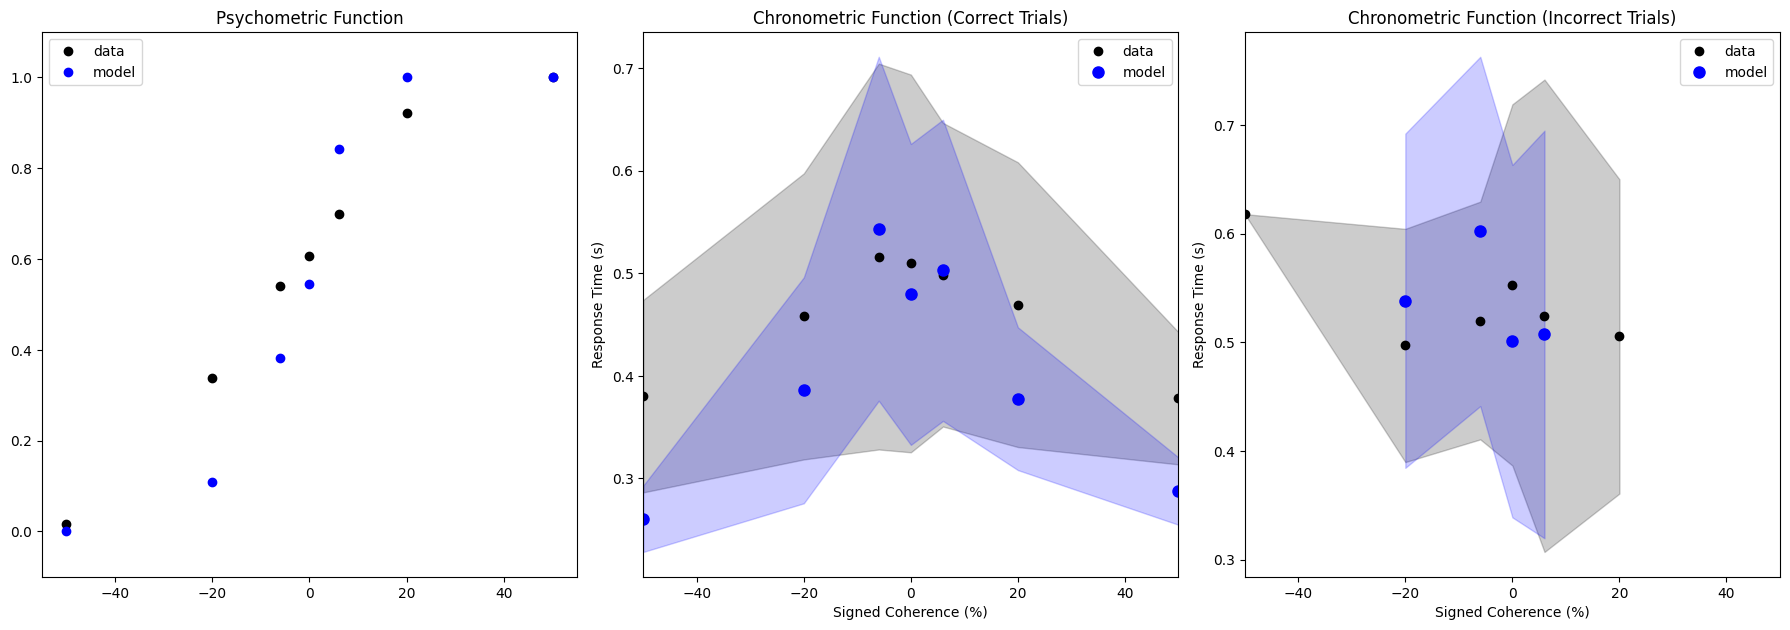

Proportion of invalid trials: 0.0

Session: 210126_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210126_GP_JP has 613 trials
a: 1.9206
z: 0.2090
drift_offset: -0.1234
ndt: 0.2506
drift_gain: 13.0285
variance: 3.0402
leak_rate: 0.9235
time_constant: 0.0037
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 45.04838655168663
       x: [ 1.921e+00  2.090e-01 -1.234e-01  2.506e-01  1.303e+01
            3.040e+00  9.235e-01  3.733e-03]
     nit: 17
    nfev: 1539
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 613 trials.
Valid simulated trials: 613


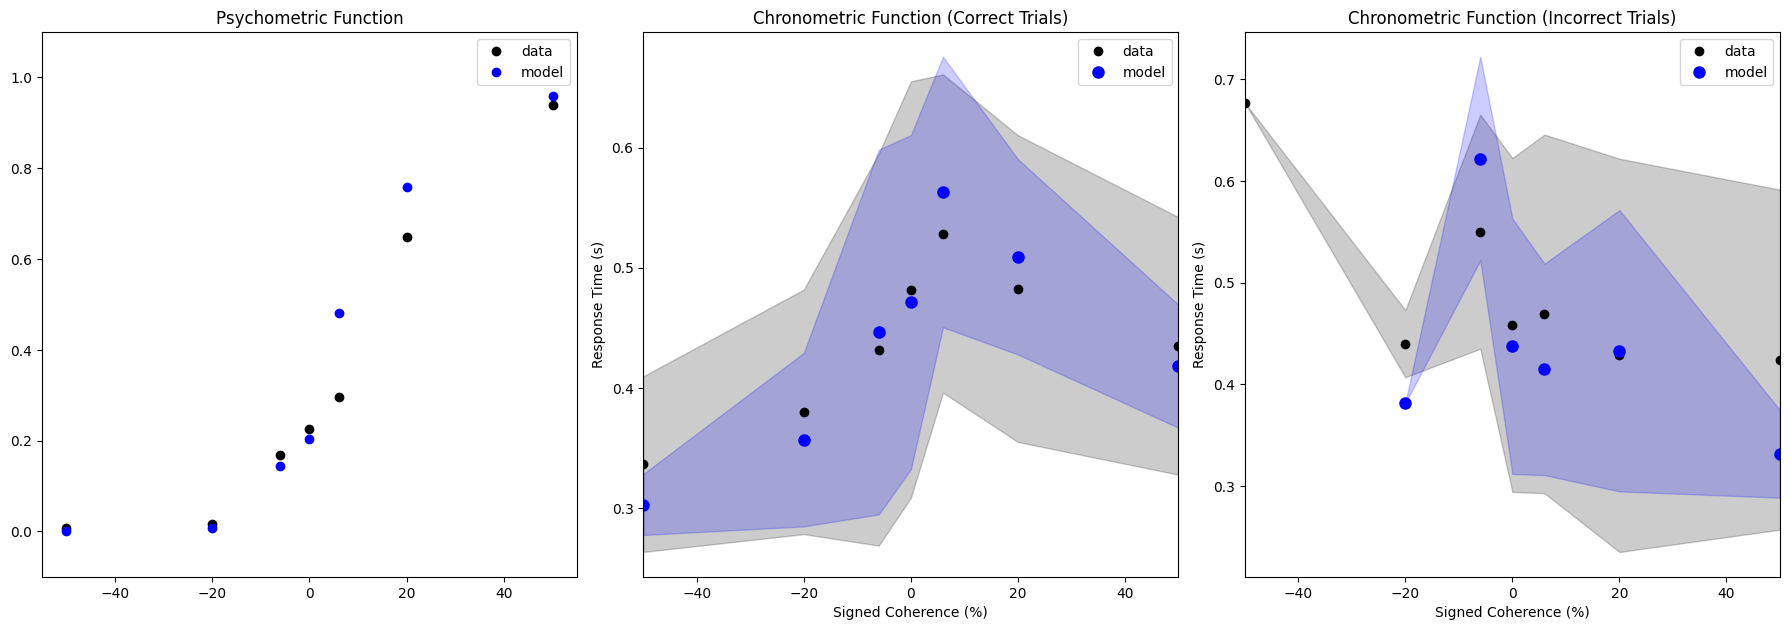

Proportion of invalid trials: 0.0

Session: 210205_GP_JP, Prior: equal)
Prior condition 'equal' in session 210205_GP_JP has 347 trials
a: 2.9676
z: 0.1727
drift_offset: 0.9302
ndt: 0.3101
drift_gain: 9.8124
variance: 2.2110
leak_rate: 0.8939
time_constant: 0.0013
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 33.96156823034676
       x: [ 2.968e+00  1.727e-01  9.302e-01  3.101e-01  9.812e+00
            2.211e+00  8.939e-01  1.347e-03]
     nit: 29
    nfev: 2445
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 347 trials.
Valid simulated trials: 347


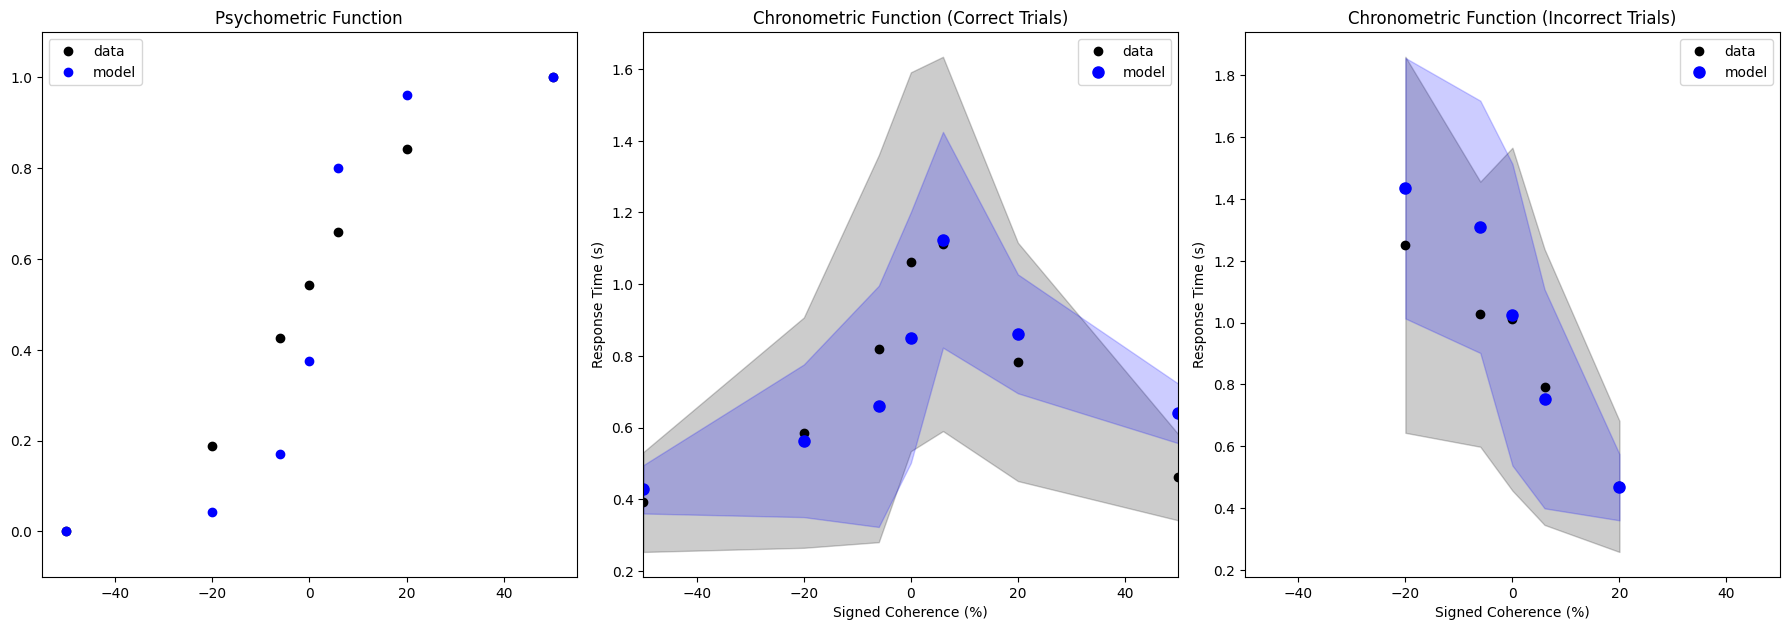

Proportion of invalid trials: 0.0

Session: 210205_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210205_GP_JP has 618 trials
a: 3.3191
z: 0.2898
drift_offset: -0.1920
ndt: 0.1179
drift_gain: 9.4649
variance: 4.1523
leak_rate: 0.2390
time_constant: 0.0013
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 55.23743048871865
       x: [ 3.319e+00  2.898e-01 -1.920e-01  1.179e-01  9.465e+00
            4.152e+00  2.390e-01  1.277e-03]
     nit: 29
    nfev: 2742
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -2.873e+01  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 618 trials.
Valid simulated trials: 618


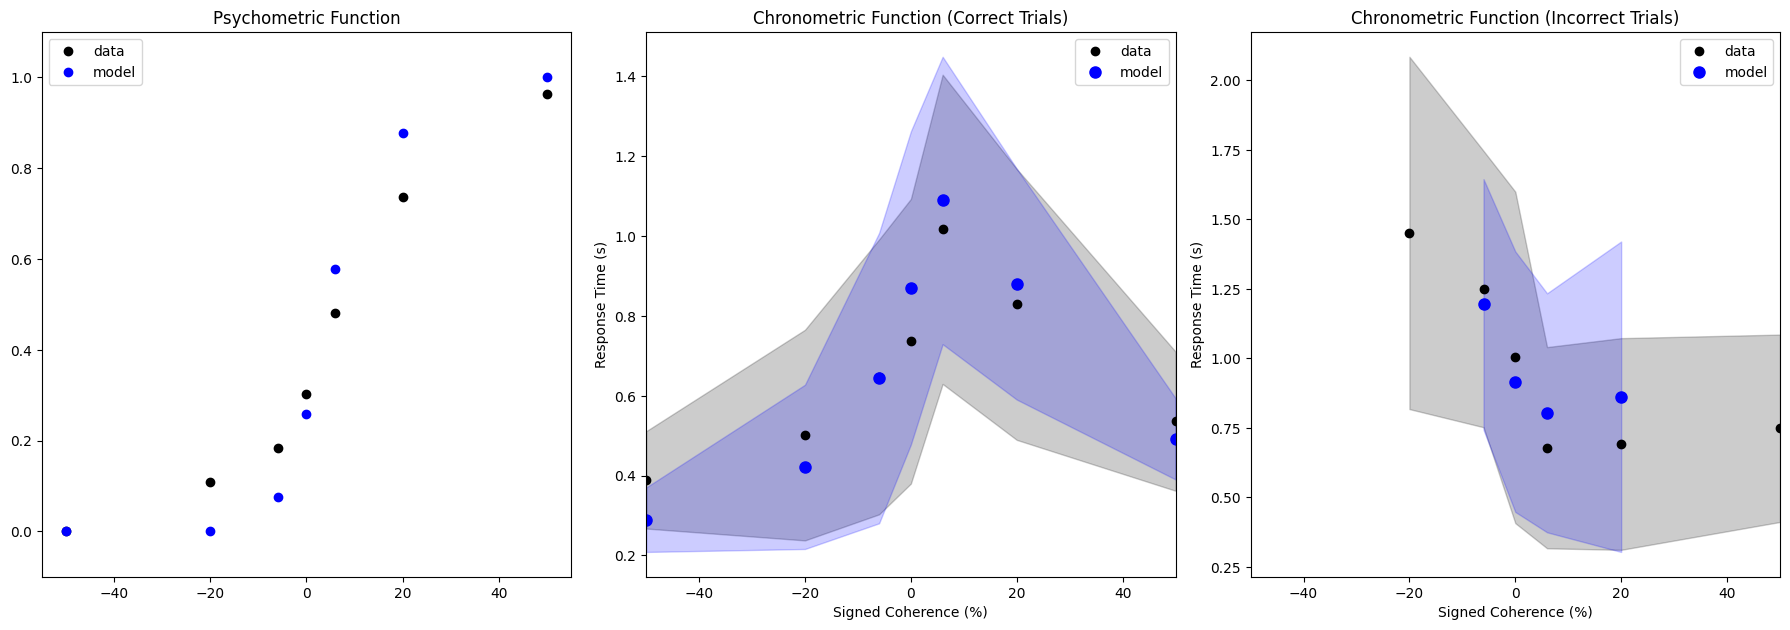

Proportion of invalid trials: 0.0

Session: 210210_GP_JP, Prior: equal)
Prior condition 'equal' in session 210210_GP_JP has 334 trials
a: 2.8799
z: 0.2900
drift_offset: -0.0080
ndt: 0.1545
drift_gain: 8.1541
variance: 4.2108
leak_rate: 0.2321
time_constant: 0.0011
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 29.542140205771876
       x: [ 2.880e+00  2.900e-01 -7.960e-03  1.545e-01  8.154e+00
            4.211e+00  2.321e-01  1.107e-03]
     nit: 37
    nfev: 3283
     jac: [ 0.000e+00  0.000e+00  0.000e+00  4.379e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 334 trials.
Valid simulated trials: 334


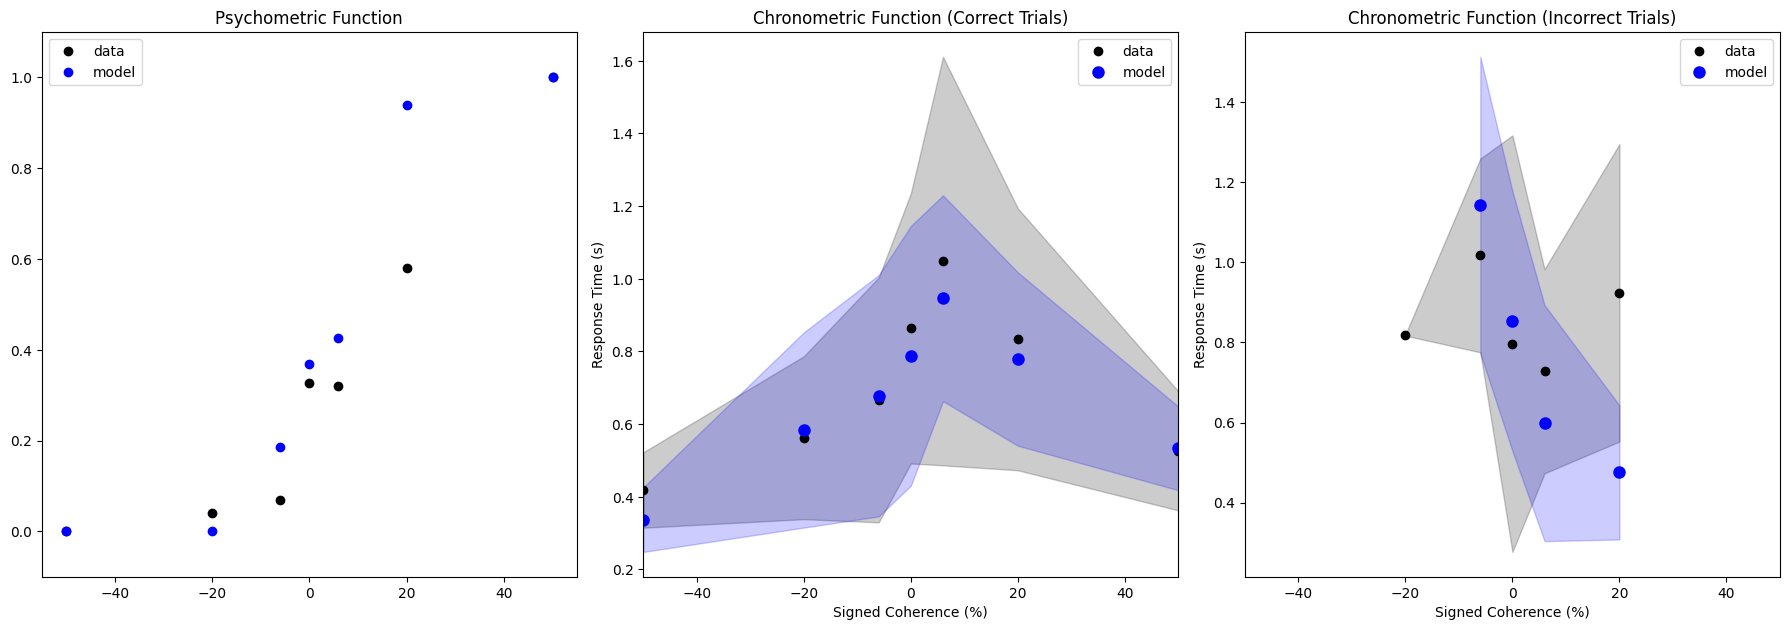

Proportion of invalid trials: 0.0

Session: 210210_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210210_GP_JP has 589 trials
a: 3.5212
z: 0.2451
drift_offset: 0.2419
ndt: 0.2513
drift_gain: 2.9280
variance: 0.6892
leak_rate: 0.0368
time_constant: 0.0022
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 56.67305236277009
       x: [ 3.521e+00  2.451e-01  2.419e-01  2.513e-01  2.928e+00
            6.892e-01  3.677e-02  2.209e-03]
     nit: 30
    nfev: 2651
     jac: [ 0.000e+00  0.000e+00  0.000e+00  9.506e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 589 trials.
Valid simulated trials: 589


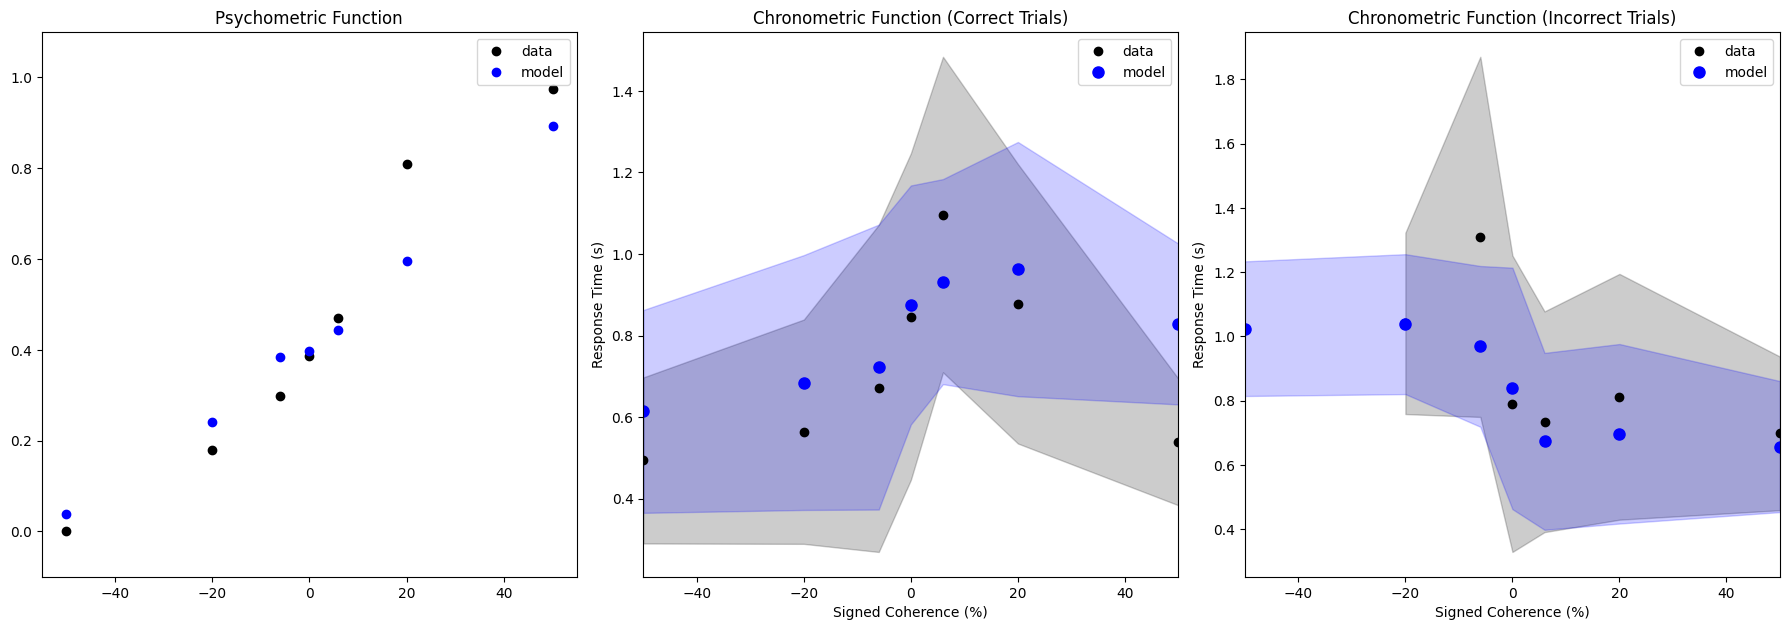

Proportion of invalid trials: 0.0

Session: 210211_GP_JP, Prior: equal)
Prior condition 'equal' in session 210211_GP_JP has 349 trials
a: 3.2381
z: 0.3806
drift_offset: 0.3172
ndt: 0.1000
drift_gain: 10.6236
variance: 3.2280
leak_rate: 0.8097
time_constant: 0.0011
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 33.373065188714314
       x: [ 3.238e+00  3.806e-01  3.172e-01  1.000e-01  1.062e+01
            3.228e+00  8.097e-01  1.068e-03]
     nit: 44
    nfev: 3618
     jac: [ 0.000e+00  0.000e+00  0.000e+00  1.003e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 349 trials.
Valid simulated trials: 349


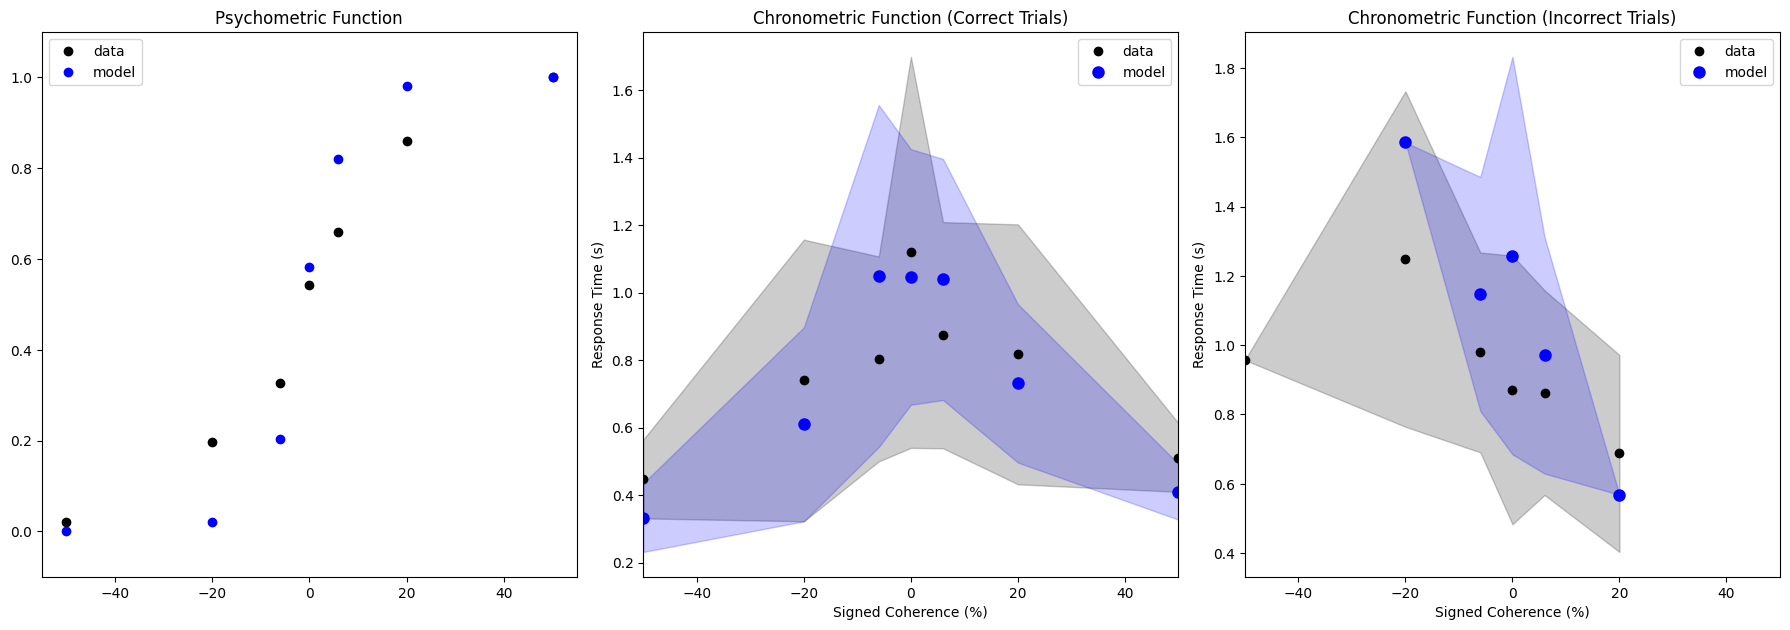

Proportion of invalid trials: 0.0

Session: 210211_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210211_GP_JP has 594 trials
a: 5.0743
z: 0.2503
drift_offset: 1.1438
ndt: 0.1634
drift_gain: 3.7472
variance: 3.6812
leak_rate: 0.1386
time_constant: 0.0016
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 45.544025168131476
       x: [ 5.074e+00  2.503e-01  1.144e+00  1.634e-01  3.747e+00
            3.681e+00  1.386e-01  1.568e-03]
     nit: 26
    nfev: 2187
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 594 trials.
Valid simulated trials: 593


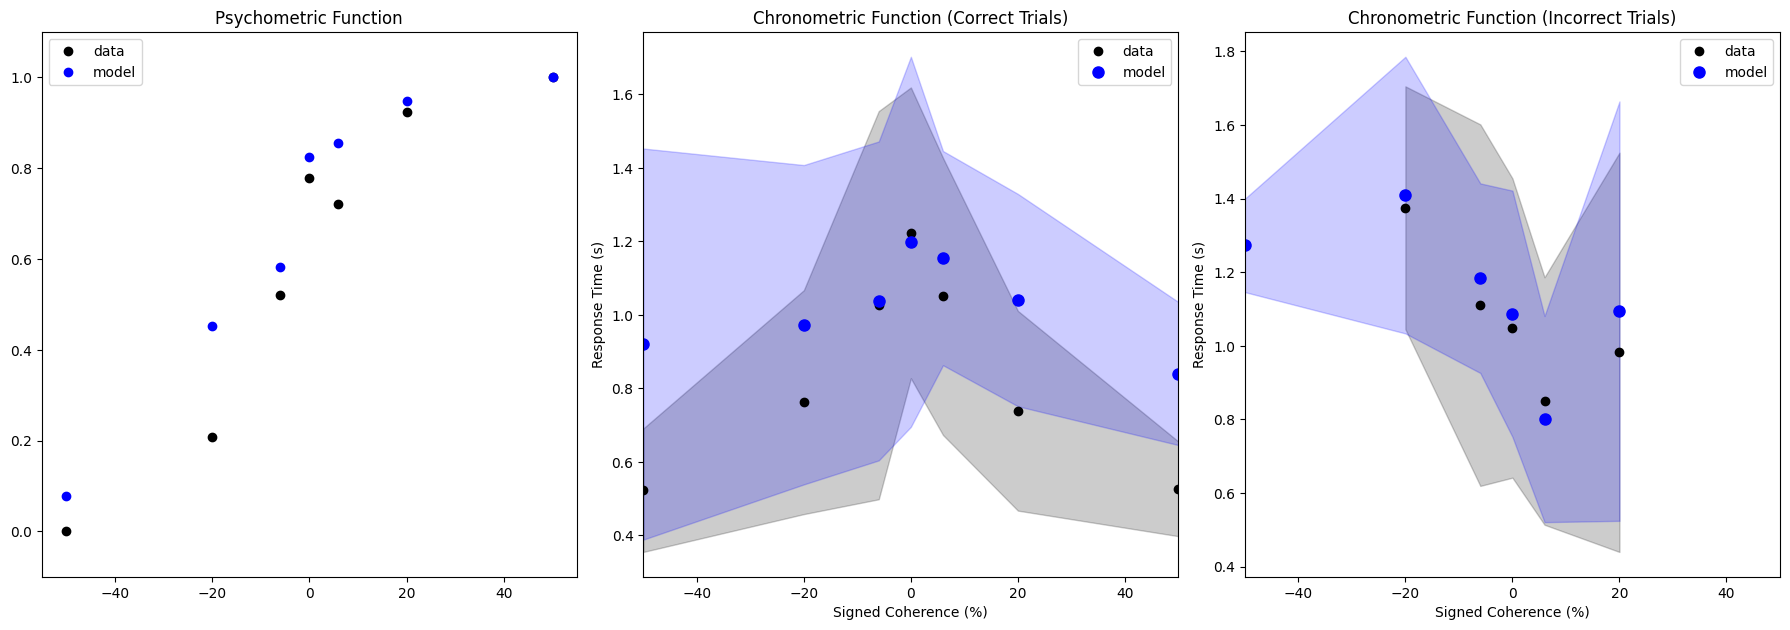

Proportion of invalid trials: 0.0016835016835016834

Session: 210217_GP_JP, Prior: equal)
Prior condition 'equal' in session 210217_GP_JP has 399 trials
a: 3.3759
z: 0.2960
drift_offset: 0.8577
ndt: 0.1418
drift_gain: 4.3142
variance: 1.1519
leak_rate: 0.5640
time_constant: 0.0017
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 34.64839886295921
       x: [ 3.376e+00  2.960e-01  8.577e-01  1.418e-01  4.314e+00
            1.152e+00  5.640e-01  1.719e-03]
     nit: 37
    nfev: 3049

Simulation completed. Generated 399 trials.
Valid simulated trials: 399


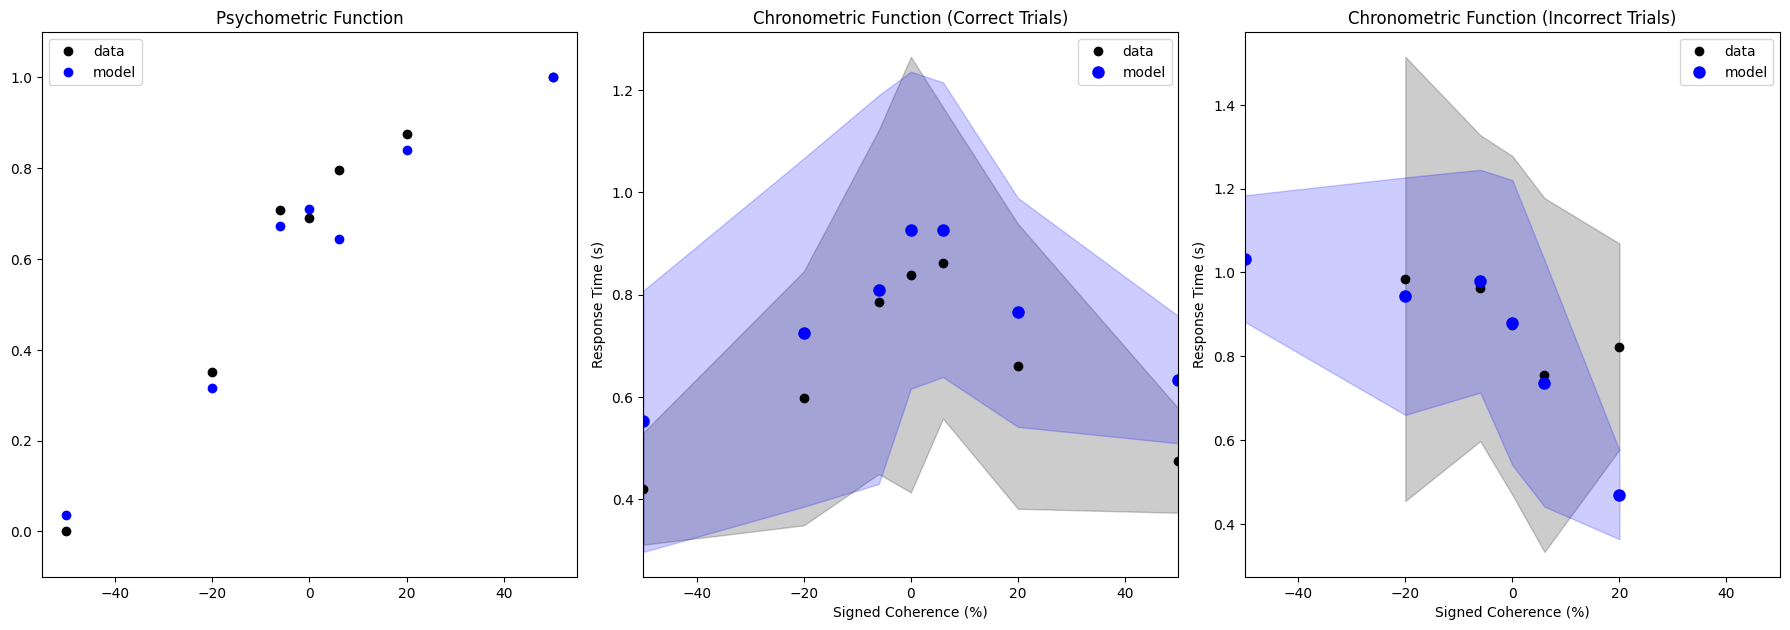

Proportion of invalid trials: 0.0

Session: 210217_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210217_GP_JP has 593 trials
a: 4.2395
z: 0.3968
drift_offset: -0.4549
ndt: 0.1036
drift_gain: 11.7712
variance: 3.3274
leak_rate: 0.2390
time_constant: 0.0024
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 51.43912001716883
       x: [ 4.240e+00  3.968e-01 -4.549e-01  1.036e-01  1.177e+01
            3.327e+00  2.390e-01  2.403e-03]
     nit: 30
    nfev: 2606

Simulation completed. Generated 593 trials.
Valid simulated trials: 593


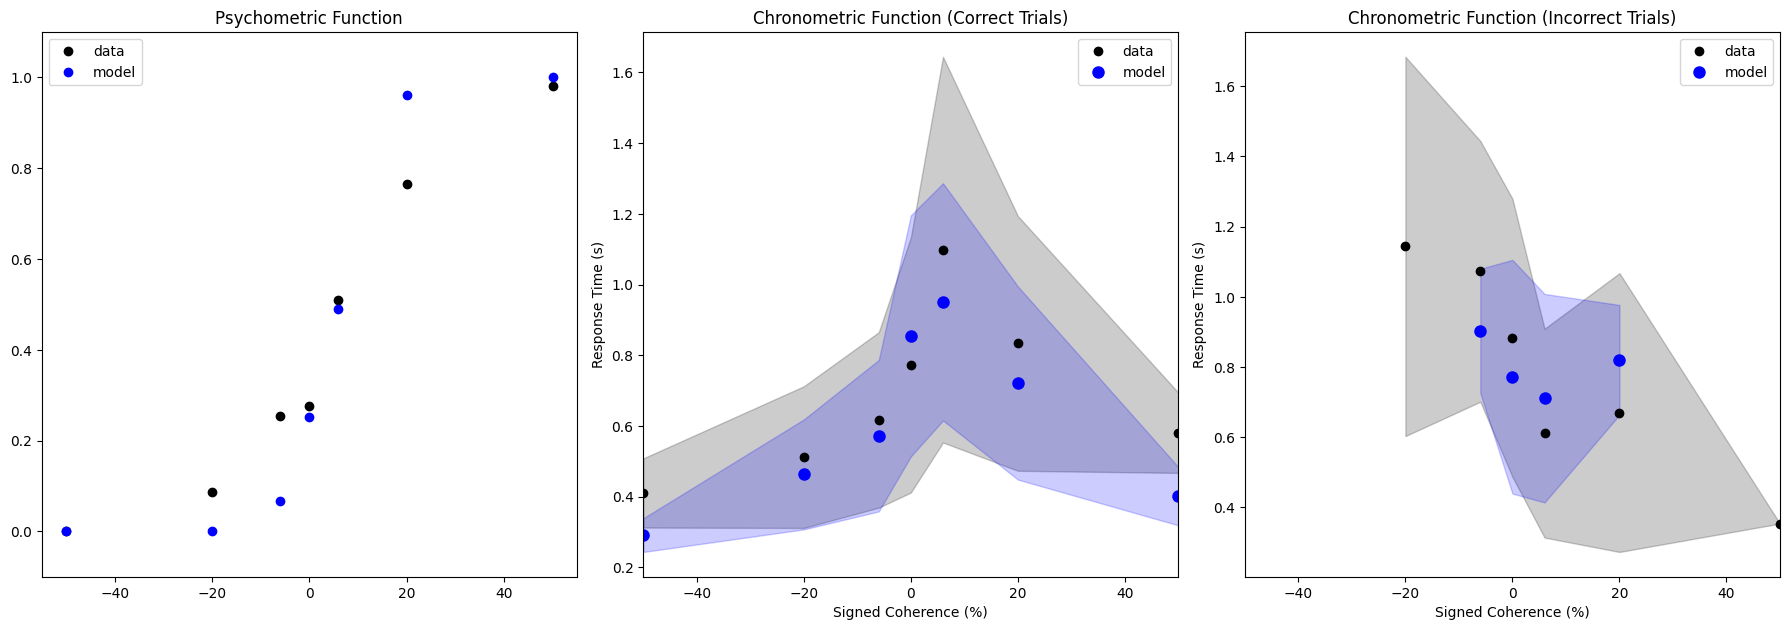

Proportion of invalid trials: 0.0

Session: 210224_GP_JP, Prior: equal)
Prior condition 'equal' in session 210224_GP_JP has 492 trials
a: 3.0551
z: 0.4274
drift_offset: -0.9800
ndt: 0.1623
drift_gain: 15.3107
variance: 1.6403
leak_rate: 0.7514
time_constant: 0.0039
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 33.67592872798268
       x: [ 3.055e+00  4.274e-01 -9.800e-01  1.623e-01  1.531e+01
            1.640e+00  7.514e-01  3.880e-03]
     nit: 29
    nfev: 2409

Simulation completed. Generated 492 trials.
Valid simulated trials: 492


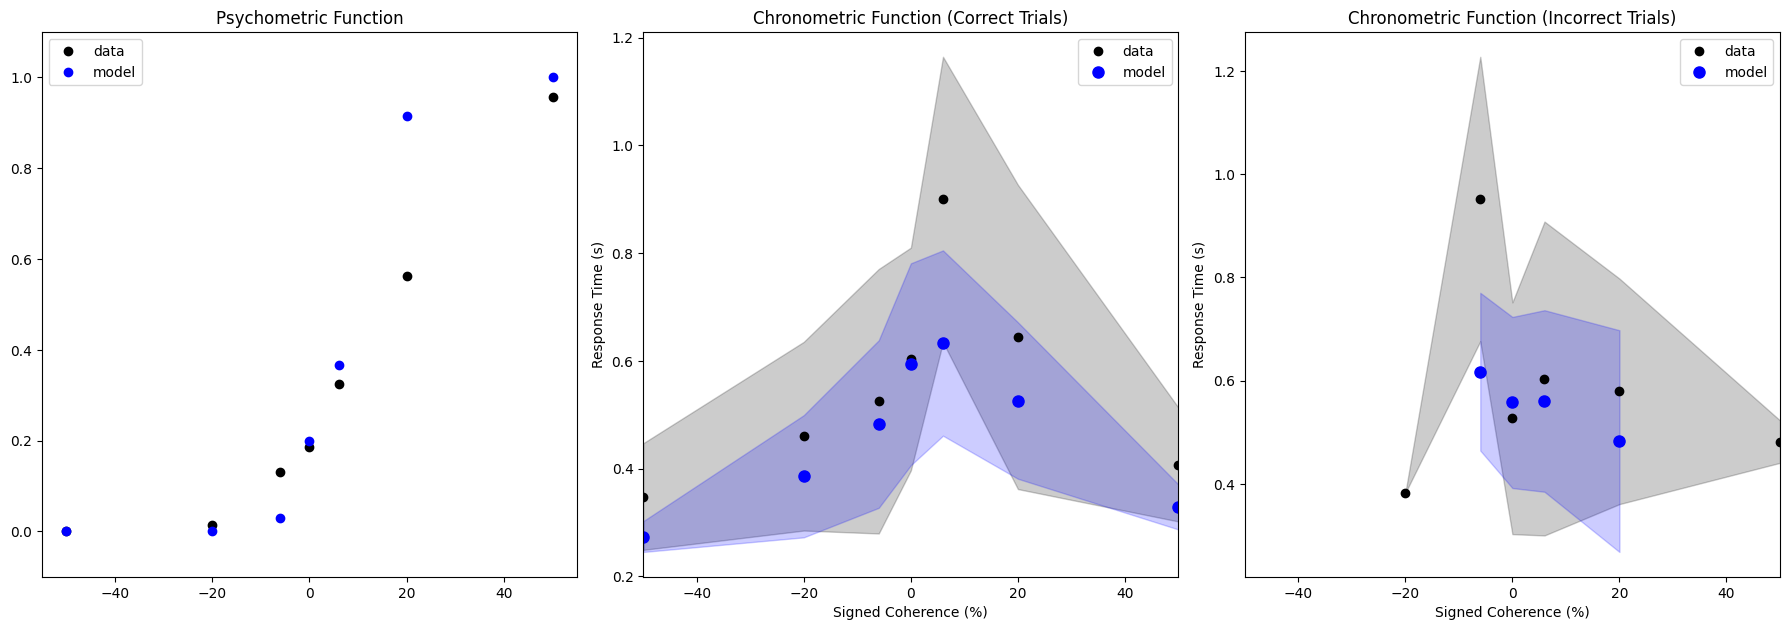

Proportion of invalid trials: 0.0
210224_GP_JP_prior_block_unequal
Skipping session 210224_GP_JP due to insufficient optimization iterations: 1

Session: 210302_GP_JP, Prior: equal)
Prior condition 'equal' in session 210302_GP_JP has 353 trials
a: 2.5318
z: 0.3328
drift_offset: 0.6320
ndt: 0.1632
drift_gain: 7.1442
variance: 1.7088
leak_rate: 0.6224
time_constant: 0.0014
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 34.295745885754975
       x: [ 2.532e+00  3.328e-01  6.320e-01  1.632e-01  7.144e+00
            1.709e+00  6.224e-01  1.386e-03]
     nit: 36
    nfev: 3041
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 353 trials.
Valid simulated trials: 353


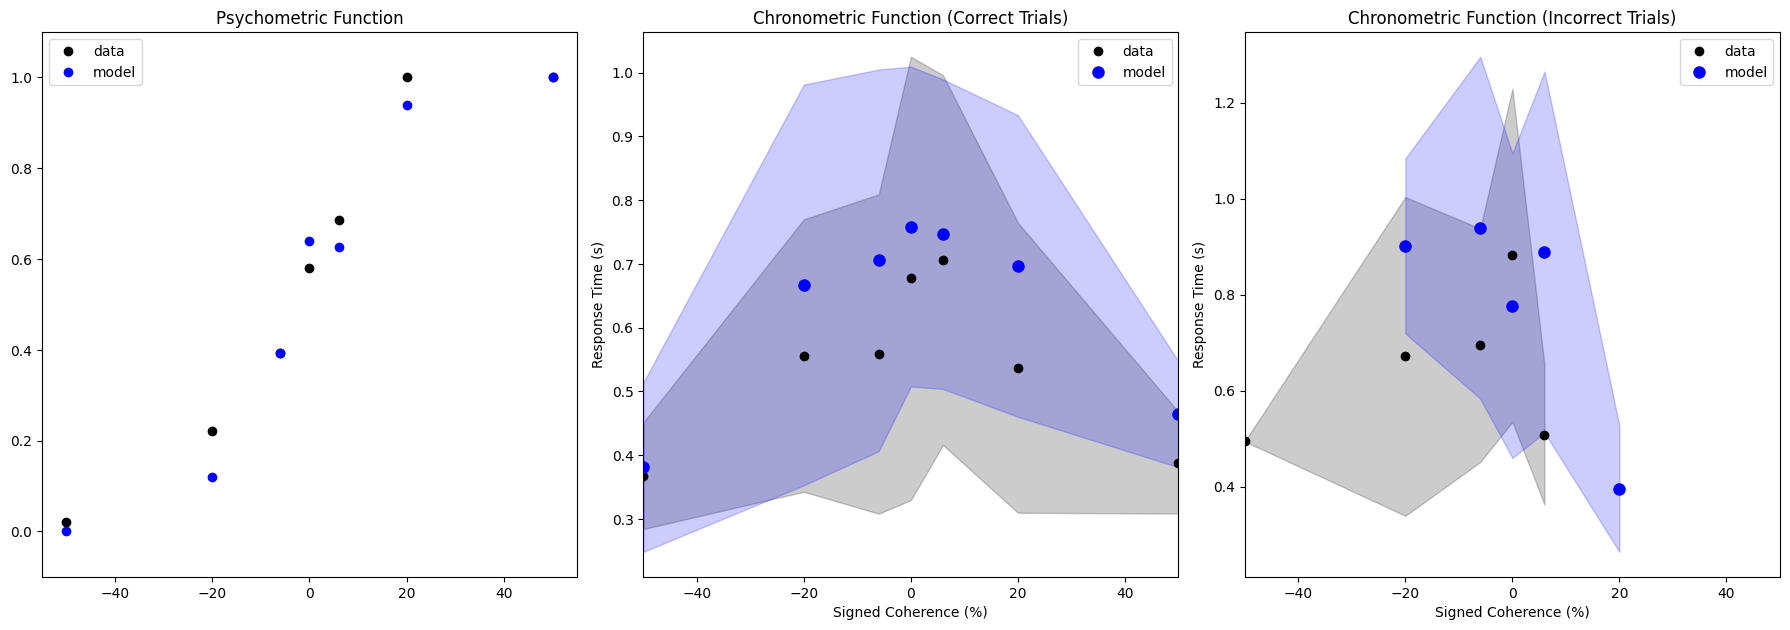

Proportion of invalid trials: 0.0
210302_GP_JP_prior_block_unequal
Skipping session 210302_GP_JP due to insufficient optimization iterations: 1

Session: 210305_GP_JP, Prior: equal)
Prior condition 'equal' in session 210305_GP_JP has 354 trials
a: 4.6628
z: 0.3283
drift_offset: 1.0519
ndt: 0.1366
drift_gain: 17.0129
variance: 2.1691
leak_rate: 0.1203
time_constant: 0.0020
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 23.517950864714237
       x: [ 4.663e+00  3.283e-01  1.052e+00  1.366e-01  1.701e+01
            2.169e+00  1.203e-01  1.988e-03]
     nit: 29
    nfev: 2490
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 354 trials.
Valid simulated trials: 354


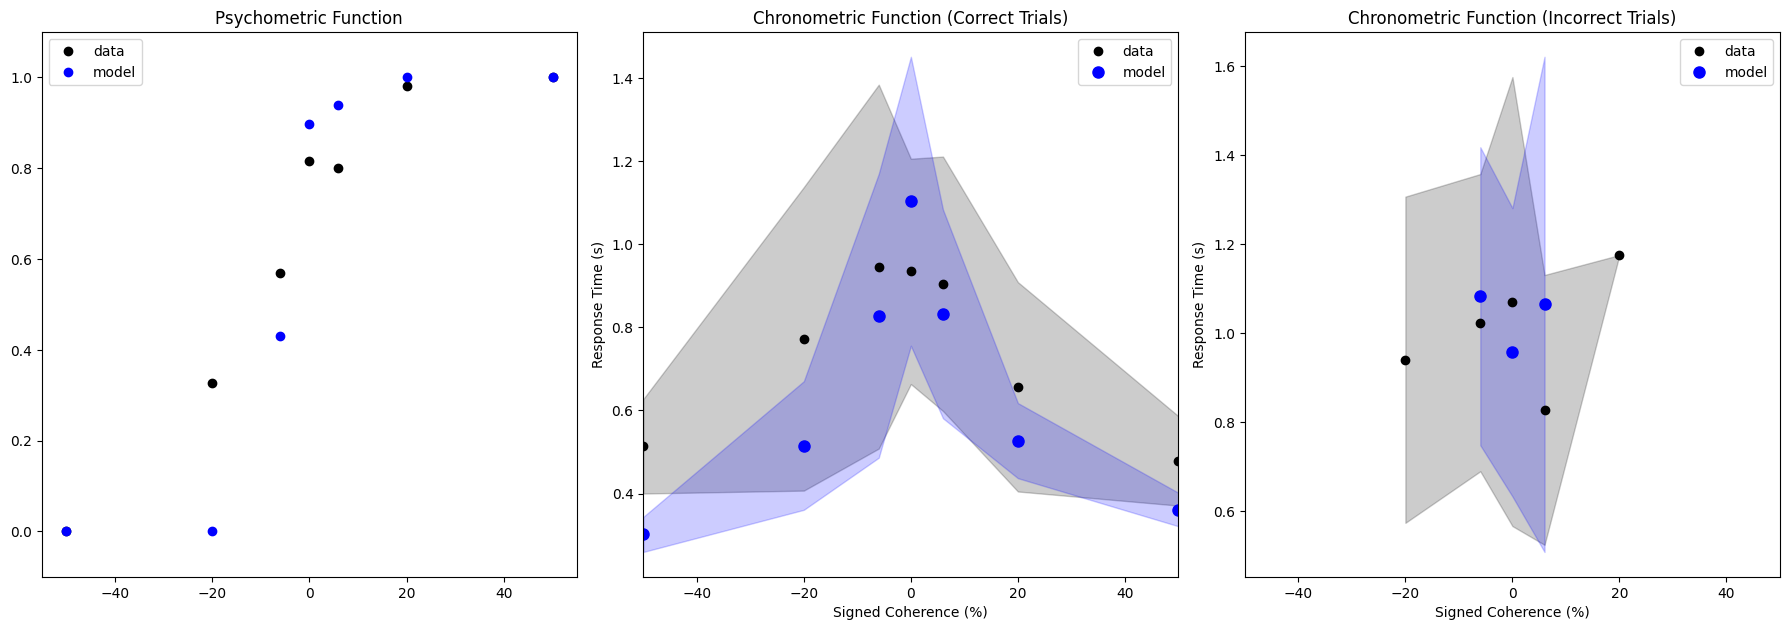

Proportion of invalid trials: 0.0

Session: 210305_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210305_GP_JP has 700 trials
a: 4.9122
z: 0.1699
drift_offset: 0.1770
ndt: 0.2621
drift_gain: 2.4721
variance: 4.4574
leak_rate: 0.4997
time_constant: 0.0024
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 58.32004591664922
       x: [ 4.912e+00  1.699e-01  1.770e-01  2.621e-01  2.472e+00
            4.457e+00  4.997e-01  2.446e-03]
     nit: 31
    nfev: 2650
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 700 trials.
Valid simulated trials: 700


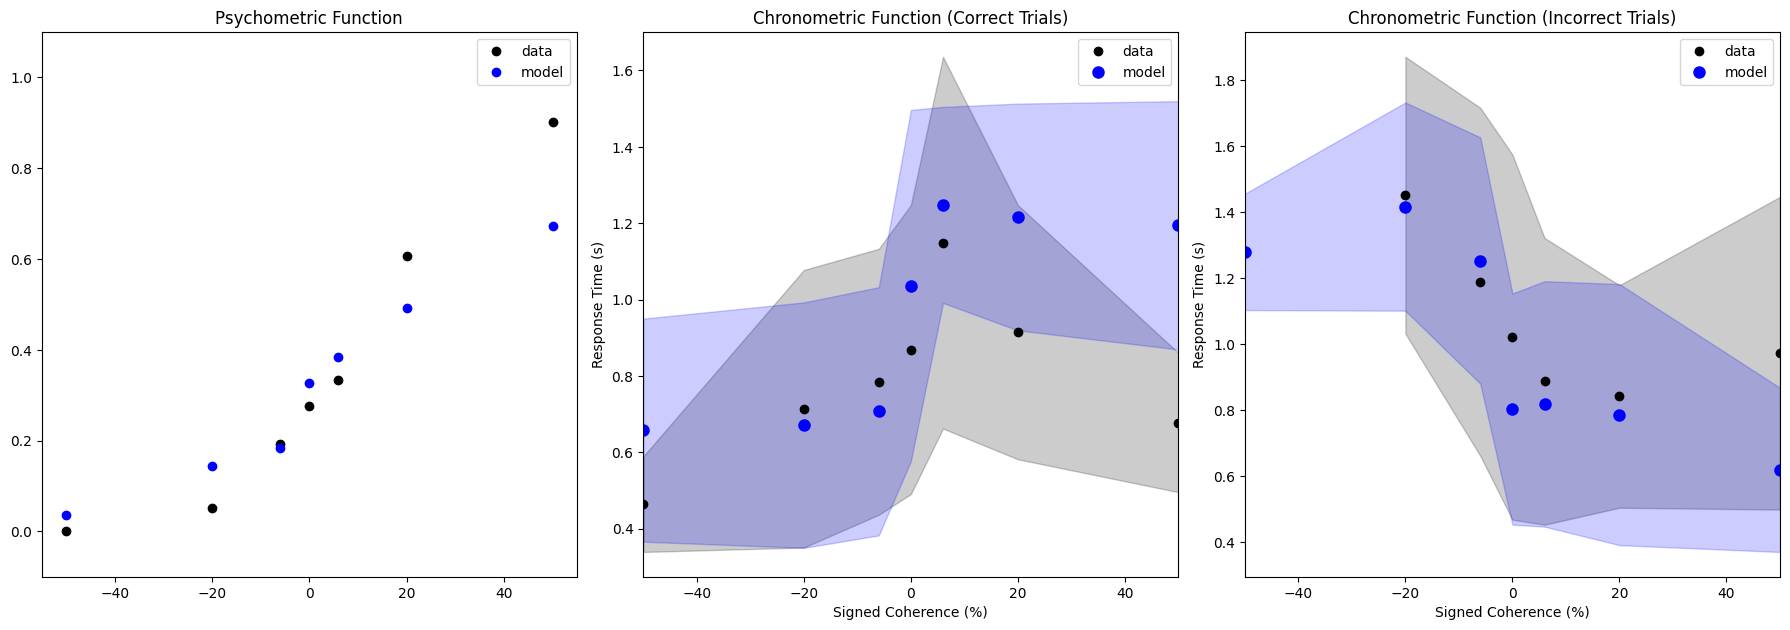

Proportion of invalid trials: 0.0

Session: 210311_GP_JP, Prior: equal)
Prior condition 'equal' in session 210311_GP_JP has 356 trials
a: 2.4461
z: 0.6614
drift_offset: -0.6813
ndt: 0.2389
drift_gain: 11.2342
variance: 3.4233
leak_rate: 0.4345
time_constant: 0.0049
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 35.39974046780006
       x: [ 2.446e+00  6.614e-01 -6.813e-01  2.389e-01  1.123e+01
            3.423e+00  4.345e-01  4.882e-03]
     nit: 18
    nfev: 1583
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 356 trials.
Valid simulated trials: 356


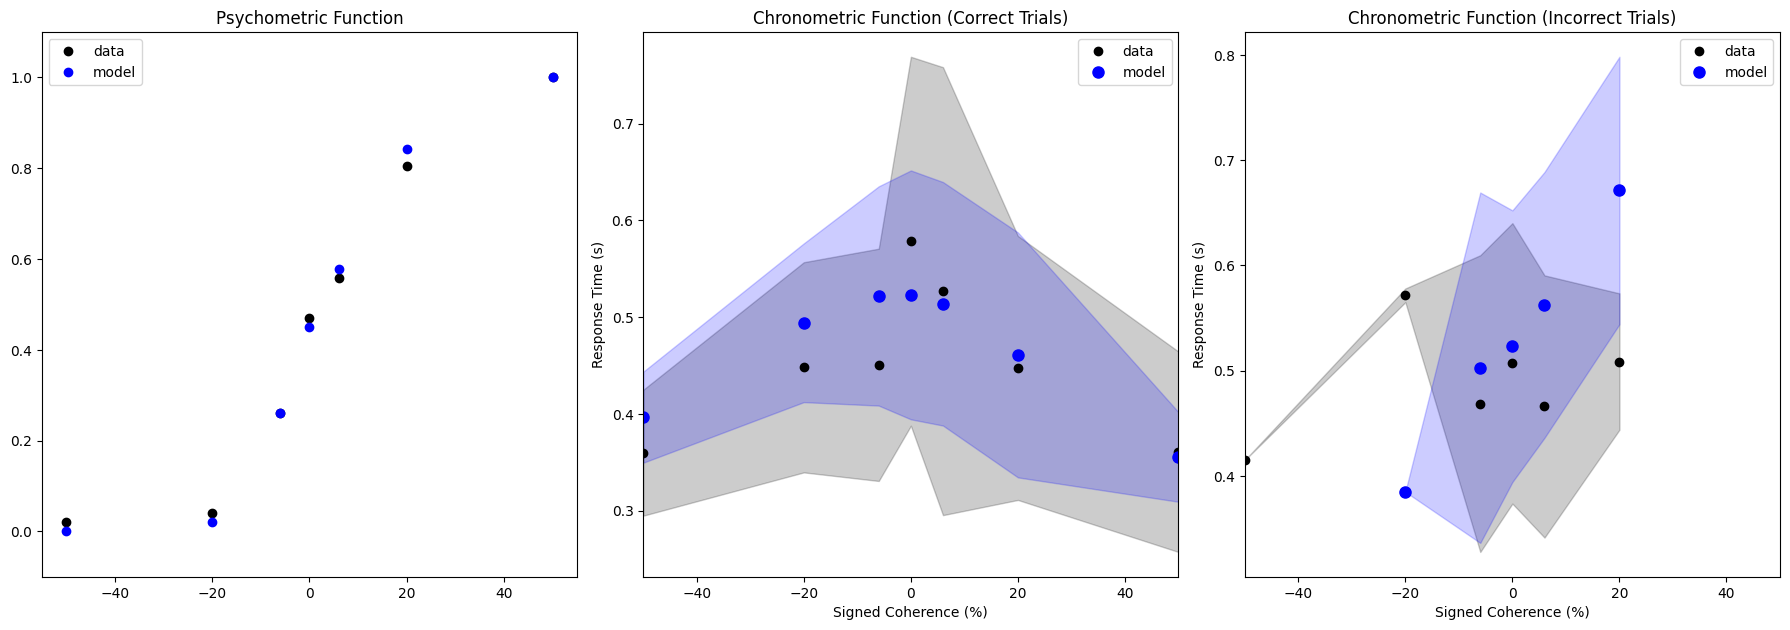

Proportion of invalid trials: 0.0

Session: 210311_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210311_GP_JP has 764 trials
a: 2.0762
z: 0.6132
drift_offset: -0.2459
ndt: 0.1471
drift_gain: 17.5159
variance: 3.8008
leak_rate: 0.1348
time_constant: 0.0018
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 75.72023694499931
       x: [ 2.076e+00  6.132e-01 -2.459e-01  1.471e-01  1.752e+01
            3.801e+00  1.348e-01  1.755e-03]
     nit: 23
    nfev: 1929

Simulation completed. Generated 764 trials.
Valid simulated trials: 764


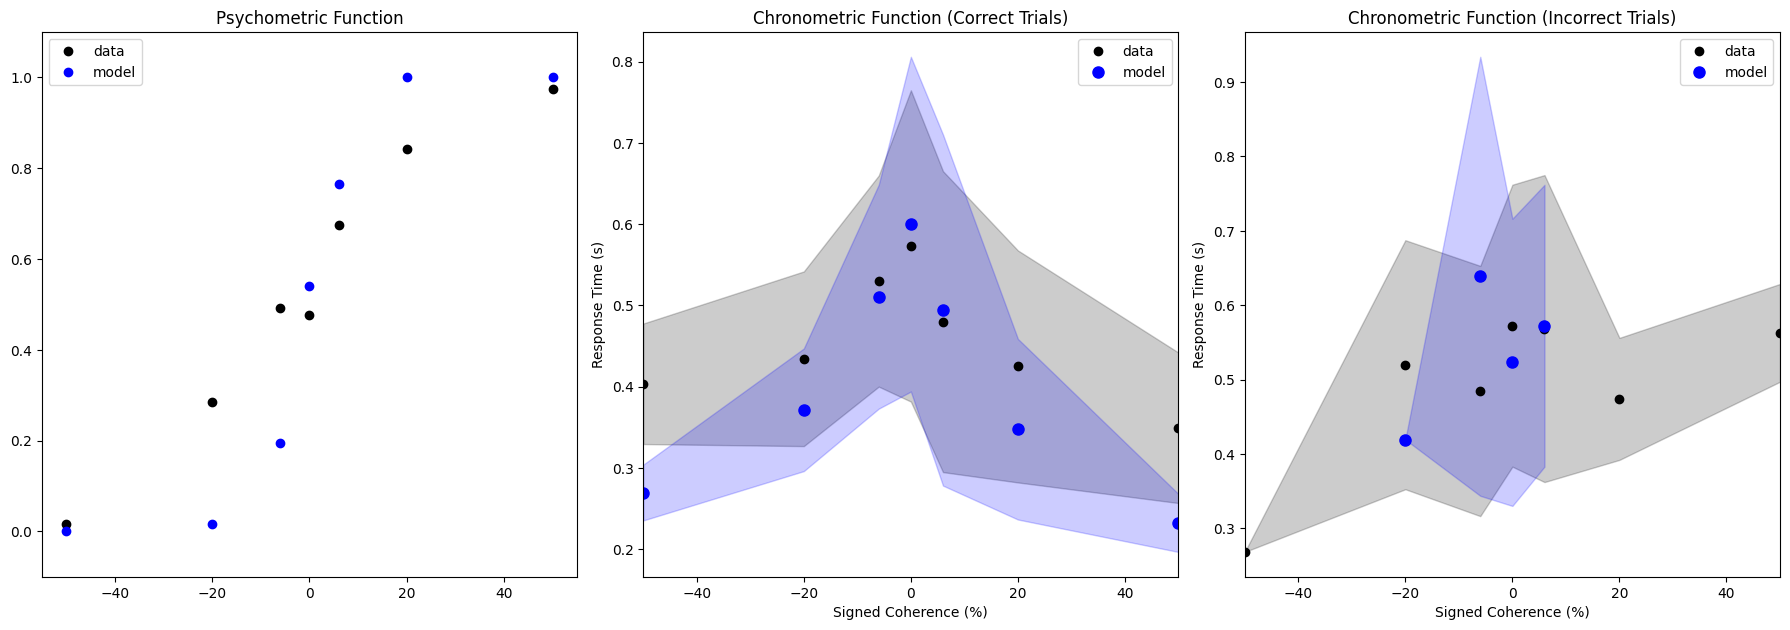

Proportion of invalid trials: 0.0

Session: 210312_GP_JP, Prior: equal)
Prior condition 'equal' in session 210312_GP_JP has 346 trials
a: 4.0093
z: 0.3852
drift_offset: 0.9214
ndt: 0.2069
drift_gain: 12.0504
variance: 1.4825
leak_rate: 0.2211
time_constant: 0.0064
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 32.92351172847312
       x: [ 4.009e+00  3.852e-01  9.214e-01  2.069e-01  1.205e+01
            1.482e+00  2.211e-01  6.417e-03]
     nit: 22
    nfev: 1849

Simulation completed. Generated 346 trials.
Valid simulated trials: 346


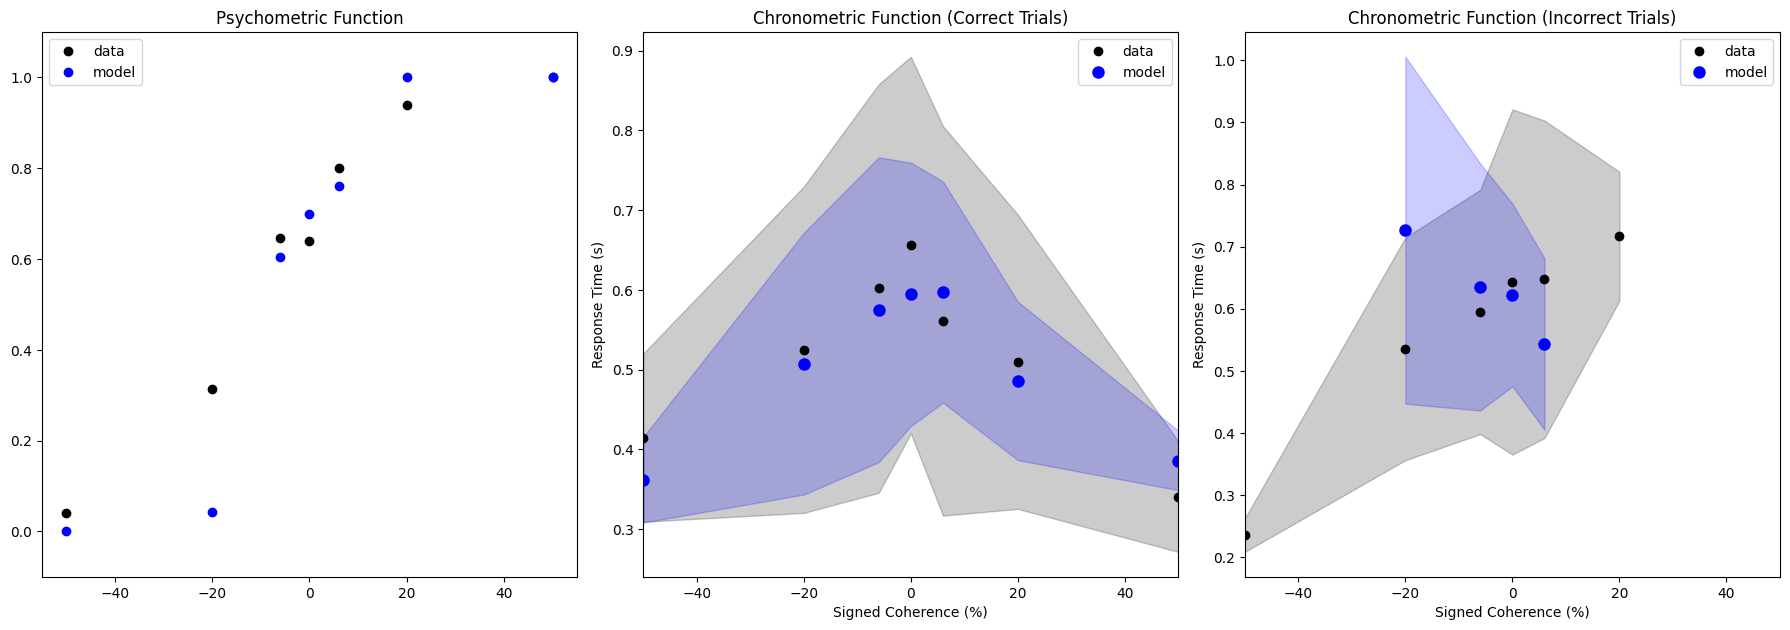

Proportion of invalid trials: 0.0

Session: 210312_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210312_GP_JP has 665 trials
a: 5.6163
z: 0.4741
drift_offset: -0.1935
ndt: 0.1304
drift_gain: 10.9424
variance: 2.4896
leak_rate: 0.5795
time_constant: 0.0055
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 65.53787833257255
       x: [ 5.616e+00  4.741e-01 -1.935e-01  1.304e-01  1.094e+01
            2.490e+00  5.795e-01  5.522e-03]
     nit: 23
    nfev: 1947
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 665 trials.
Valid simulated trials: 665


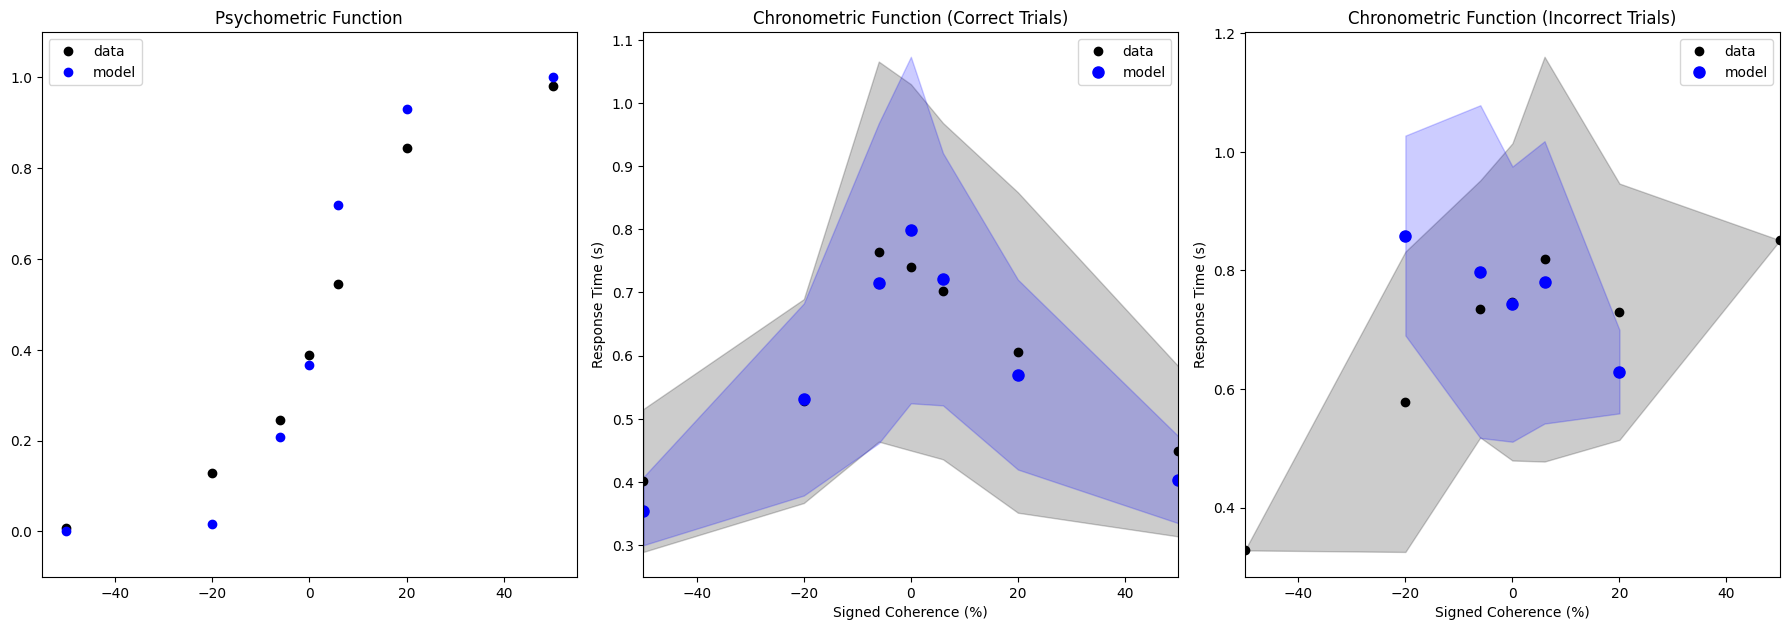

Proportion of invalid trials: 0.0

Session: 210315_GP_JP, Prior: equal)
Prior condition 'equal' in session 210315_GP_JP has 352 trials
a: 5.3053
z: 0.3340
drift_offset: -0.3271
ndt: 0.1264
drift_gain: 9.4673
variance: 2.8061
leak_rate: 0.9474
time_constant: 0.0032
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 25.194469993701336
       x: [ 5.305e+00  3.340e-01 -3.271e-01  1.264e-01  9.467e+00
            2.806e+00  9.474e-01  3.197e-03]
     nit: 35
    nfev: 3024
     jac: [ 0.000e+00  0.000e+00  0.000e+00  1.717e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 352 trials.
Valid simulated trials: 351


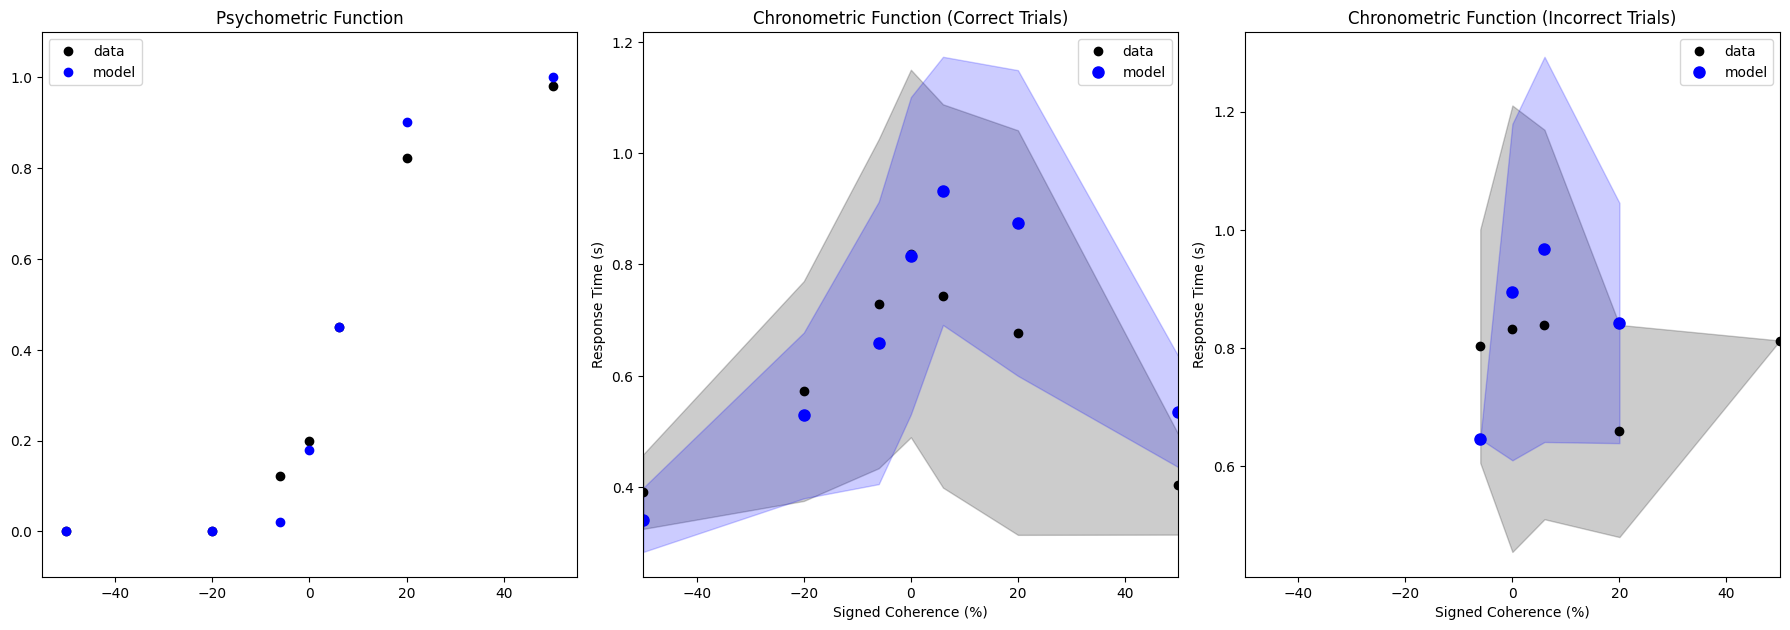

Proportion of invalid trials: 0.002840909090909091

Session: 210315_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210315_GP_JP has 805 trials
a: 5.4583
z: 0.5386
drift_offset: -0.0074
ndt: 0.1430
drift_gain: 8.9295
variance: 1.7204
leak_rate: 0.4331
time_constant: 0.0033
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 79.28748672967065
       x: [ 5.458e+00  5.386e-01 -7.356e-03  1.430e-01  8.929e+00
            1.720e+00  4.331e-01  3.282e-03]
     nit: 24
    nfev: 2189

Simulation completed. Generated 805 trials.
Valid simulated trials: 805


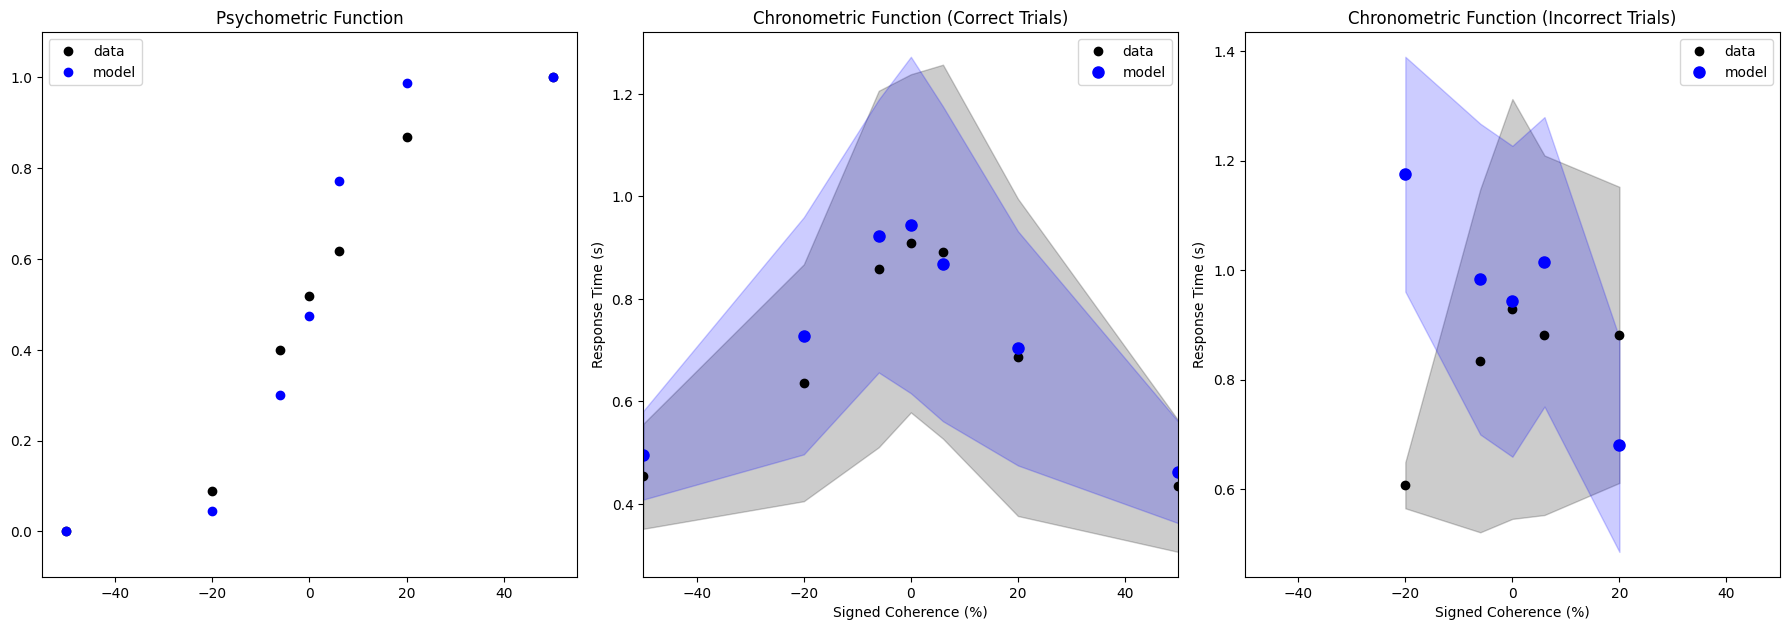

Proportion of invalid trials: 0.0

Session: 210316_GP_JP, Prior: equal)
Prior condition 'equal' in session 210316_GP_JP has 390 trials
a: 2.6435
z: 0.6091
drift_offset: -0.0153
ndt: 0.1409
drift_gain: 7.8900
variance: 2.7516
leak_rate: 0.7314
time_constant: 0.0011
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 39.58042135423845
       x: [ 2.644e+00  6.091e-01 -1.529e-02  1.409e-01  7.890e+00
            2.752e+00  7.314e-01  1.119e-03]
     nit: 30
    nfev: 2516
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 390 trials.
Valid simulated trials: 390


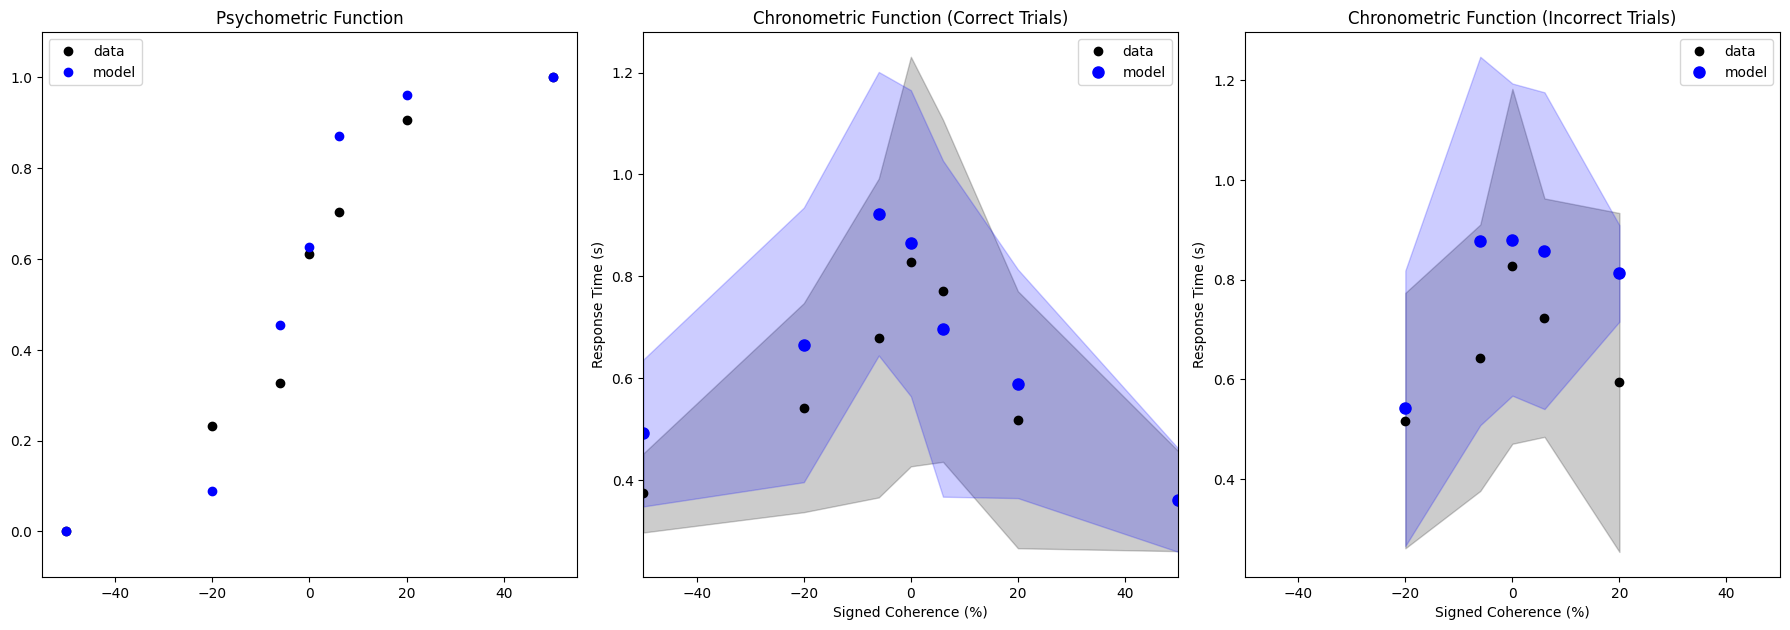

Proportion of invalid trials: 0.0

Session: 210316_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210316_GP_JP has 652 trials
a: 3.2990
z: 0.4922
drift_offset: -0.0880
ndt: 0.1383
drift_gain: 3.6678
variance: 1.6339
leak_rate: 0.1539
time_constant: 0.0014
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 61.82737711979327
       x: [ 3.299e+00  4.922e-01 -8.797e-02  1.383e-01  3.668e+00
            1.634e+00  1.539e-01  1.396e-03]
     nit: 28
    nfev: 2329

Simulation completed. Generated 652 trials.
Valid simulated trials: 652


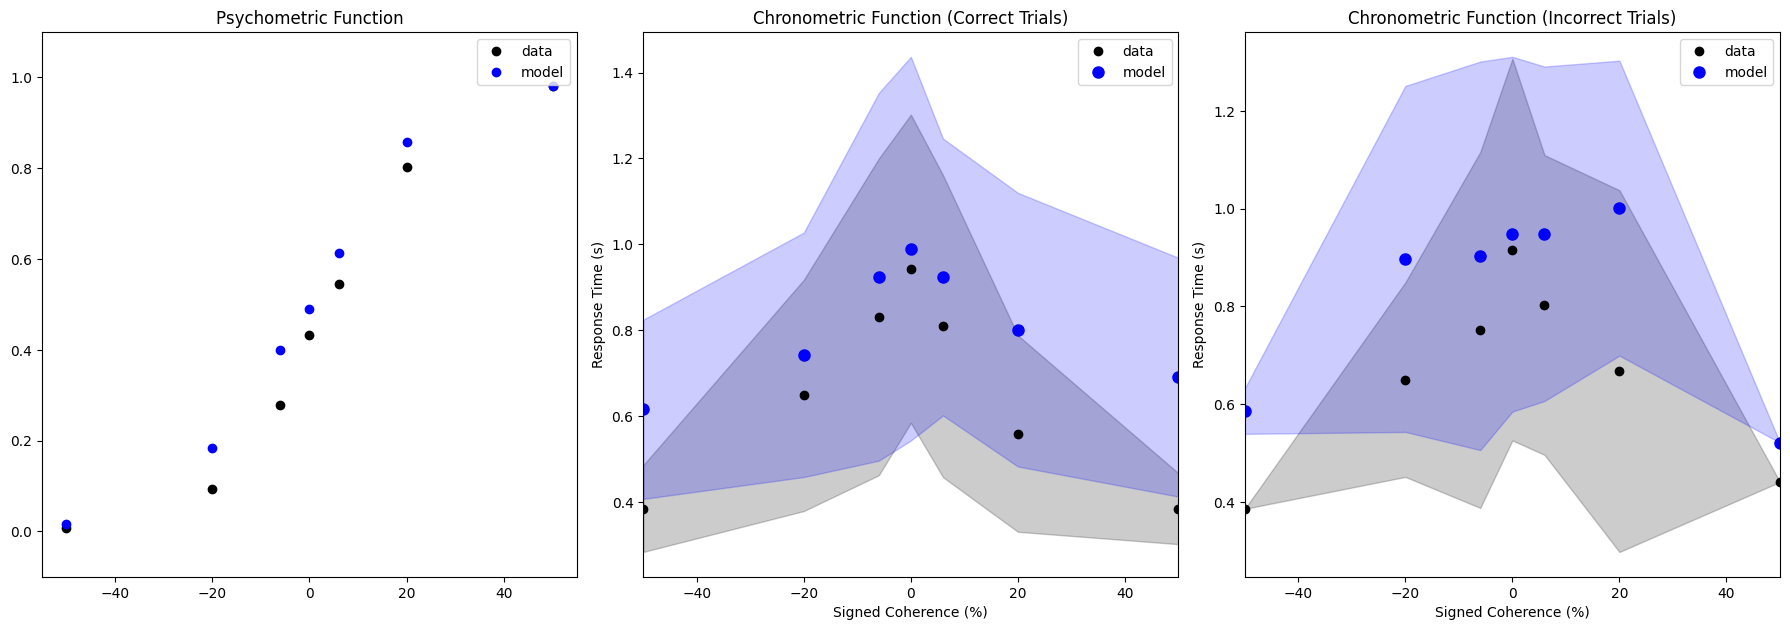

Proportion of invalid trials: 0.0

Session: 210317_GP_JP, Prior: equal)
Prior condition 'equal' in session 210317_GP_JP has 355 trials
a: 4.9389
z: 0.6024
drift_offset: -0.6002
ndt: 0.1411
drift_gain: 5.1607
variance: 1.9967
leak_rate: 0.8719
time_constant: 0.0069
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 35.00462369285723
       x: [ 4.939e+00  6.024e-01 -6.002e-01  1.411e-01  5.161e+00
            1.997e+00  8.719e-01  6.875e-03]
     nit: 19
    nfev: 1627
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 355 trials.
Valid simulated trials: 355


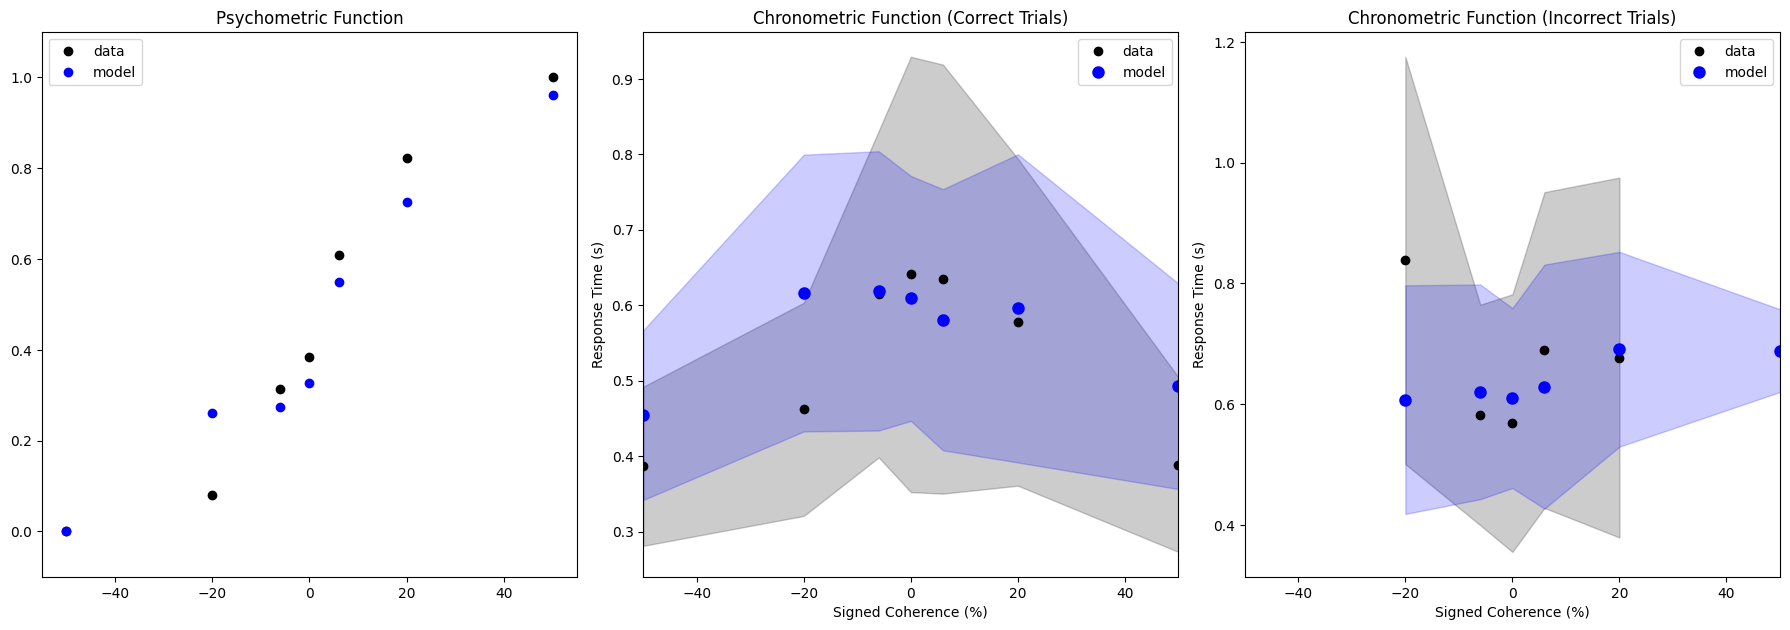

Proportion of invalid trials: 0.0

Session: 210317_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210317_GP_JP has 692 trials
a: 5.8372
z: 0.5450
drift_offset: -0.0274
ndt: 0.1000
drift_gain: 10.3762
variance: 0.3660
leak_rate: 0.2999
time_constant: 0.0046
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 63.860693961424325
       x: [ 5.837e+00  5.450e-01 -2.736e-02  1.000e-01  1.038e+01
            3.660e-01  2.999e-01  4.582e-03]
     nit: 19
    nfev: 1618
     jac: [ 0.000e+00  0.000e+00  0.000e+00  1.356e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 692 trials.
Valid simulated trials: 691


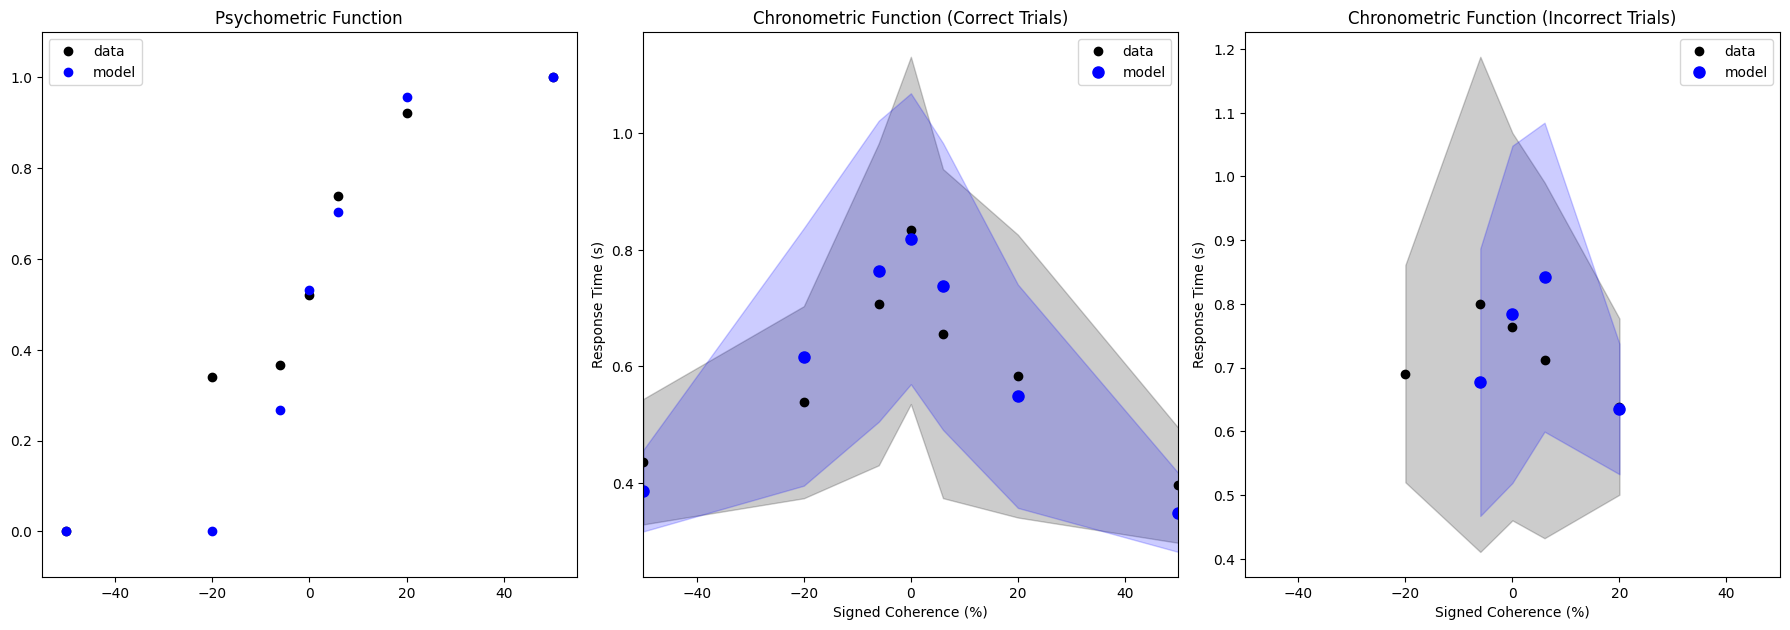

Proportion of invalid trials: 0.001445086705202312

Session: 210318_GP_JP, Prior: equal)
Prior condition 'equal' in session 210318_GP_JP has 364 trials
a: 3.5250
z: 0.4880
drift_offset: 0.1622
ndt: 0.1355
drift_gain: 9.5798
variance: 1.9113
leak_rate: 0.6491
time_constant: 0.0020
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 37.29429165173913
       x: [ 3.525e+00  4.880e-01  1.622e-01  1.355e-01  9.580e+00
            1.911e+00  6.491e-01  2.001e-03]
     nit: 33
    nfev: 2774
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 364 trials.
Valid simulated trials: 364


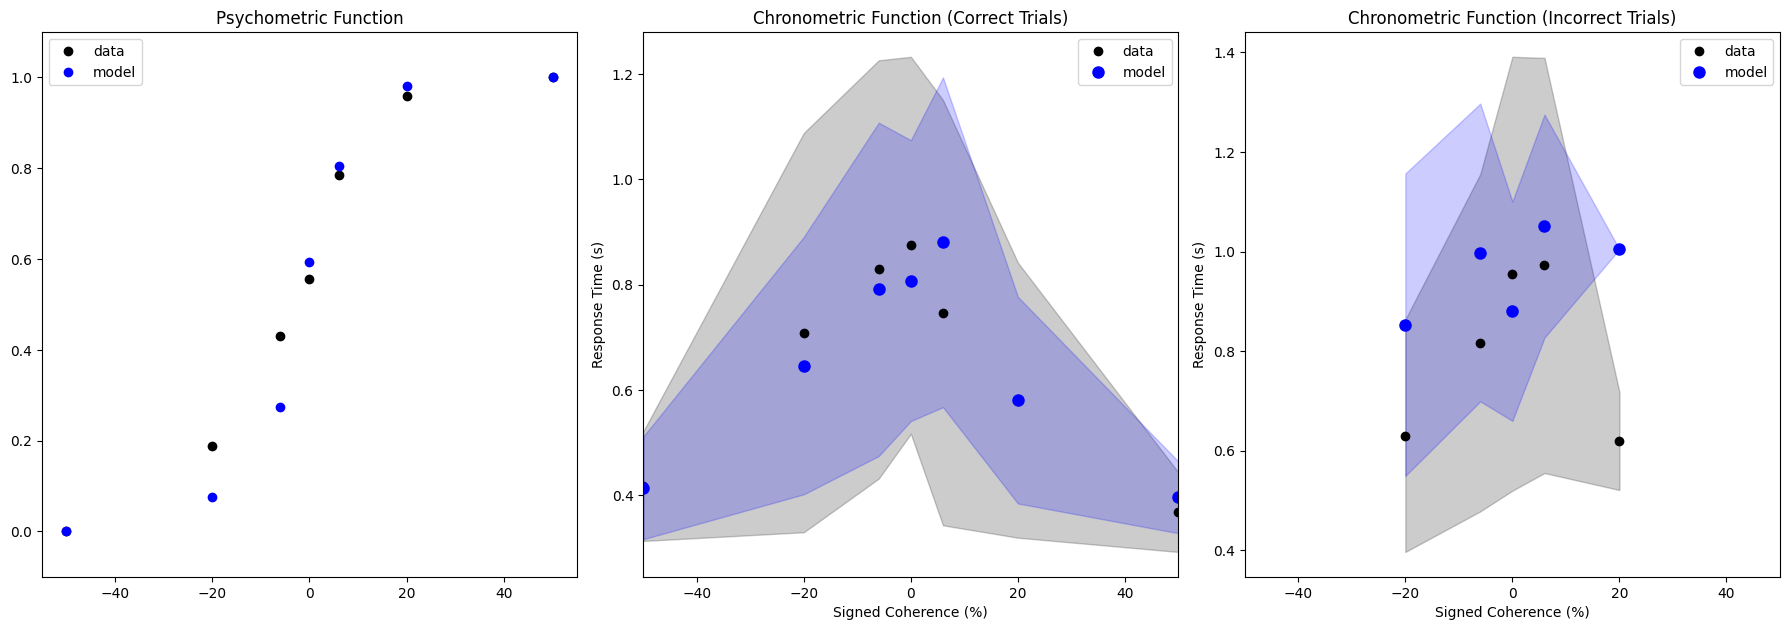

Proportion of invalid trials: 0.0

Session: 210318_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210318_GP_JP has 740 trials
a: 3.2317
z: 0.6119
drift_offset: -0.7203
ndt: 0.1079
drift_gain: 17.3486
variance: 4.1844
leak_rate: 0.6370
time_constant: 0.0016
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 65.34819171034538
       x: [ 3.232e+00  6.119e-01 -7.203e-01  1.079e-01  1.735e+01
            4.184e+00  6.370e-01  1.642e-03]
     nit: 32
    nfev: 2829

Simulation completed. Generated 740 trials.
Valid simulated trials: 740


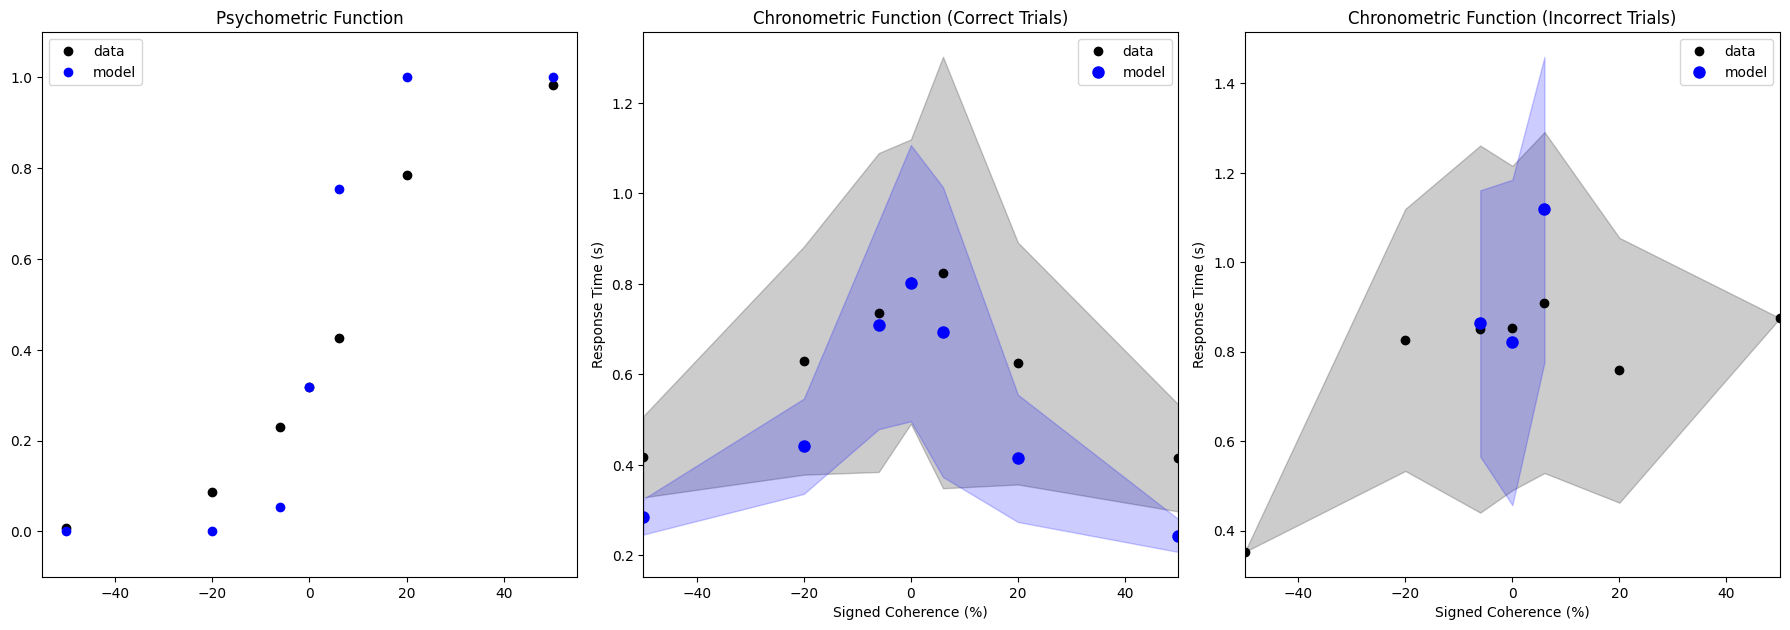

Proportion of invalid trials: 0.0

Session: 210323_GP_JP, Prior: equal)
Prior condition 'equal' in session 210323_GP_JP has 357 trials
a: 2.9379
z: 0.5036
drift_offset: -0.1206
ndt: 0.1817
drift_gain: 10.6801
variance: 0.3985
leak_rate: 0.8510
time_constant: 0.0019
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 34.689290289311174
       x: [ 2.938e+00  5.036e-01 -1.206e-01  1.817e-01  1.068e+01
            3.985e-01  8.510e-01  1.943e-03]
     nit: 31
    nfev: 2695
     jac: [ 0.000e+00  0.000e+00  0.000e+00  3.986e-01  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 357 trials.
Valid simulated trials: 357


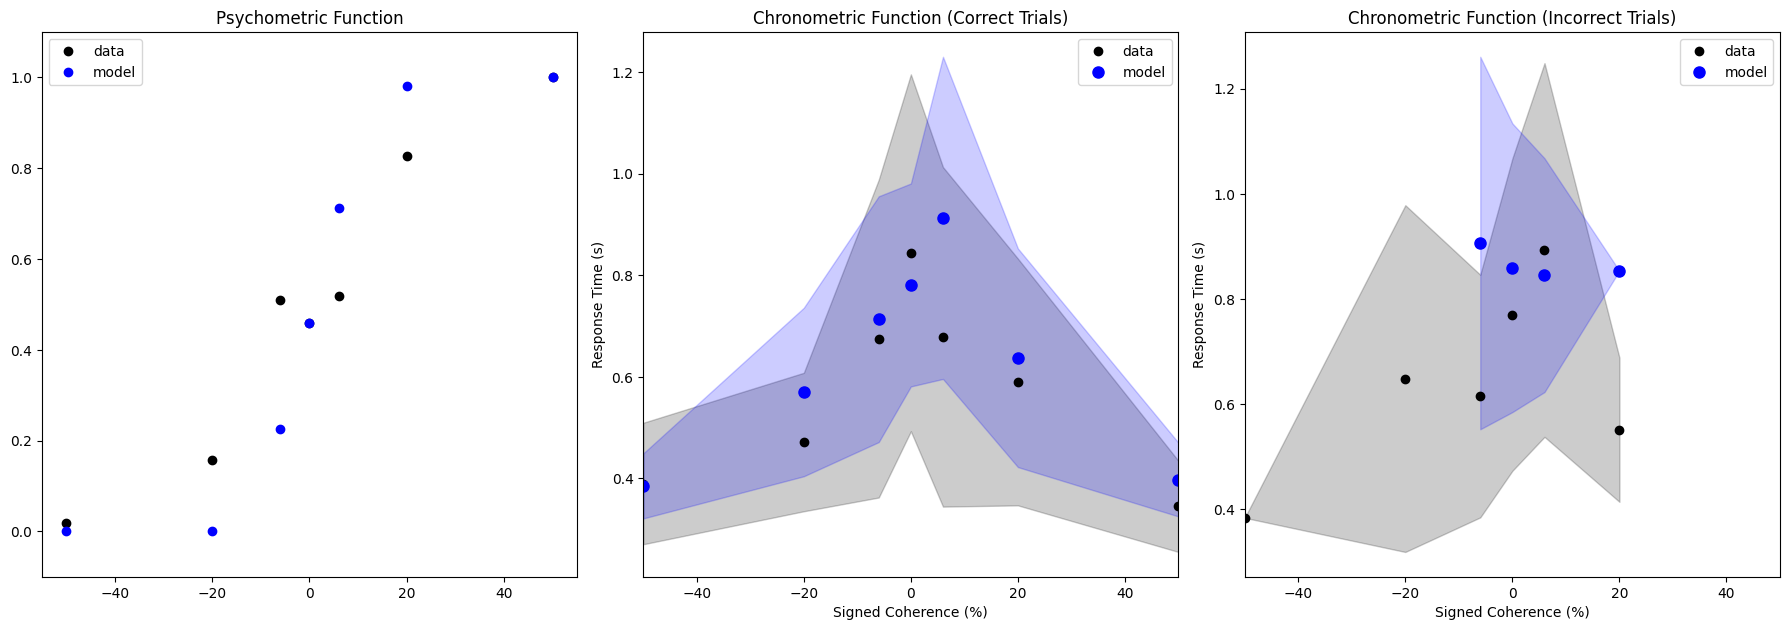

Proportion of invalid trials: 0.0

Session: 210323_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210323_GP_JP has 695 trials
a: 2.7029
z: 0.4805
drift_offset: -0.4678
ndt: 0.1349
drift_gain: 12.7828
variance: 0.1671
leak_rate: 0.7664
time_constant: 0.0013
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 61.70880885805268
       x: [ 2.703e+00  4.805e-01 -4.678e-01  1.349e-01  1.278e+01
            1.671e-01  7.664e-01  1.283e-03]
     nit: 24
    nfev: 2009

Simulation completed. Generated 695 trials.
Valid simulated trials: 694


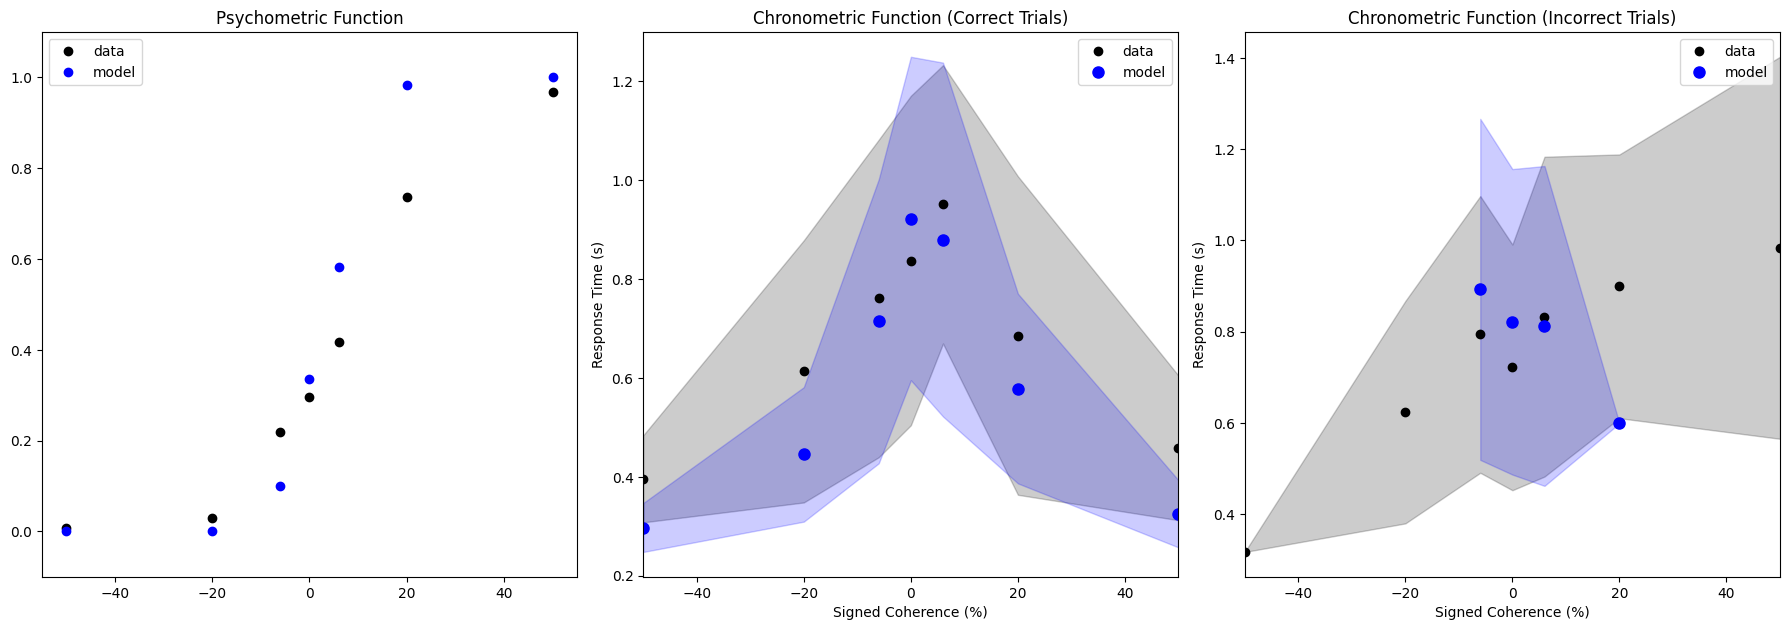

Proportion of invalid trials: 0.0014388489208633094

Session: 210413_GP_JP, Prior: equal)
Prior condition 'equal' in session 210413_GP_JP has 350 trials
a: 2.9218
z: 0.3255
drift_offset: 0.6294
ndt: 0.1920
drift_gain: 9.3799
variance: 1.5681
leak_rate: 0.6224
time_constant: 0.0018
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 33.76753554746
       x: [ 2.922e+00  3.255e-01  6.294e-01  1.920e-01  9.380e+00
            1.568e+00  6.224e-01  1.768e-03]
     nit: 25
    nfev: 2476

Simulation completed. Generated 350 trials.
Valid simulated trials: 350


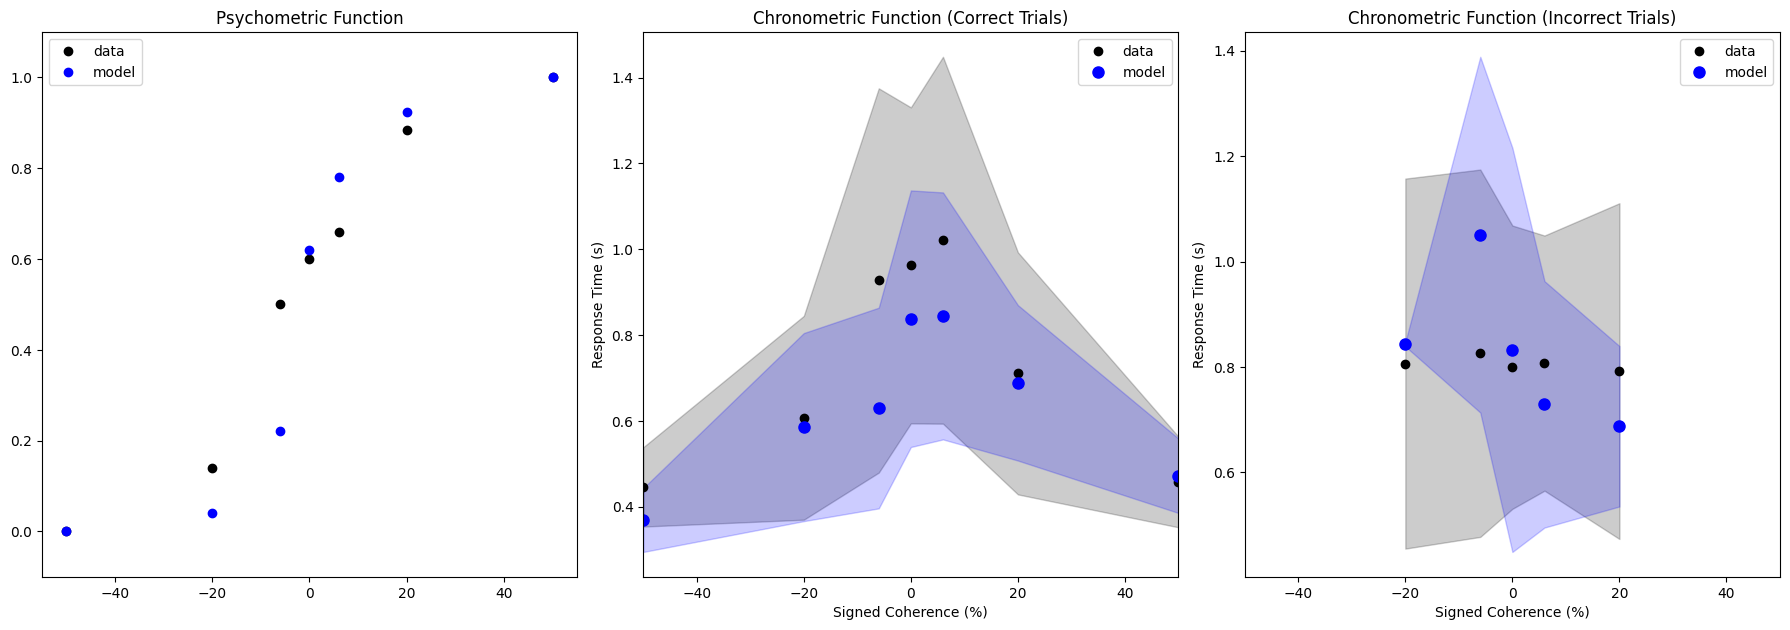

Proportion of invalid trials: 0.0

Session: 210413_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210413_GP_JP has 704 trials
a: 2.7648
z: 0.4290
drift_offset: -0.0370
ndt: 0.2279
drift_gain: 15.4001
variance: 3.1698
leak_rate: 0.1468
time_constant: 0.0014
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 69.05062810025538
       x: [ 2.765e+00  4.290e-01 -3.700e-02  2.279e-01  1.540e+01
            3.170e+00  1.468e-01  1.401e-03]
     nit: 29
    nfev: 2508
     jac: [ 0.000e+00  0.000e+00  0.000e+00  6.050e-02  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 704 trials.
Valid simulated trials: 704


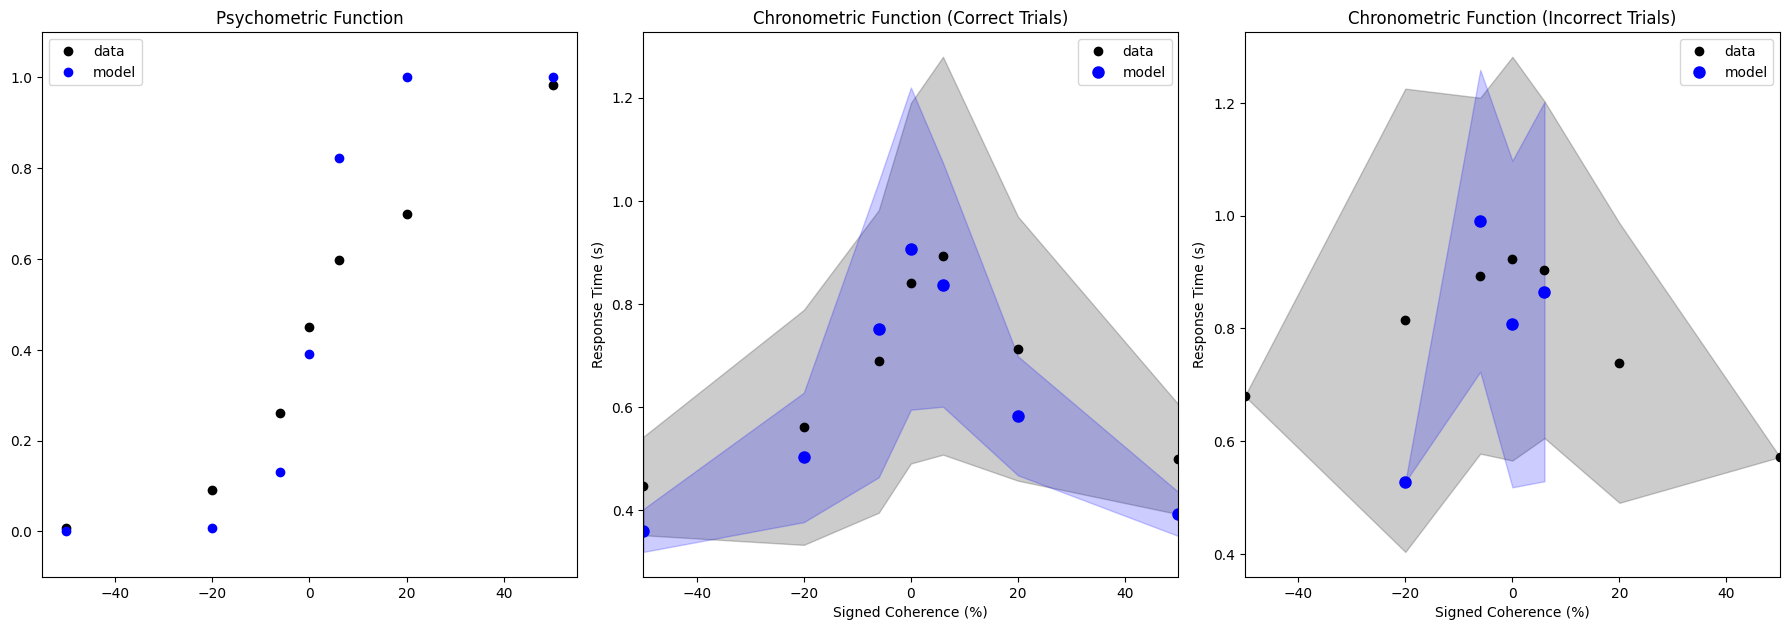

Proportion of invalid trials: 0.0

Session: 210524_GP_JP, Prior: equal)
Prior condition 'equal' in session 210524_GP_JP has 369 trials
a: 3.8284
z: 0.4340
drift_offset: -0.1314
ndt: 0.1584
drift_gain: 7.3021
variance: 0.7937
leak_rate: 0.6160
time_constant: 0.0017
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 36.35830706030315
       x: [ 3.828e+00  4.340e-01 -1.314e-01  1.584e-01  7.302e+00
            7.937e-01  6.160e-01  1.714e-03]
     nit: 37
    nfev: 3229

Simulation completed. Generated 369 trials.
Valid simulated trials: 369


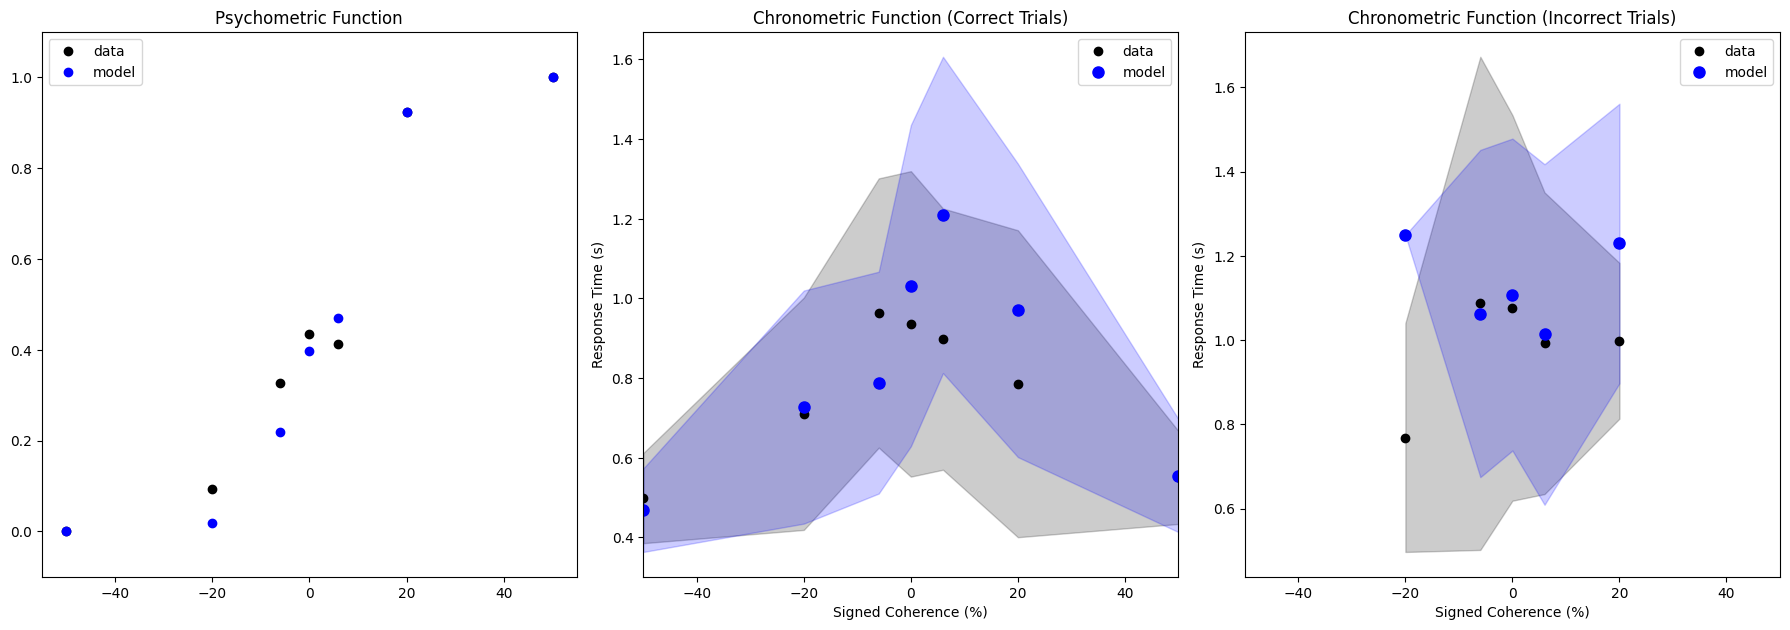

Proportion of invalid trials: 0.0

Session: 210524_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210524_GP_JP has 617 trials
a: 3.3153
z: 0.4954
drift_offset: 0.6390
ndt: 0.1213
drift_gain: 12.7889
variance: 2.8679
leak_rate: 0.5619
time_constant: 0.0011
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 46.1076685761898
       x: [ 3.315e+00  4.954e-01  6.390e-01  1.213e-01  1.279e+01
            2.868e+00  5.619e-01  1.128e-03]
     nit: 32
    nfev: 2829

Simulation completed. Generated 617 trials.
Valid simulated trials: 616


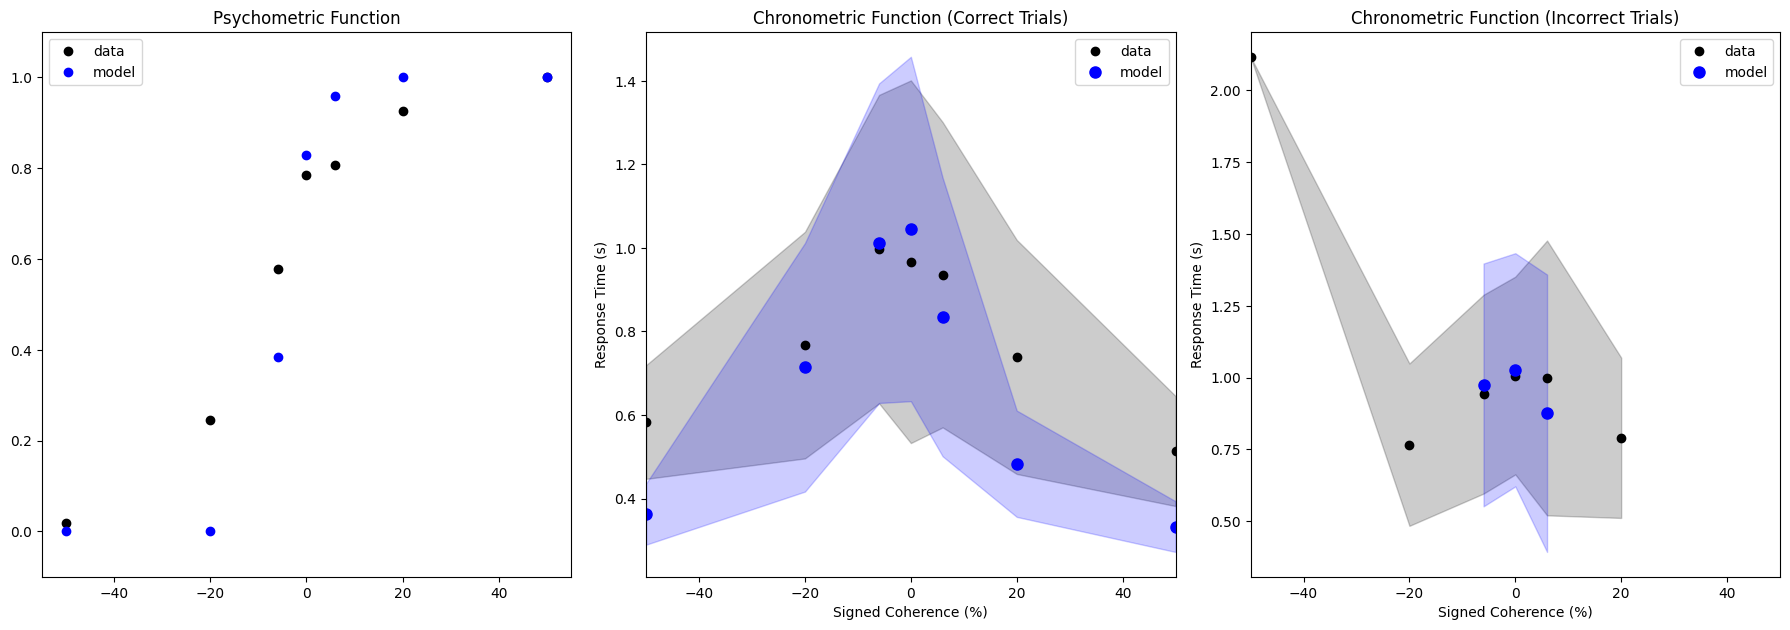

Proportion of invalid trials: 0.0016207455429497568

Session: 210525_GP_JP, Prior: equal)
Prior condition 'equal' in session 210525_GP_JP has 387 trials
a: 2.4208
z: 0.4504
drift_offset: 0.4620
ndt: 0.2809
drift_gain: 13.8787
variance: 0.3252
leak_rate: 0.0078
time_constant: 0.0010
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 35.39350187816522
       x: [ 2.421e+00  4.504e-01  4.620e-01  2.809e-01  1.388e+01
            3.252e-01  7.792e-03  1.015e-03]
     nit: 32
    nfev: 2649

Simulation completed. Generated 387 trials.
Valid simulated trials: 387


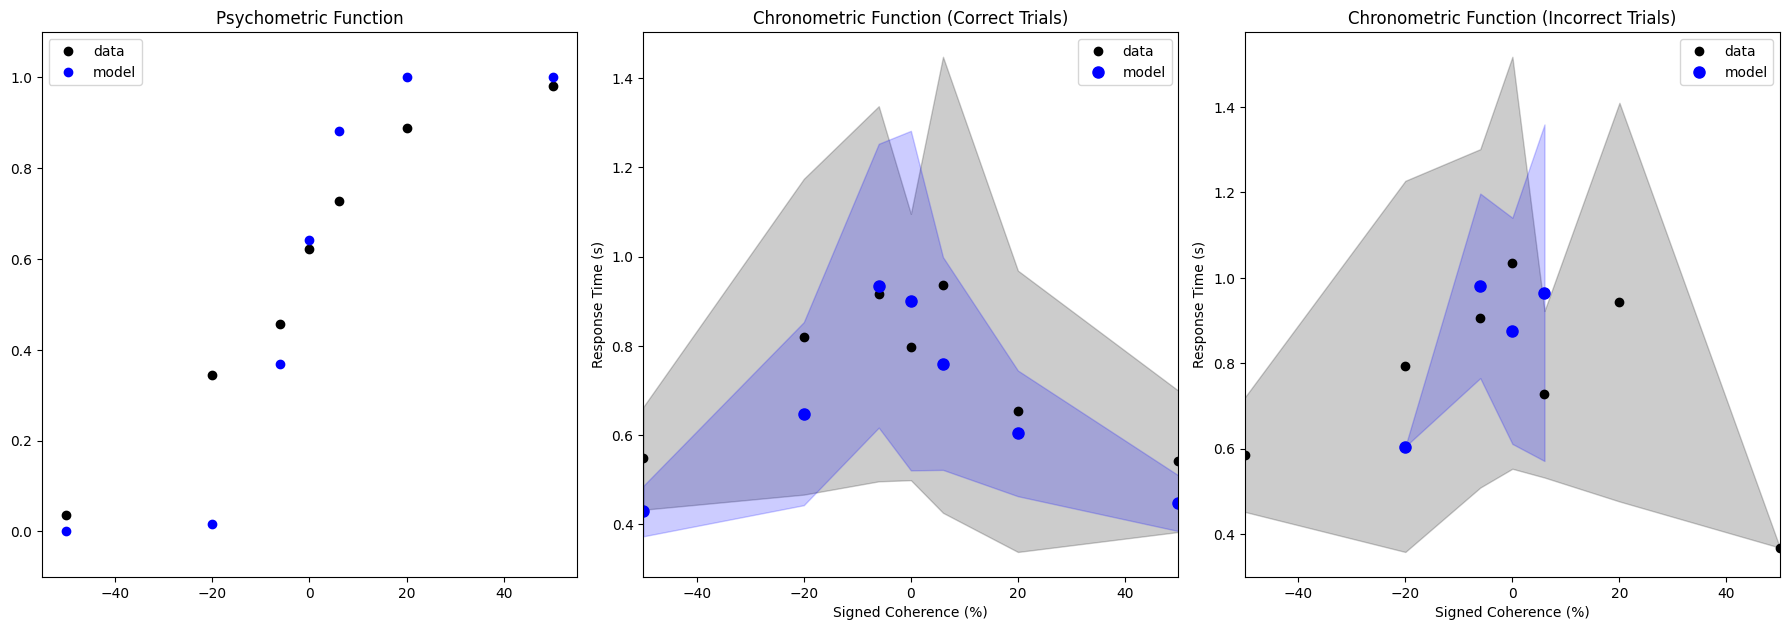

Proportion of invalid trials: 0.0

Session: 210525_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210525_GP_JP has 672 trials
a: 3.3685
z: 0.3810
drift_offset: -0.0895
ndt: 0.1585
drift_gain: 11.1749
variance: 0.8597
leak_rate: 0.4424
time_constant: 0.0016
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 64.79240462121952
       x: [ 3.368e+00  3.810e-01 -8.946e-02  1.585e-01  1.117e+01
            8.597e-01  4.424e-01  1.578e-03]
     nit: 29
    nfev: 2796

Simulation completed. Generated 672 trials.
Valid simulated trials: 672


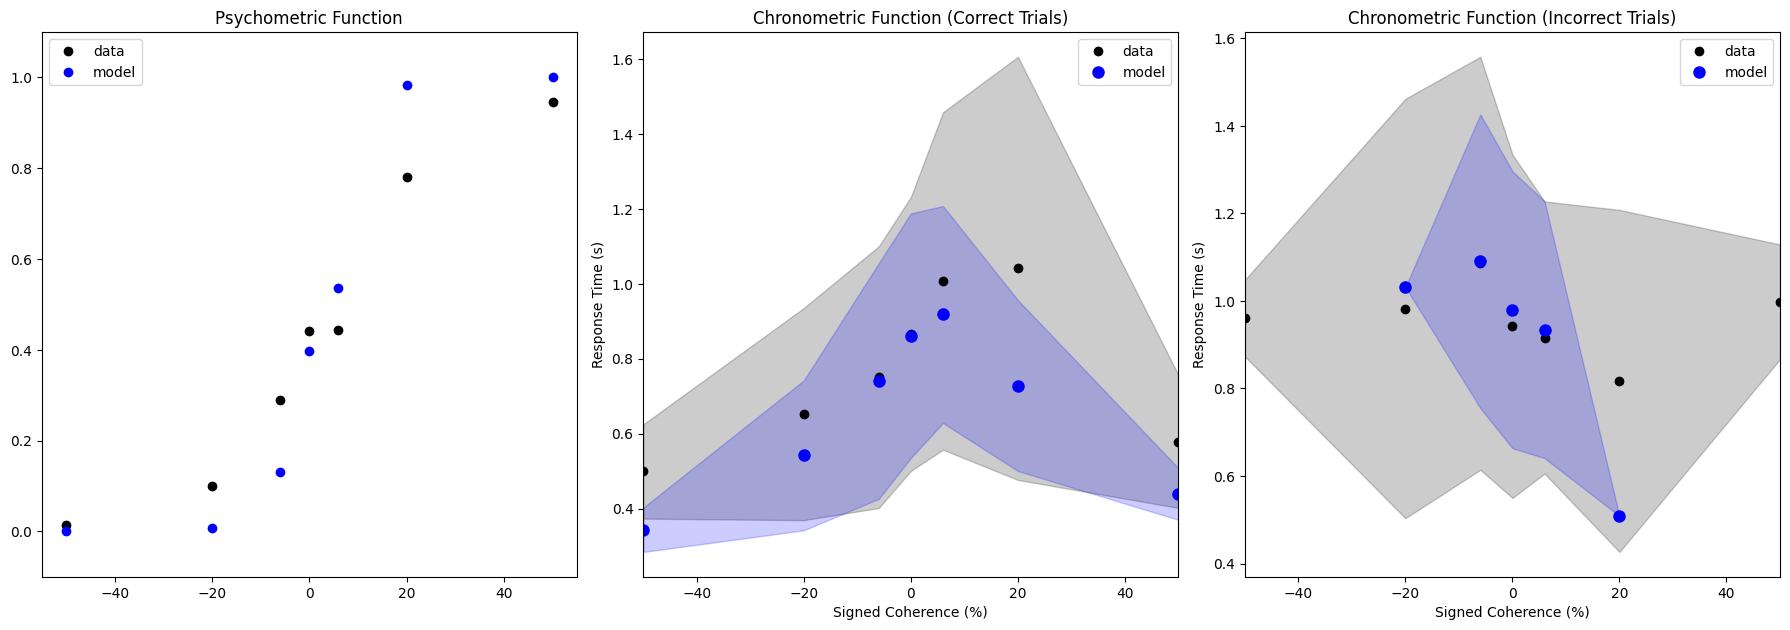

Proportion of invalid trials: 0.0

Session: 210528_GP_JP, Prior: equal)
Prior condition 'equal' in session 210528_GP_JP has 353 trials
a: 2.6872
z: 0.4796
drift_offset: 0.3805
ndt: 0.1301
drift_gain: 6.0422
variance: 1.5922
leak_rate: 0.1128
time_constant: 0.0012
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 32.57743608919345
       x: [ 2.687e+00  4.796e-01  3.805e-01  1.301e-01  6.042e+00
            1.592e+00  1.128e-01  1.213e-03]
     nit: 42
    nfev: 3449

Simulation completed. Generated 353 trials.
Valid simulated trials: 353


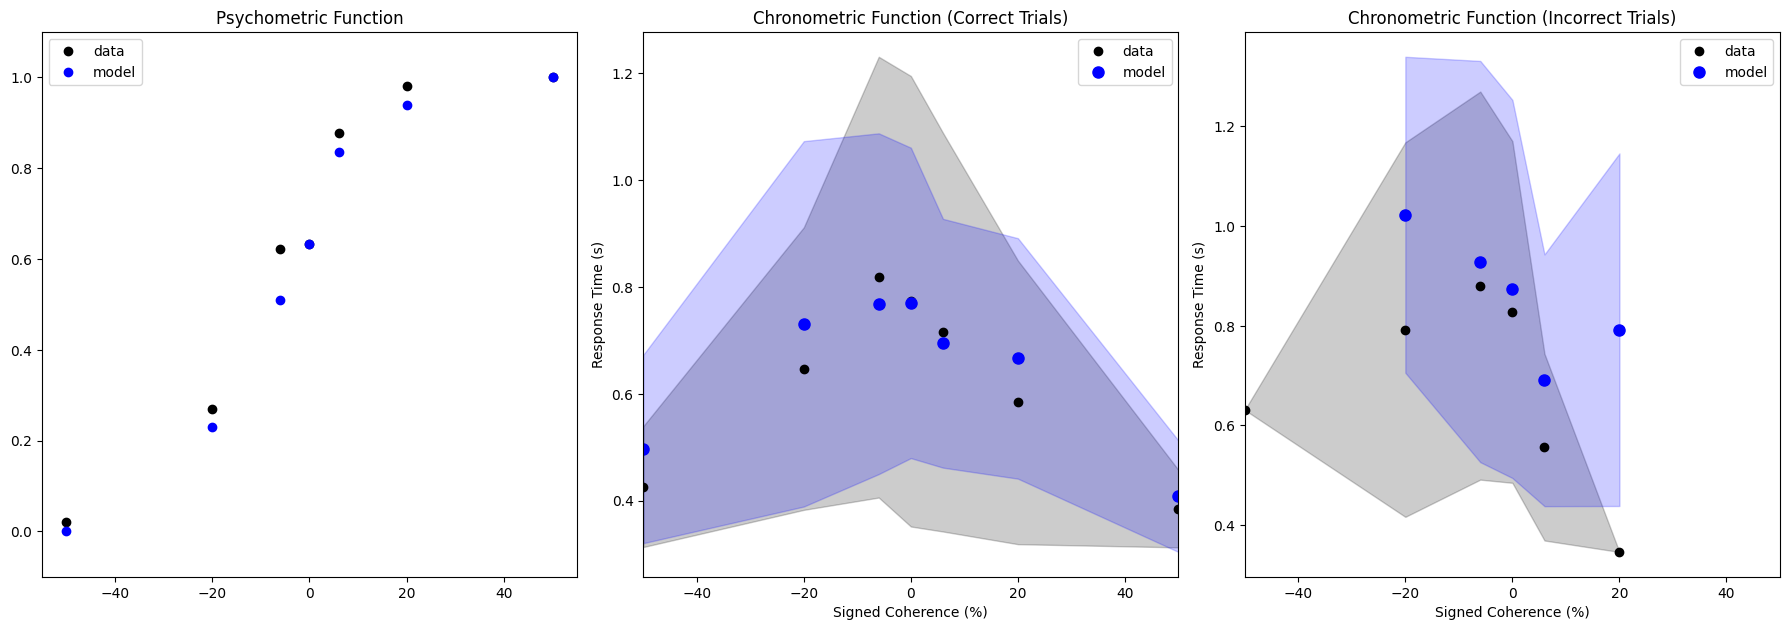

Proportion of invalid trials: 0.0

Session: 210528_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210528_GP_JP has 744 trials
a: 3.8364
z: 0.4525
drift_offset: -0.1625
ndt: 0.1000
drift_gain: 5.0319
variance: 1.9818
leak_rate: 0.1978
time_constant: 0.0015
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 74.09603433342869
       x: [ 3.836e+00  4.525e-01 -1.625e-01  1.000e-01  5.032e+00
            1.982e+00  1.978e-01  1.468e-03]
     nit: 29
    nfev: 2517
     jac: [ 0.000e+00  0.000e+00  0.000e+00  9.317e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 744 trials.
Valid simulated trials: 744


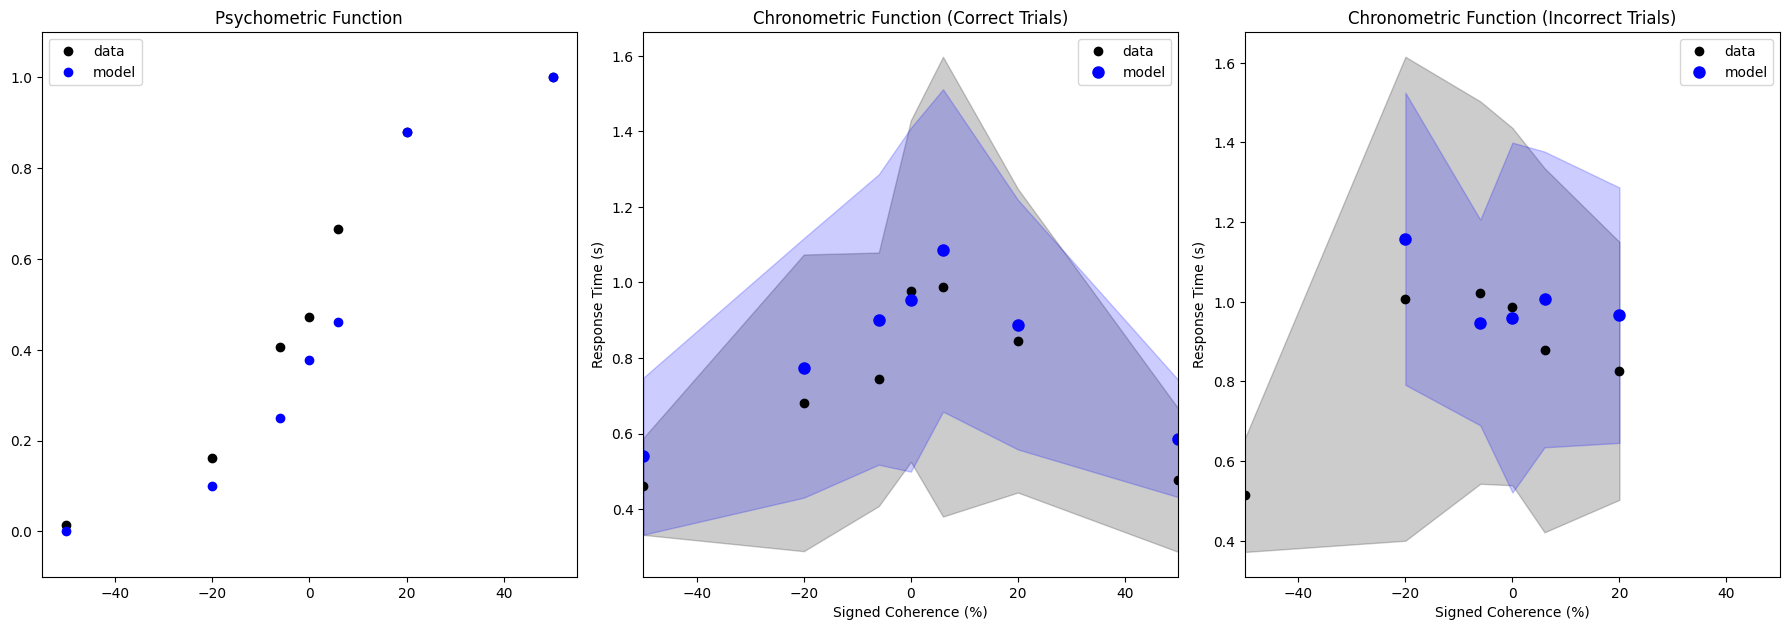

Proportion of invalid trials: 0.0

Session: 210601_GP_JP, Prior: equal)
Prior condition 'equal' in session 210601_GP_JP has 333 trials
a: 2.5927
z: 0.2801
drift_offset: 0.4857
ndt: 0.1000
drift_gain: 13.3257
variance: 2.8806
leak_rate: 0.7249
time_constant: 0.0013
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 33.792657856250884
       x: [ 2.593e+00  2.801e-01  4.857e-01  1.000e-01  1.333e+01
            2.881e+00  7.249e-01  1.305e-03]
     nit: 43
    nfev: 3628
     jac: [ 0.000e+00  0.000e+00  0.000e+00  2.785e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 333 trials.
Valid simulated trials: 333


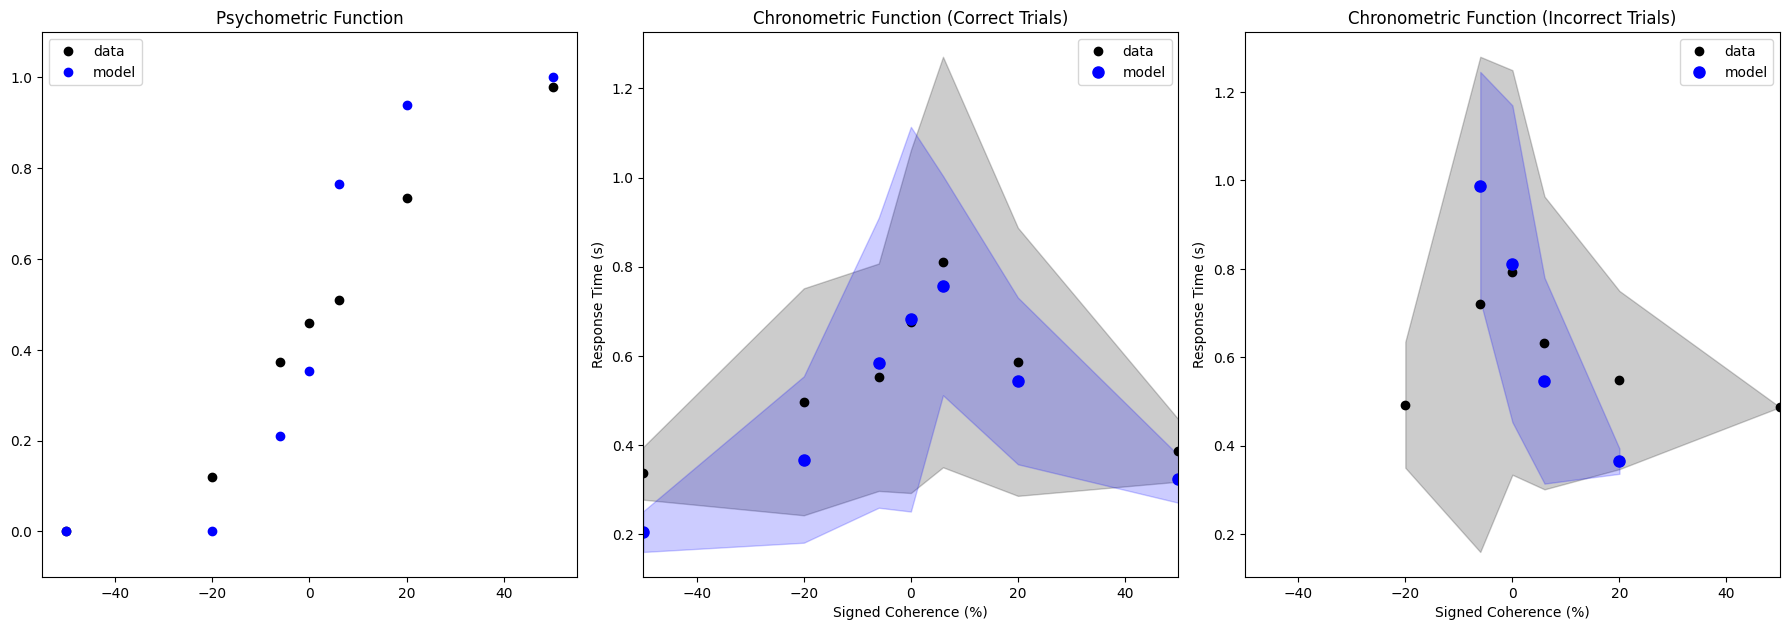

Proportion of invalid trials: 0.0

Session: 210601_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210601_GP_JP has 895 trials
a: 2.5567
z: 0.3624
drift_offset: 0.3259
ndt: 0.1000
drift_gain: 11.7545
variance: 4.1098
leak_rate: 0.8303
time_constant: 0.0015
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 88.0700155317444
       x: [ 2.557e+00  3.624e-01  3.259e-01  1.000e-01  1.175e+01
            4.110e+00  8.303e-01  1.479e-03]
     nit: 36
    nfev: 2978
     jac: [ 0.000e+00  0.000e+00  0.000e+00  5.970e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 895 trials.
Valid simulated trials: 895


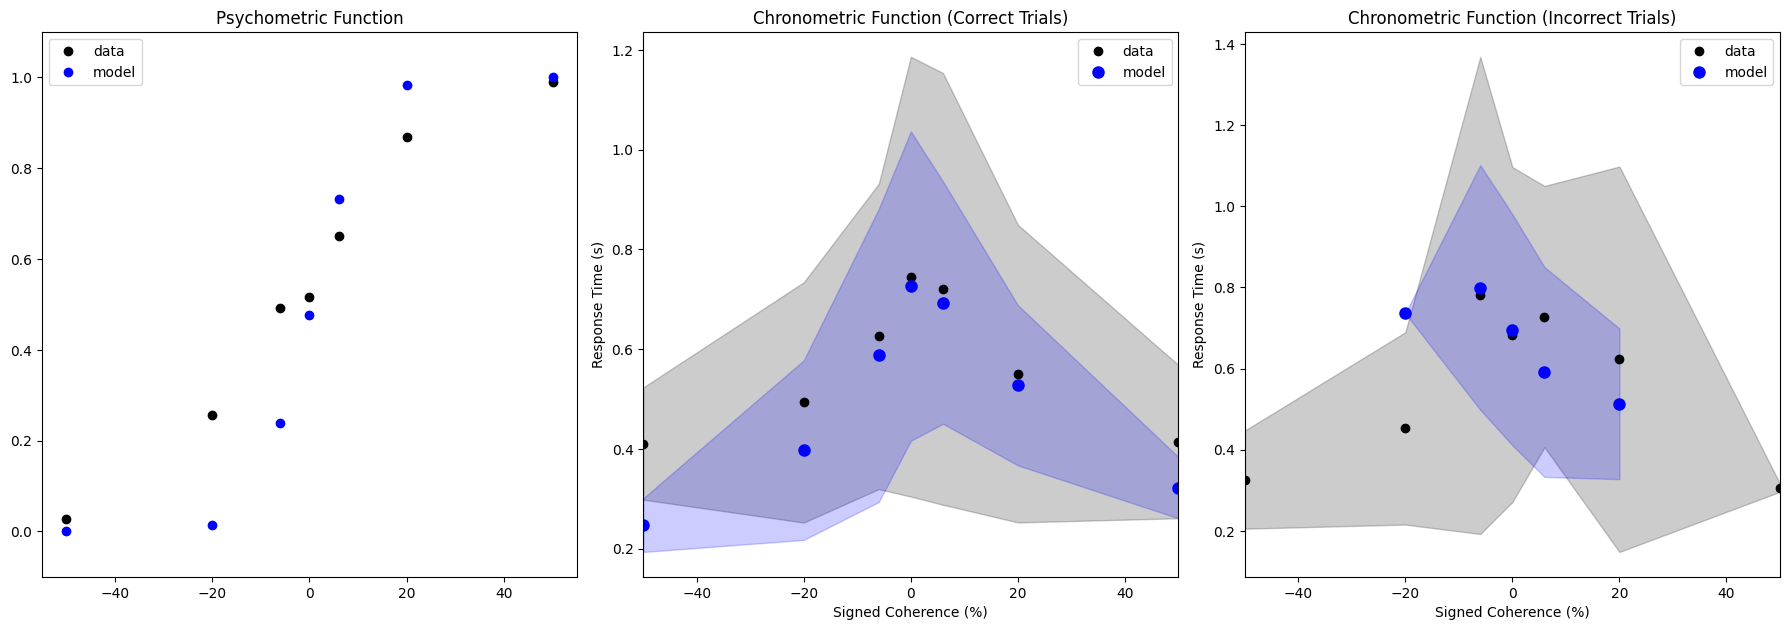

Proportion of invalid trials: 0.0

Session: 210602_GP_JP, Prior: equal)
Prior condition 'equal' in session 210602_GP_JP has 441 trials
a: 2.4794
z: 0.5180
drift_offset: 0.1218
ndt: 0.1397
drift_gain: 2.8786
variance: 2.6402
leak_rate: 0.6022
time_constant: 0.0016
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 43.68852760752843
       x: [ 2.479e+00  5.180e-01  1.218e-01  1.397e-01  2.879e+00
            2.640e+00  6.022e-01  1.645e-03]
     nit: 34
    nfev: 2809

Simulation completed. Generated 441 trials.
Valid simulated trials: 440


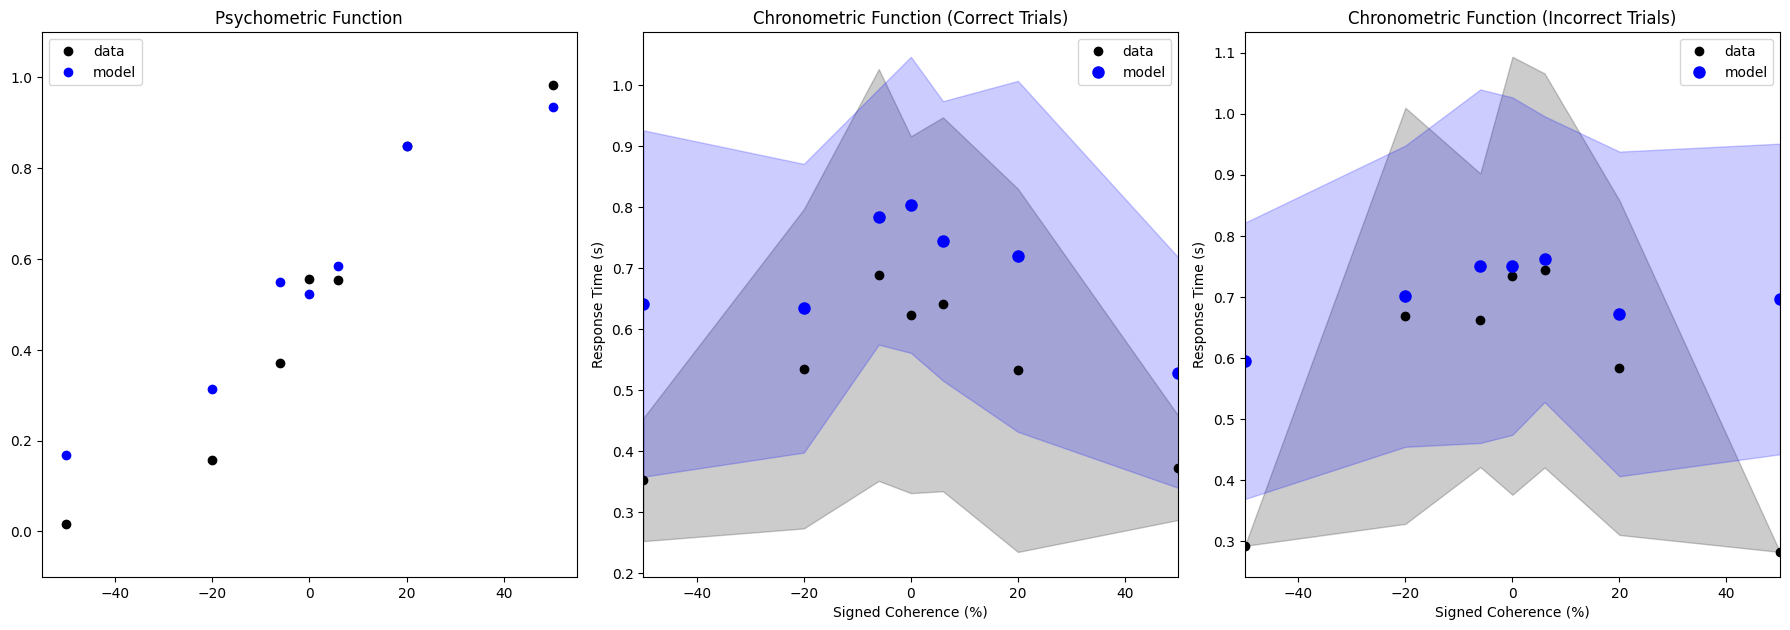

Proportion of invalid trials: 0.0022675736961451248

Session: 210602_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210602_GP_JP has 694 trials
a: 2.1350
z: 0.5770
drift_offset: 0.0394
ndt: 0.1081
drift_gain: 14.6261
variance: 2.2458
leak_rate: 0.5509
time_constant: 0.0011
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 66.71382075398161
       x: [ 2.135e+00  5.770e-01  3.936e-02  1.081e-01  1.463e+01
            2.246e+00  5.509e-01  1.056e-03]
     nit: 33
    nfev: 2819
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -1.471e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 694 trials.
Valid simulated trials: 694


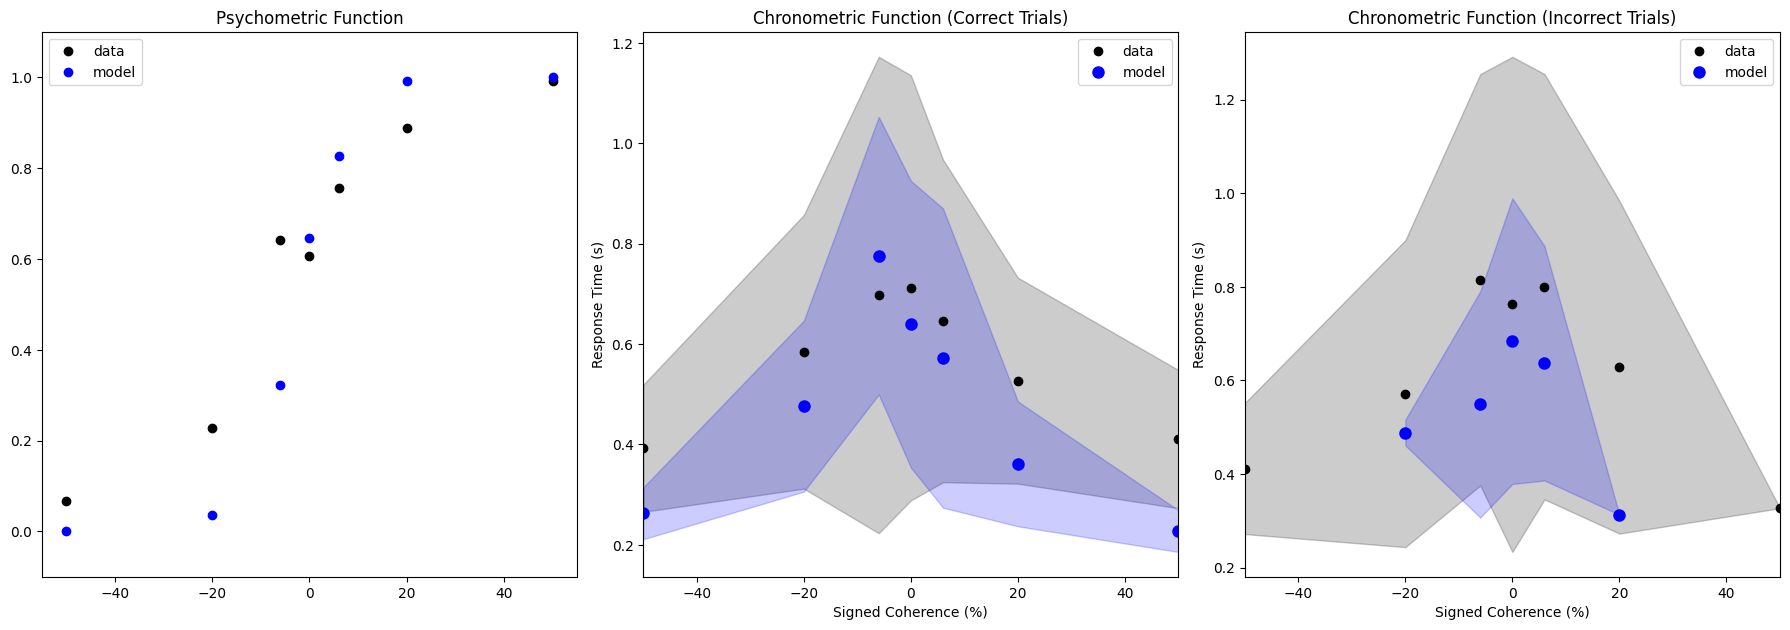

Proportion of invalid trials: 0.0

Session: 210603_GP_JP, Prior: equal)
Prior condition 'equal' in session 210603_GP_JP has 353 trials
a: 2.1419
z: 0.3053
drift_offset: 0.3579
ndt: 0.1000
drift_gain: 7.2540
variance: 4.7112
leak_rate: 0.7032
time_constant: 0.0013
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 35.35643541311923
       x: [ 2.142e+00  3.053e-01  3.579e-01  1.000e-01  7.254e+00
            4.711e+00  7.032e-01  1.288e-03]
     nit: 40
    nfev: 3298
     jac: [ 0.000e+00  0.000e+00  0.000e+00  1.101e-01  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 353 trials.
Valid simulated trials: 353


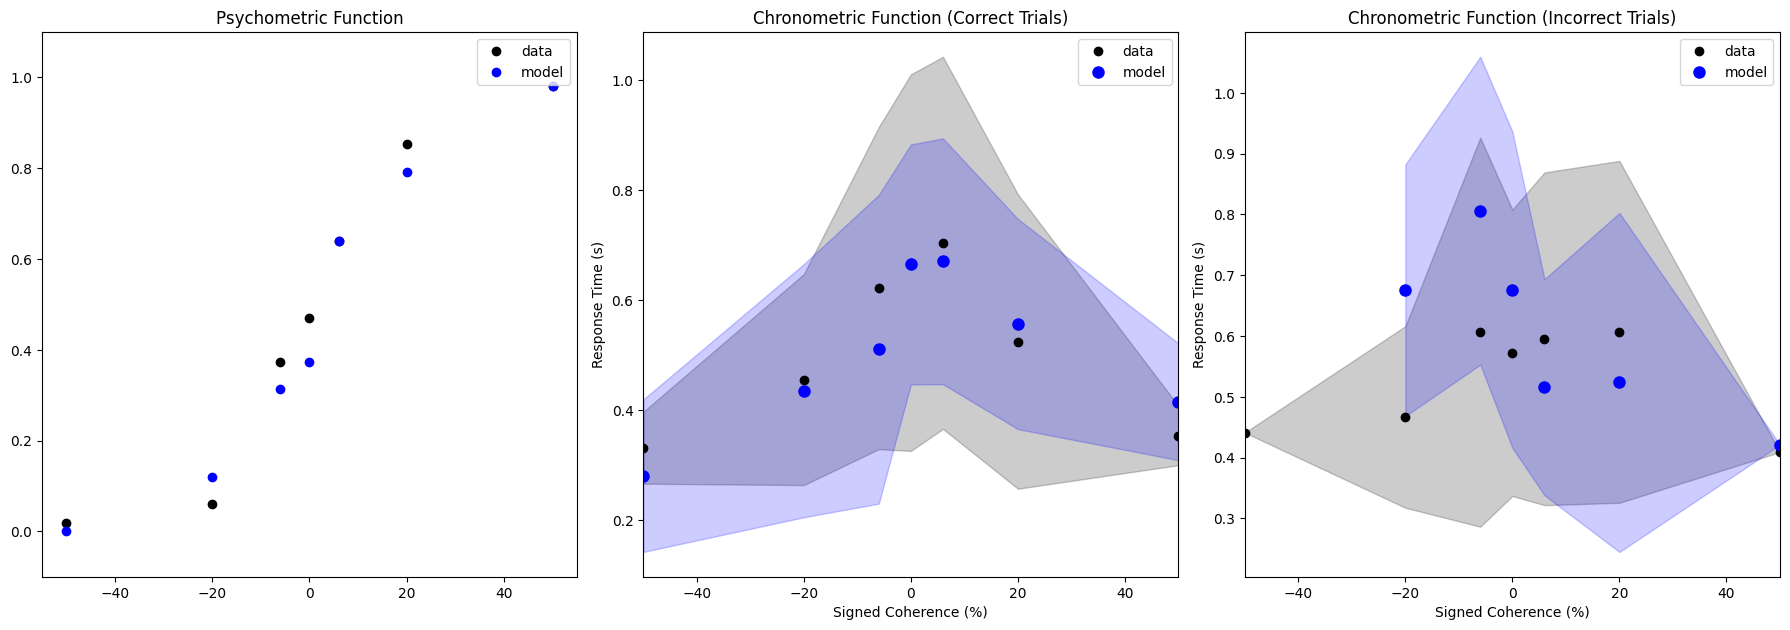

Proportion of invalid trials: 0.0

Session: 210603_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210603_GP_JP has 900 trials
a: 2.7360
z: 0.5109
drift_offset: 0.4270
ndt: 0.1150
drift_gain: 13.0886
variance: 0.6193
leak_rate: 0.4155
time_constant: 0.0015
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 80.98397866086606
       x: [ 2.736e+00  5.109e-01  4.270e-01  1.150e-01  1.309e+01
            6.193e-01  4.155e-01  1.470e-03]
     nit: 36
    nfev: 3014
     jac: [ 0.000e+00  0.000e+00  0.000e+00  4.537e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 900 trials.
Valid simulated trials: 900


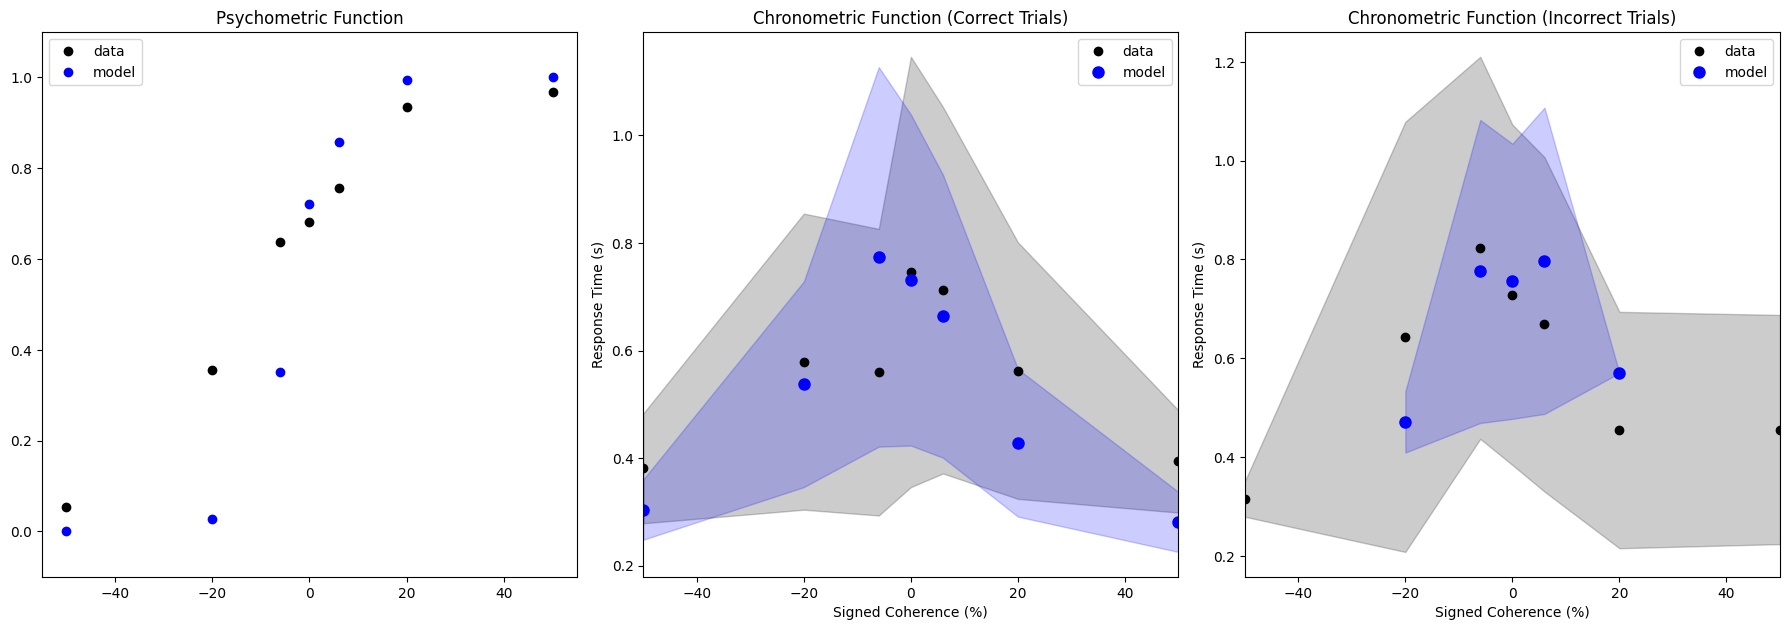

Proportion of invalid trials: 0.0

Session: 210608_GP_JP, Prior: equal)
Prior condition 'equal' in session 210608_GP_JP has 490 trials
a: 3.0252
z: 0.4111
drift_offset: 1.4181
ndt: 0.1305
drift_gain: 10.8248
variance: 3.4817
leak_rate: 0.7619
time_constant: 0.0012
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 22.910787389978854
       x: [ 3.025e+00  4.111e-01  1.418e+00  1.305e-01  1.082e+01
            3.482e+00  7.619e-01  1.246e-03]
     nit: 39
    nfev: 3389

Simulation completed. Generated 490 trials.
Valid simulated trials: 490


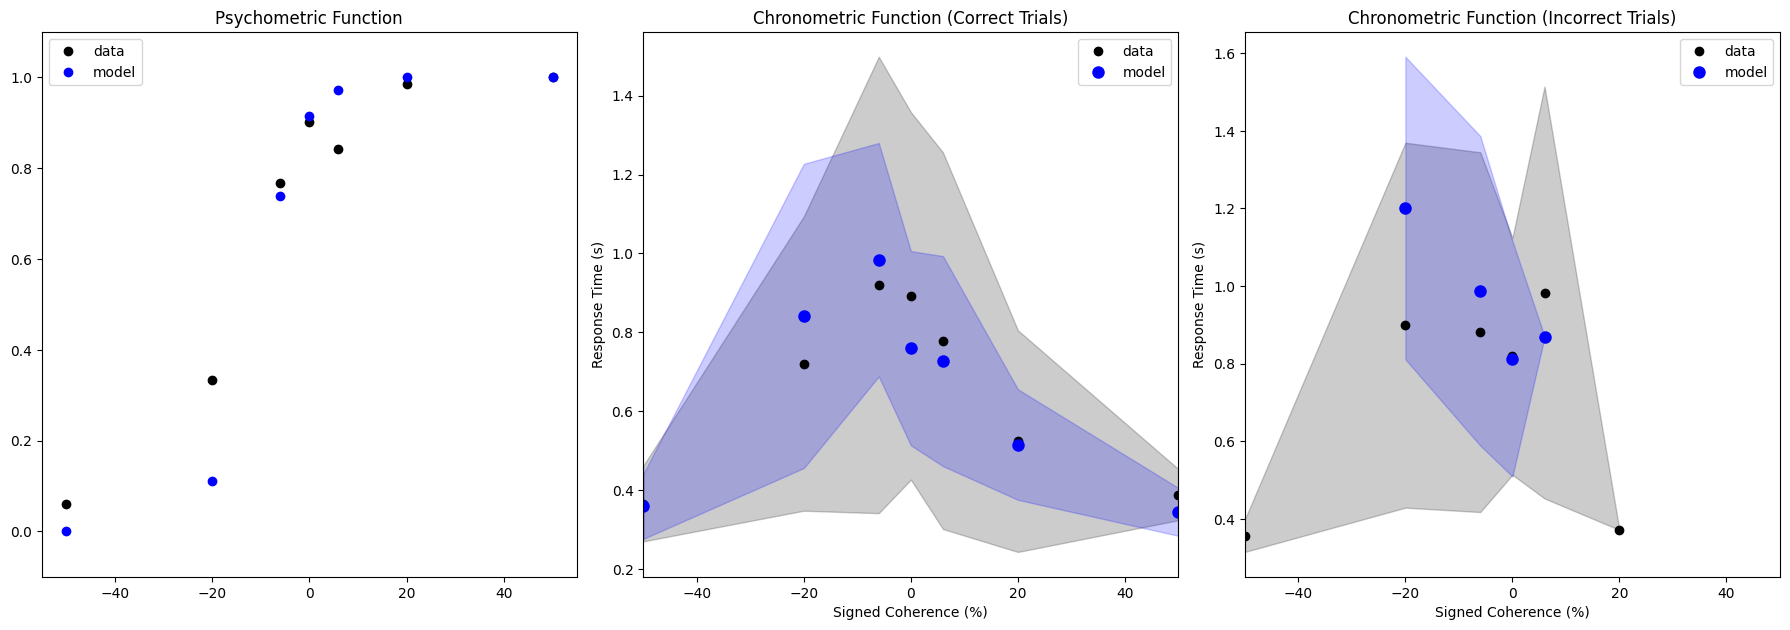

Proportion of invalid trials: 0.0

Session: 210608_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210608_GP_JP has 732 trials
a: 5.7360
z: 0.5311
drift_offset: -0.2762
ndt: 0.1425
drift_gain: 19.1083
variance: 0.9398
leak_rate: 0.5560
time_constant: 0.0040
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 71.23554213691233
       x: [ 5.736e+00  5.311e-01 -2.762e-01  1.425e-01  1.911e+01
            9.398e-01  5.560e-01  3.979e-03]
     nit: 26
    nfev: 2169

Simulation completed. Generated 732 trials.
Valid simulated trials: 732


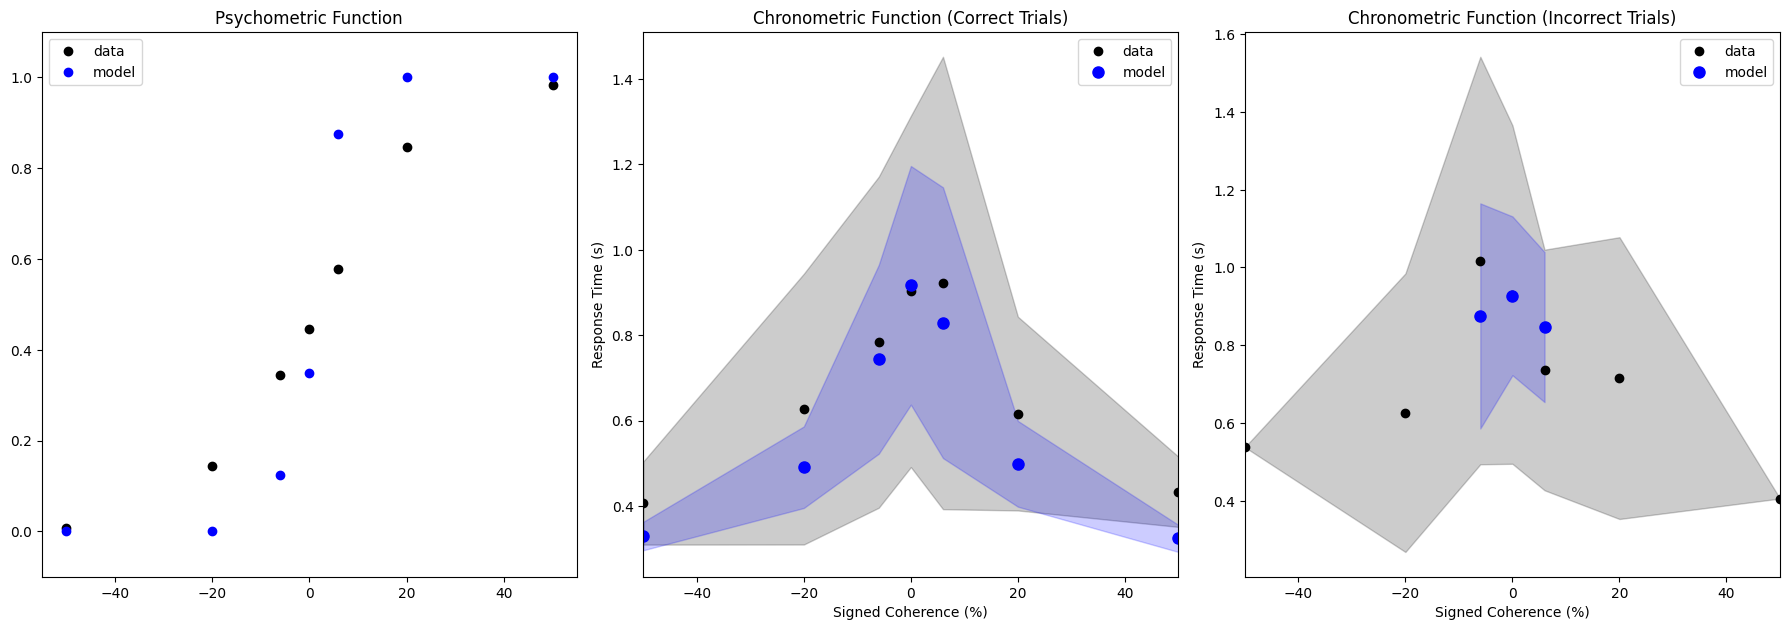

Proportion of invalid trials: 0.0

Session: 210609_GP_JP, Prior: equal)
Prior condition 'equal' in session 210609_GP_JP has 422 trials
a: 4.0327
z: 0.7088
drift_offset: -0.5919
ndt: 0.1504
drift_gain: 13.0603
variance: 2.8644
leak_rate: 0.5750
time_constant: 0.0050
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 42.37662739120973
       x: [ 4.033e+00  7.088e-01 -5.919e-01  1.504e-01  1.306e+01
            2.864e+00  5.750e-01  4.970e-03]
     nit: 27
    nfev: 2285
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 422 trials.
Valid simulated trials: 422


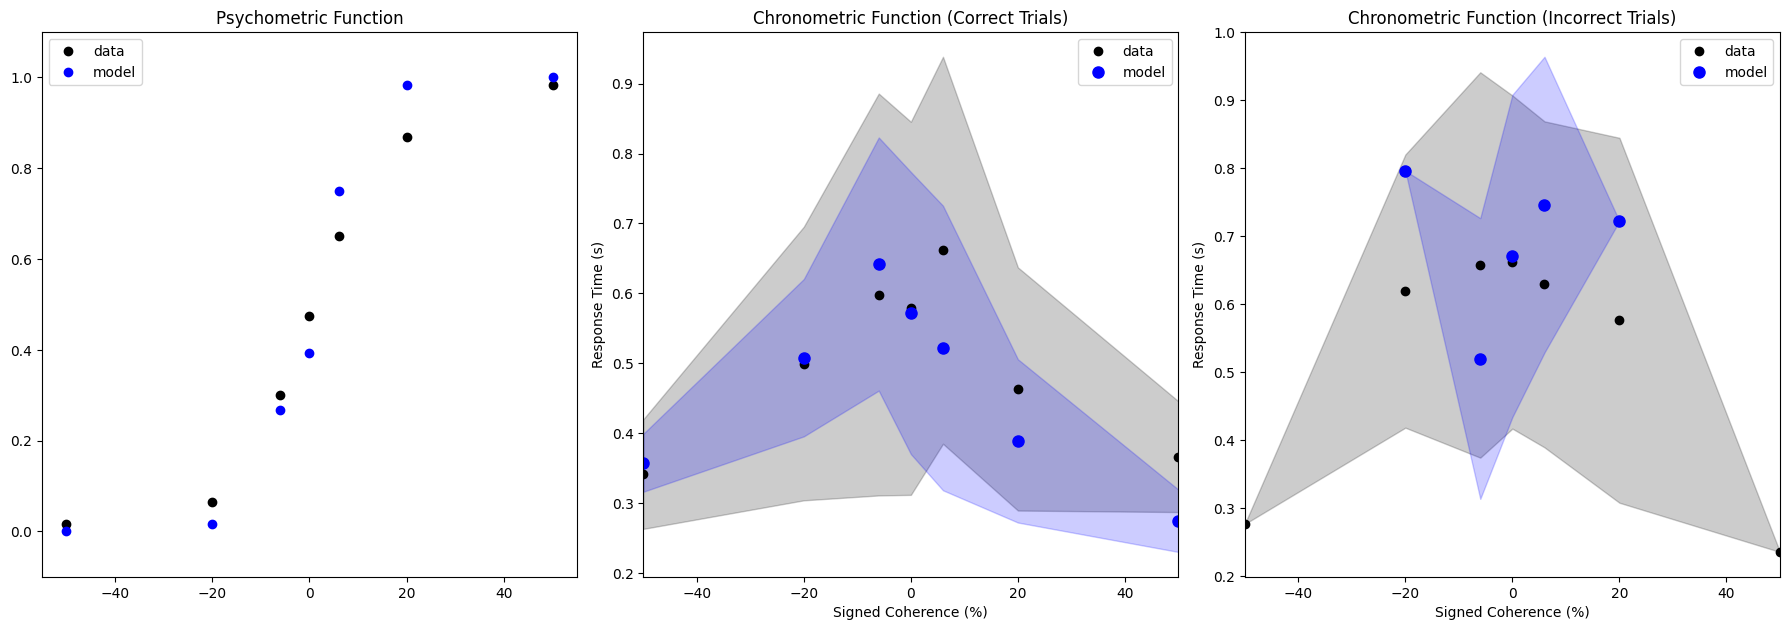

Proportion of invalid trials: 0.0

Session: 210609_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210609_GP_JP has 889 trials
a: 4.8687
z: 0.5356
drift_offset: 0.2839
ndt: 0.1000
drift_gain: 4.7755
variance: 3.9759
leak_rate: 0.3413
time_constant: 0.0042
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 81.15008601506224
       x: [ 4.869e+00  5.356e-01  2.839e-01  1.000e-01  4.775e+00
            3.976e+00  3.413e-01  4.248e-03]
     nit: 26
    nfev: 2178
     jac: [ 0.000e+00  0.000e+00  0.000e+00  1.043e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 889 trials.
Valid simulated trials: 889


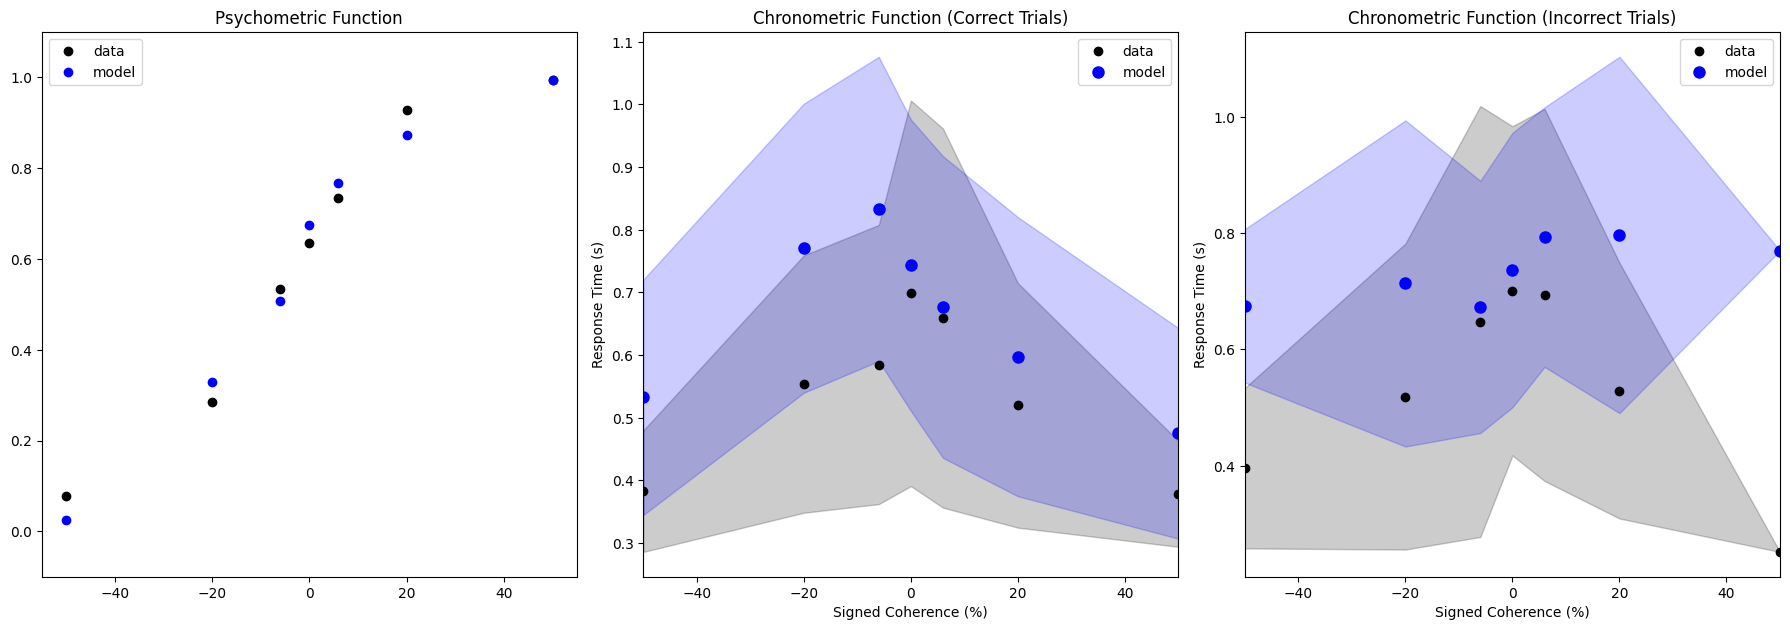

Proportion of invalid trials: 0.0

Session: 210708_GP_JP, Prior: equal)
Prior condition 'equal' in session 210708_GP_JP has 441 trials
a: 3.8191
z: 0.4354
drift_offset: 0.0860
ndt: 0.2473
drift_gain: 16.3692
variance: 4.7110
leak_rate: 0.4118
time_constant: 0.0016
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 41.146829845148545
       x: [ 3.819e+00  4.354e-01  8.596e-02  2.473e-01  1.637e+01
            4.711e+00  4.118e-01  1.624e-03]
     nit: 22
    nfev: 1903
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 441 trials.
Valid simulated trials: 441


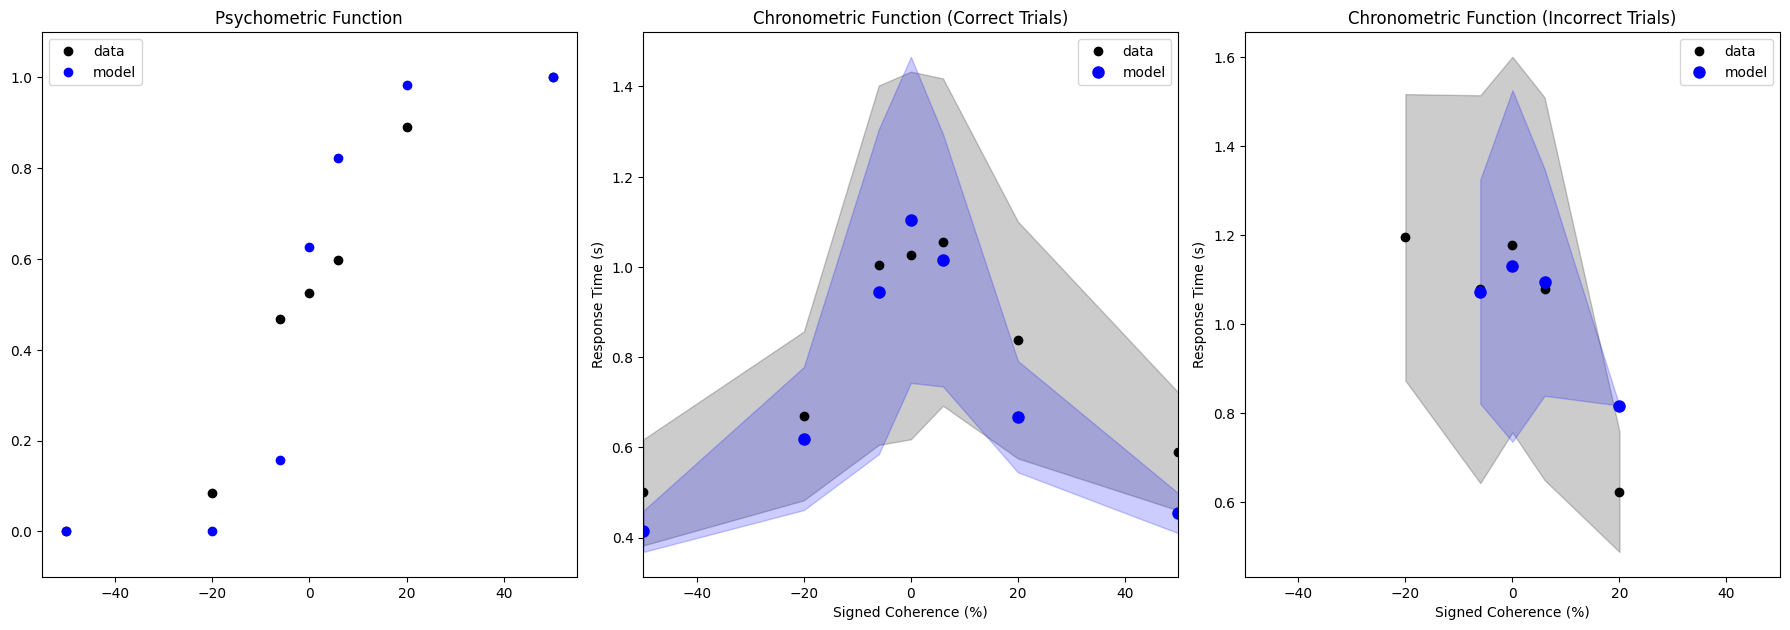

Proportion of invalid trials: 0.0

Session: 210708_GP_JP, Prior: unequal)
Prior condition 'unequal' in session 210708_GP_JP has 321 trials
a: 4.5896
z: 0.3624
drift_offset: -0.2359
ndt: 0.1153
drift_gain: 5.4402
variance: 1.6406
leak_rate: 0.4063
time_constant: 0.0026
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 26.237831543717306
       x: [ 4.590e+00  3.624e-01 -2.359e-01  1.153e-01  5.440e+00
            1.641e+00  4.063e-01  2.635e-03]
     nit: 40
    nfev: 3469

Simulation completed. Generated 321 trials.
Valid simulated trials: 321


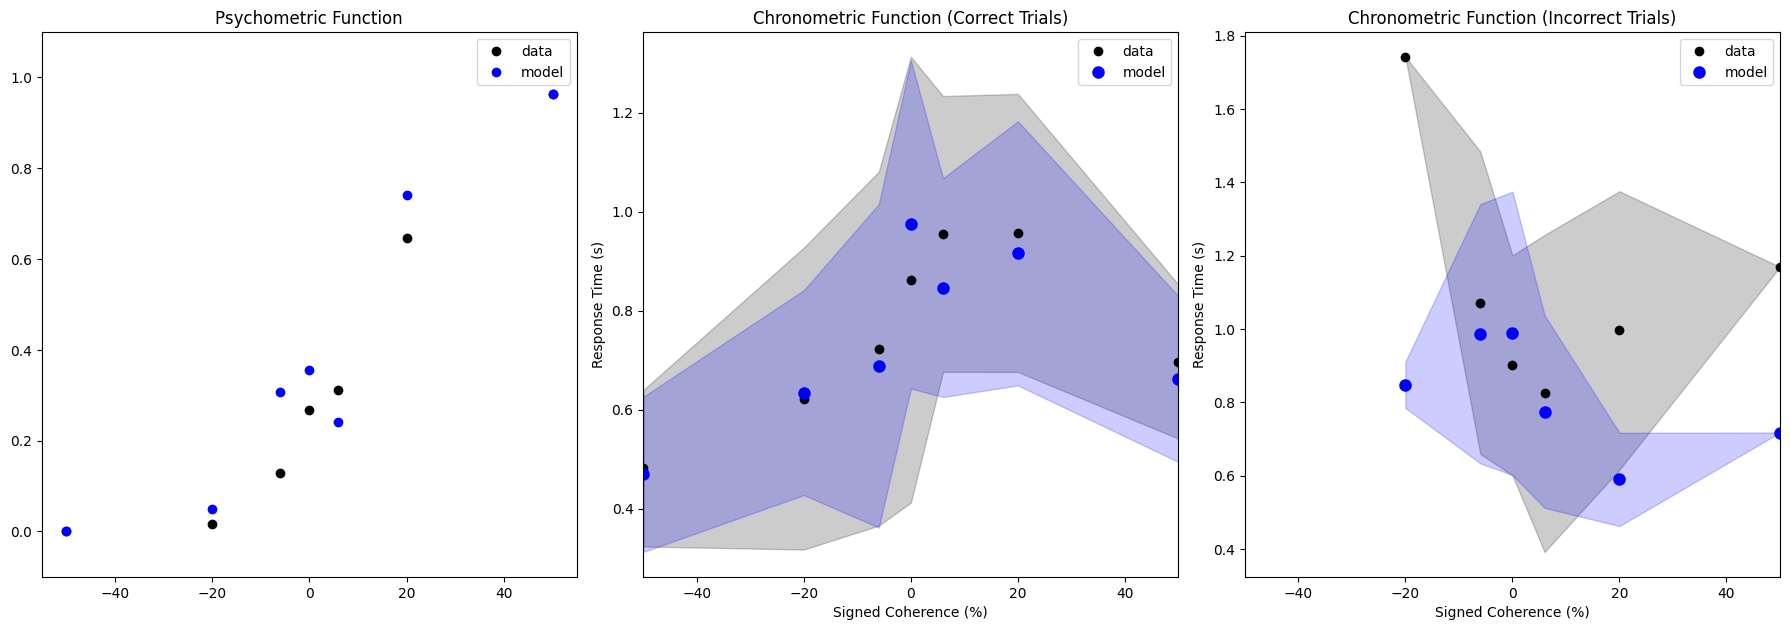

Proportion of invalid trials: 0.0

Session: 240625_GP_TZ, Prior: equal)
Prior condition 'equal' in session 240625_GP_TZ has 511 trials
a: 2.5042
z: 0.1133
drift_offset: 0.8175
ndt: 0.1338
drift_gain: 15.6053
variance: 1.7893
leak_rate: 0.2951
time_constant: 0.0014
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 86.95418529661349
       x: [ 2.504e+00  1.133e-01  8.175e-01  1.338e-01  1.561e+01
            1.789e+00  2.951e-01  1.396e-03]
     nit: 40
    nfev: 3469
     jac: [ 0.000e+00  0.000e+00  0.000e+00 -1.327e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 511 trials.
Valid simulated trials: 511


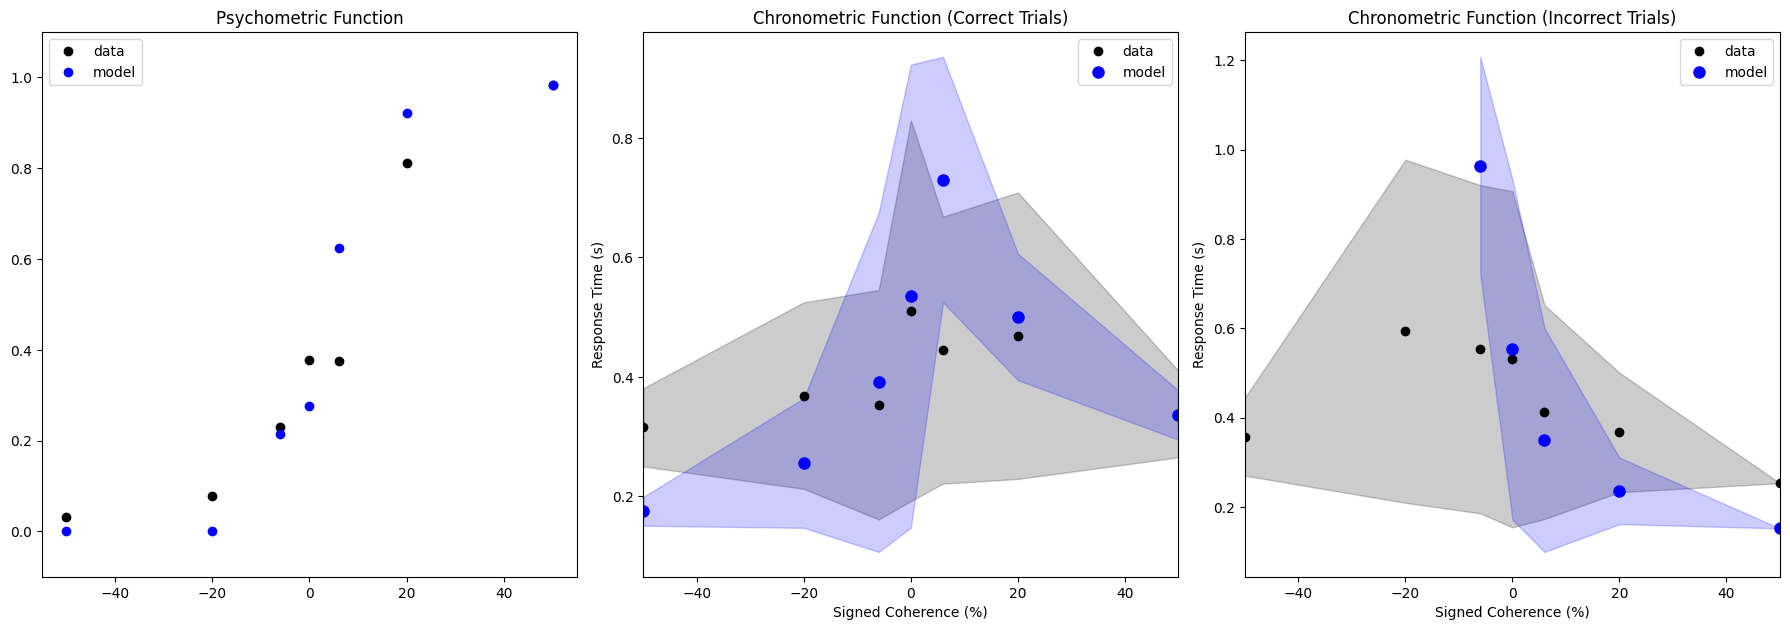

Proportion of invalid trials: 0.0
240625_GP_TZ_prior_block_unequal
Skipping session 240625_GP_TZ due to insufficient optimization iterations: 1

Session: 240627_GP_TZ, Prior: equal)
Prior condition 'equal' in session 240627_GP_TZ has 499 trials
a: 3.0319
z: 0.6161
drift_offset: -0.2128
ndt: 0.1170
drift_gain: 15.0351
variance: 0.7686
leak_rate: 0.6153
time_constant: 0.0011
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 86.27251279996412
       x: [ 3.032e+00  6.161e-01 -2.128e-01  1.170e-01  1.504e+01
            7.686e-01  6.153e-01  1.124e-03]
     nit: 37
    nfev: 3364
     jac: [ 0.000e+00  0.000e+00  0.000e+00  2.550e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 499 trials.
Valid simulated trials: 499


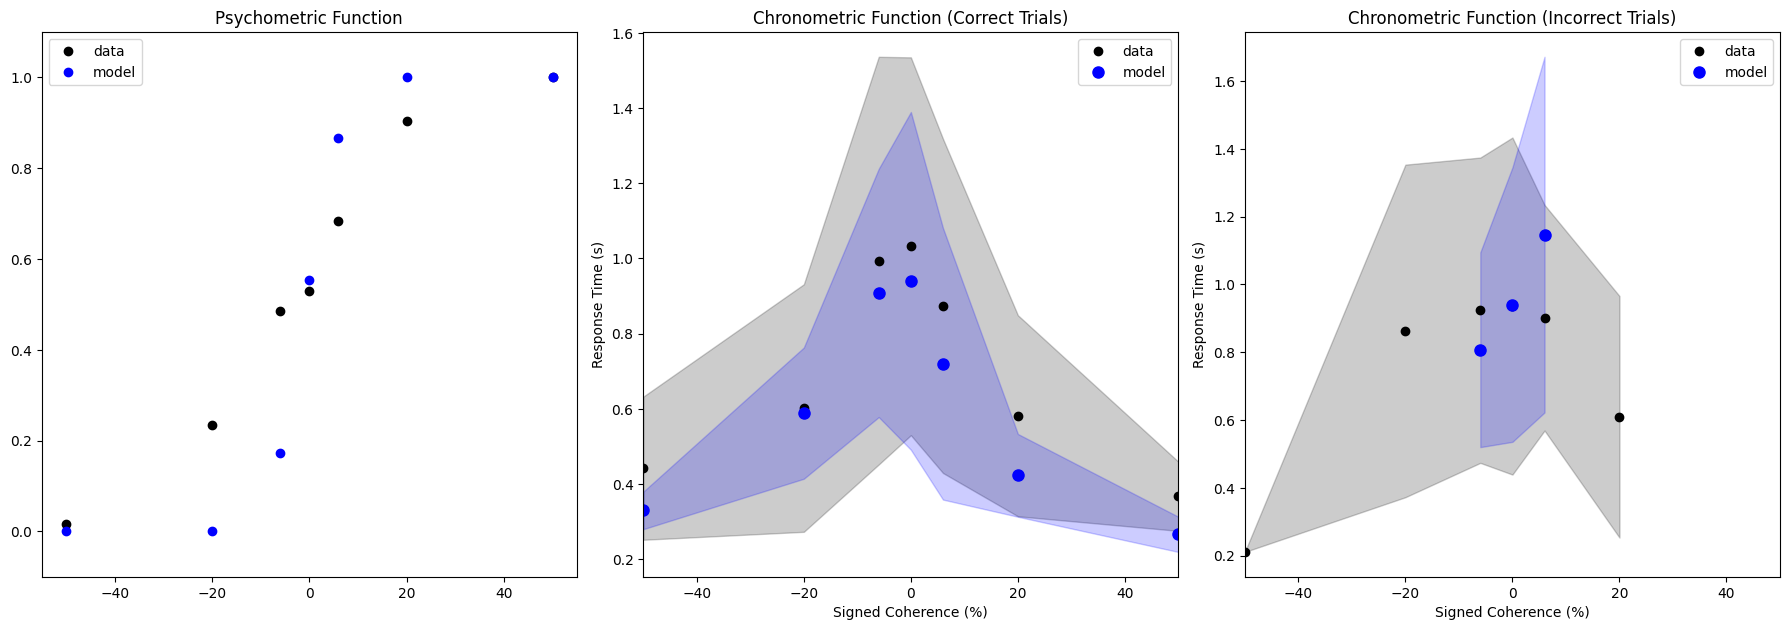

Proportion of invalid trials: 0.0
240627_GP_TZ_prior_block_unequal
Skipping session 240627_GP_TZ due to insufficient optimization iterations: 1

Session: 240710_GP_TZ, Prior: equal)
Prior condition 'equal' in session 240710_GP_TZ has 519 trials
a: 4.4861
z: 0.6631
drift_offset: 0.2151
ndt: 0.1000
drift_gain: 13.5148
variance: 0.3745
leak_rate: 0.1525
time_constant: 0.0026
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 82.24940792598053
       x: [ 4.486e+00  6.631e-01  2.151e-01  1.000e-01  1.351e+01
            3.745e-01  1.525e-01  2.565e-03]
     nit: 33
    nfev: 2738
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 519 trials.
Valid simulated trials: 519


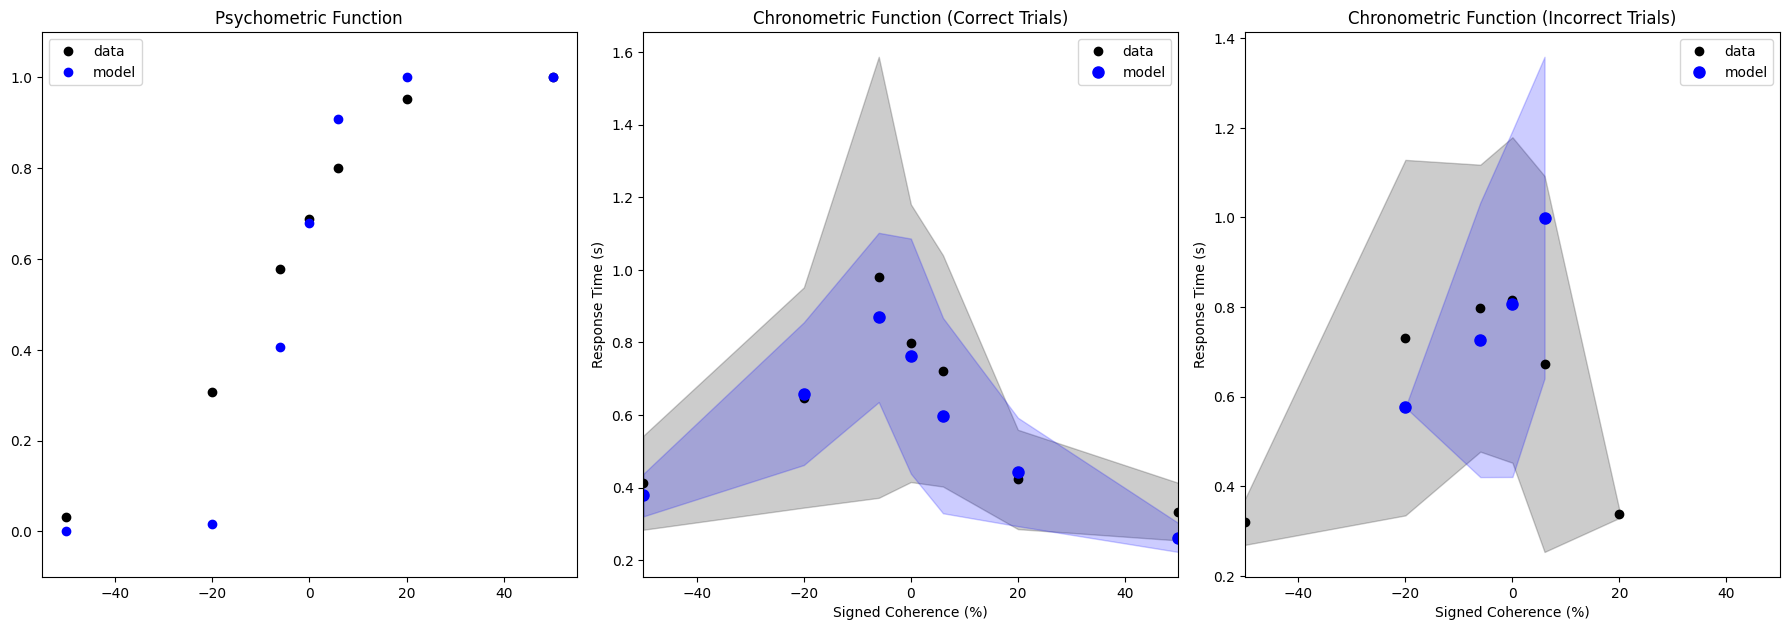

Proportion of invalid trials: 0.0
240710_GP_TZ_prior_block_unequal
Skipping session 240710_GP_TZ due to insufficient optimization iterations: 1

Session: 240805_GP_TZ, Prior: equal)
Prior condition 'equal' in session 240805_GP_TZ has 457 trials
a: 2.5708
z: 0.2239
drift_offset: 0.8798
ndt: 0.1195
drift_gain: 18.1972
variance: 1.4214
leak_rate: 0.2305
time_constant: 0.0012
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 79.12910208200849
       x: [ 2.571e+00  2.239e-01  8.798e-01  1.195e-01  1.820e+01
            1.421e+00  2.305e-01  1.247e-03]
     nit: 43
    nfev: 3790
     jac: [ 0.000e+00  0.000e+00  0.000e+00  8.516e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 457 trials.
Valid simulated trials: 457


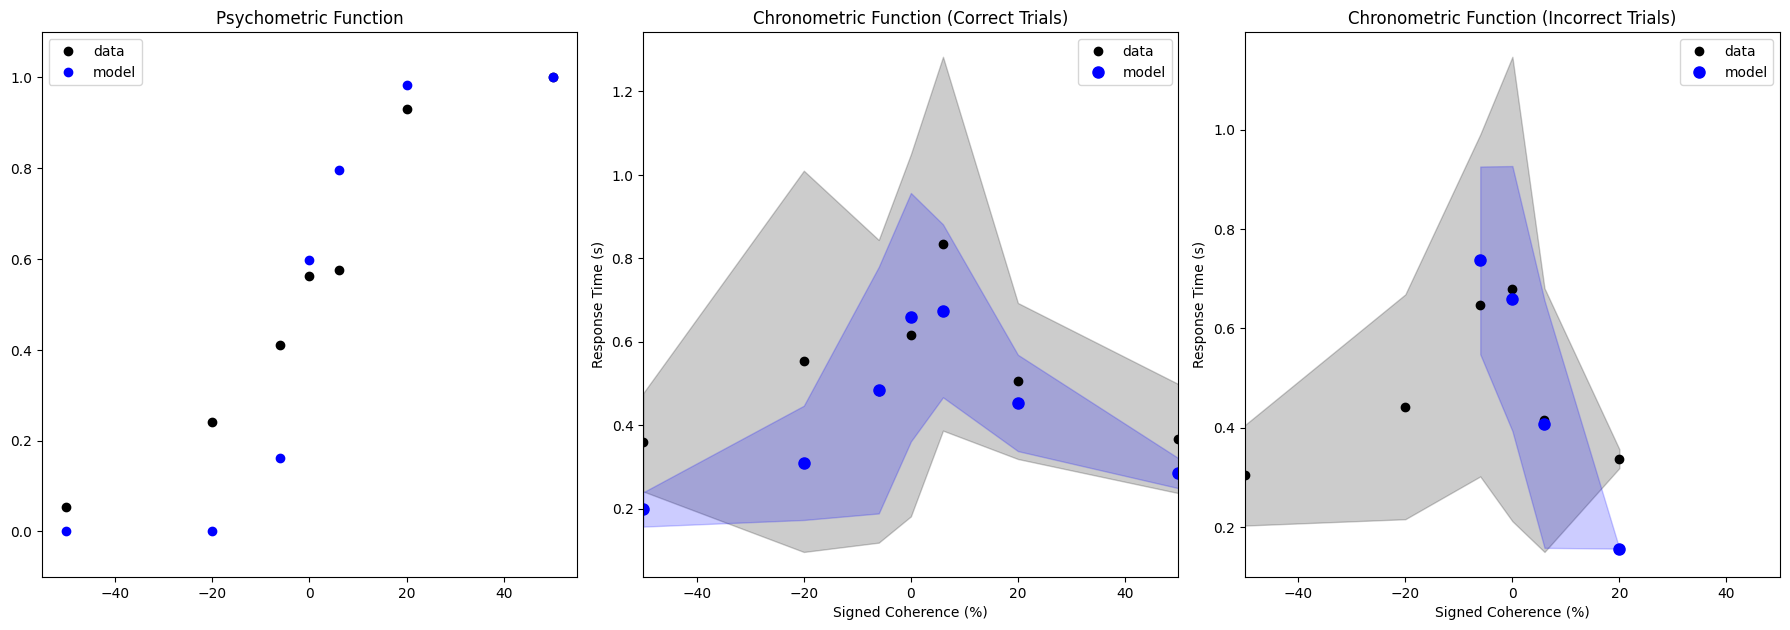

Proportion of invalid trials: 0.0

Session: 240805_GP_TZ, Prior: unequal)
Prior condition 'unequal' in session 240805_GP_TZ has 679 trials
a: 1.7106
z: 0.1192
drift_offset: 0.5049
ndt: 0.2239
drift_gain: 6.5543
variance: 2.2908
leak_rate: 0.8992
time_constant: 0.0011
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 90.81213302733302
       x: [ 1.711e+00  1.192e-01  5.049e-01  2.239e-01  6.554e+00
            2.291e+00  8.992e-01  1.128e-03]
     nit: 33
    nfev: 2747
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 679 trials.
Valid simulated trials: 679


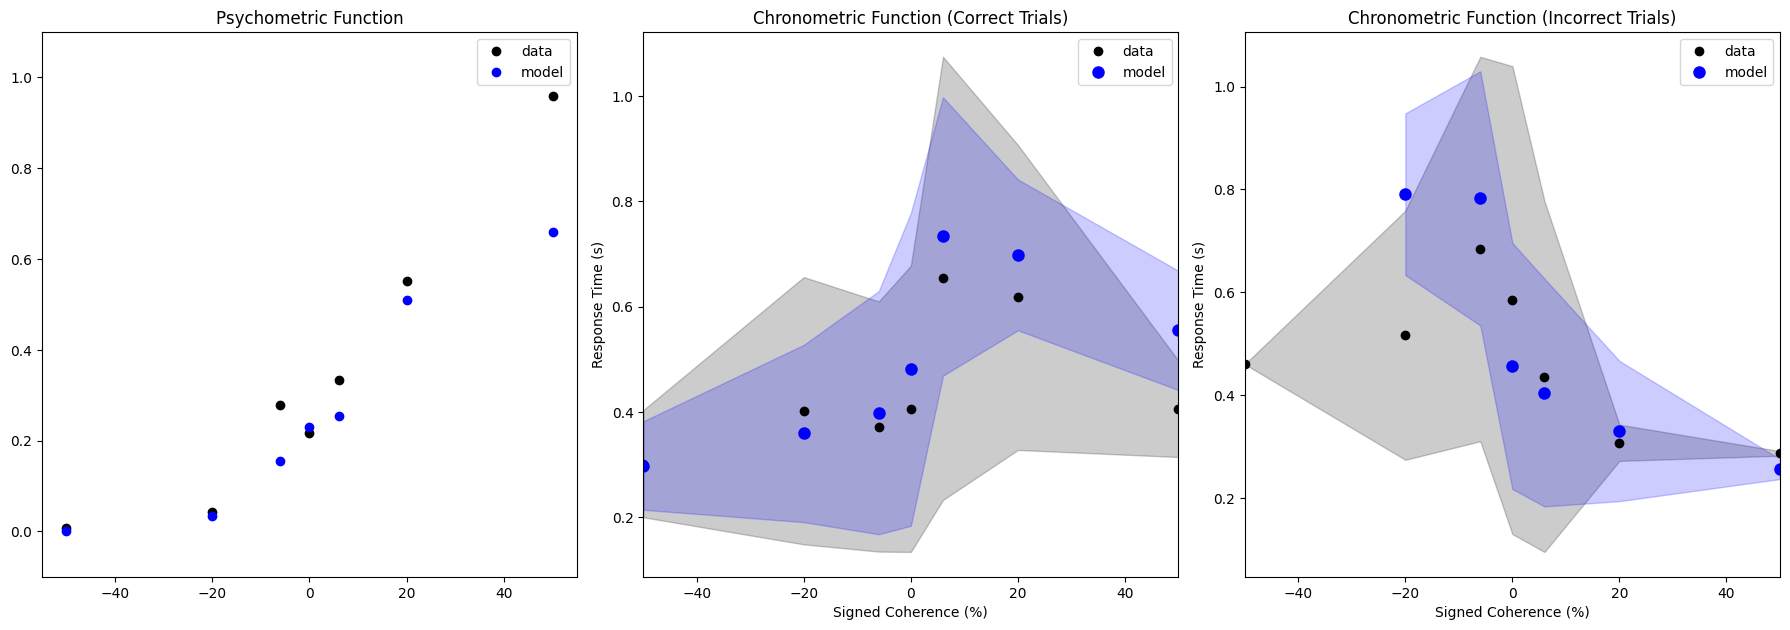

Proportion of invalid trials: 0.0

Session: 240809_GP_TZ, Prior: equal)
Prior condition 'equal' in session 240809_GP_TZ has 507 trials
a: 2.6127
z: 0.4561
drift_offset: -0.0512
ndt: 0.1390
drift_gain: 10.0008
variance: 3.1084
leak_rate: 0.1294
time_constant: 0.0015
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 88.58458969034149
       x: [ 2.613e+00  4.561e-01 -5.122e-02  1.390e-01  1.000e+01
            3.108e+00  1.294e-01  1.507e-03]
     nit: 29
    nfev: 2589

Simulation completed. Generated 507 trials.
Valid simulated trials: 507


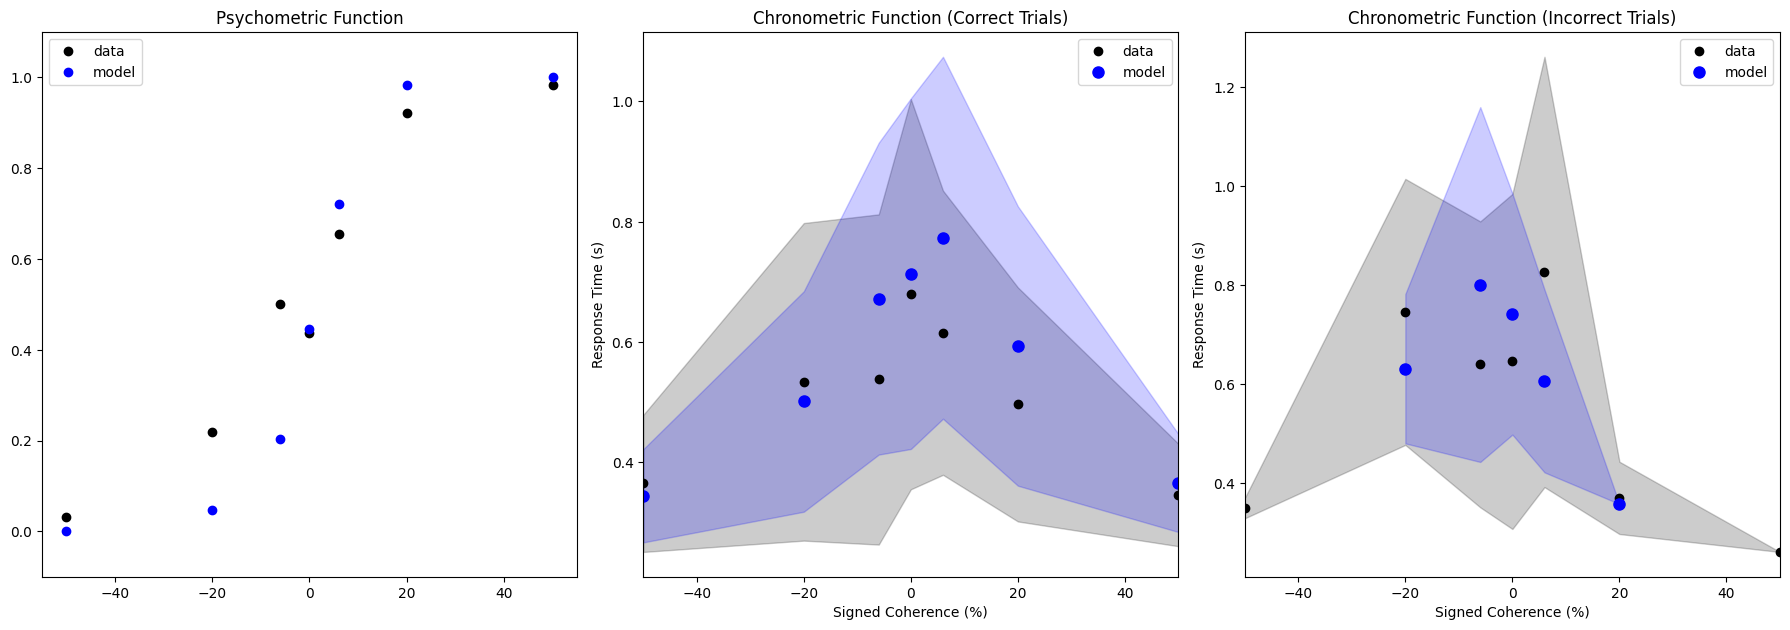

Proportion of invalid trials: 0.0

Session: 240809_GP_TZ, Prior: unequal)
Prior condition 'unequal' in session 240809_GP_TZ has 701 trials
a: 2.8301
z: 0.4761
drift_offset: 0.9195
ndt: 0.1286
drift_gain: 17.0015
variance: 2.1439
leak_rate: 0.8754
time_constant: 0.0019
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 95.33171760851668
       x: [ 2.830e+00  4.761e-01  9.195e-01  1.286e-01  1.700e+01
            2.144e+00  8.754e-01  1.901e-03]
     nit: 34
    nfev: 2890
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 701 trials.
Valid simulated trials: 701


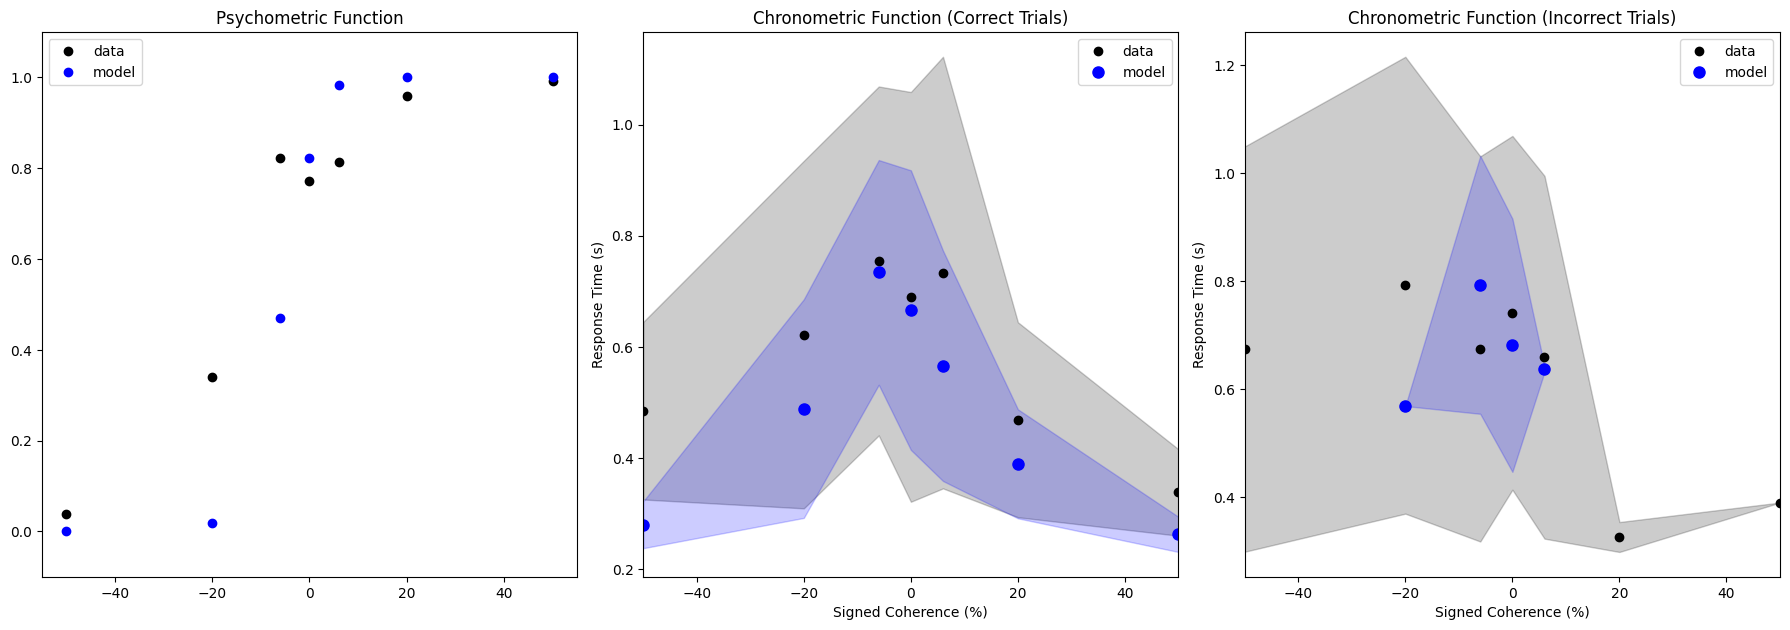

Proportion of invalid trials: 0.0

Session: 240814_GP_TZ, Prior: equal)
Prior condition 'equal' in session 240814_GP_TZ has 522 trials
a: 5.7807
z: 0.2026
drift_offset: -0.1364
ndt: 0.1000
drift_gain: 7.6604
variance: 1.6345
leak_rate: 0.0388
time_constant: 0.0058
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 81.27659237675691
       x: [ 5.781e+00  2.026e-01 -1.364e-01  1.000e-01  7.660e+00
            1.635e+00  3.881e-02  5.834e-03]
     nit: 35
    nfev: 2898
     jac: [ 0.000e+00  0.000e+00  0.000e+00  1.037e+01  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 522 trials.
Valid simulated trials: 522


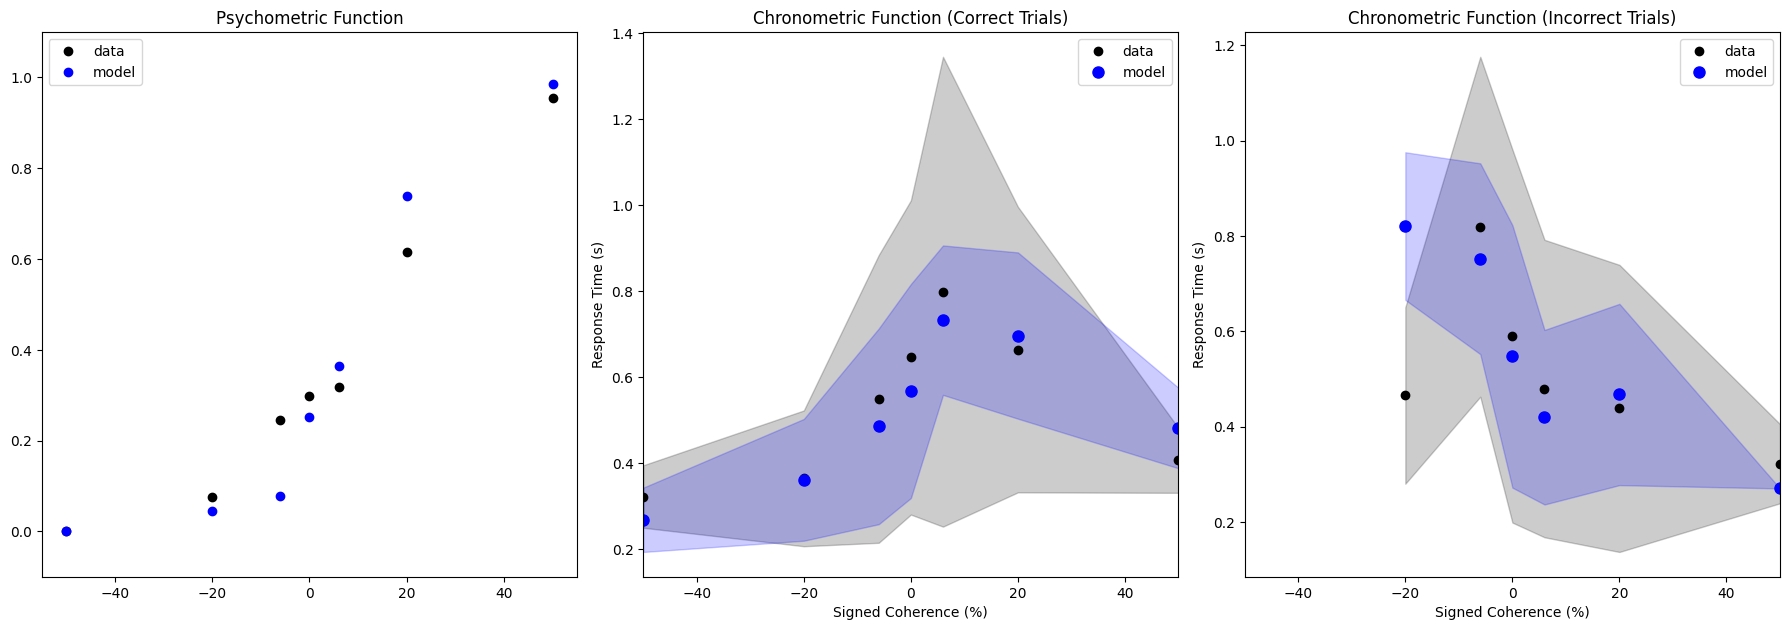

Proportion of invalid trials: 0.0

Session: 240814_GP_TZ, Prior: unequal)
Prior condition 'unequal' in session 240814_GP_TZ has 450 trials
a: 2.8169
z: 0.4655
drift_offset: -0.2378
ndt: 0.1385
drift_gain: 6.5919
variance: 3.4479
leak_rate: 0.3377
time_constant: 0.0025
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 76.82526267893284
       x: [ 2.817e+00  4.655e-01 -2.378e-01  1.385e-01  6.592e+00
            3.448e+00  3.377e-01  2.519e-03]
     nit: 18
    nfev: 1529

Simulation completed. Generated 450 trials.
Valid simulated trials: 450


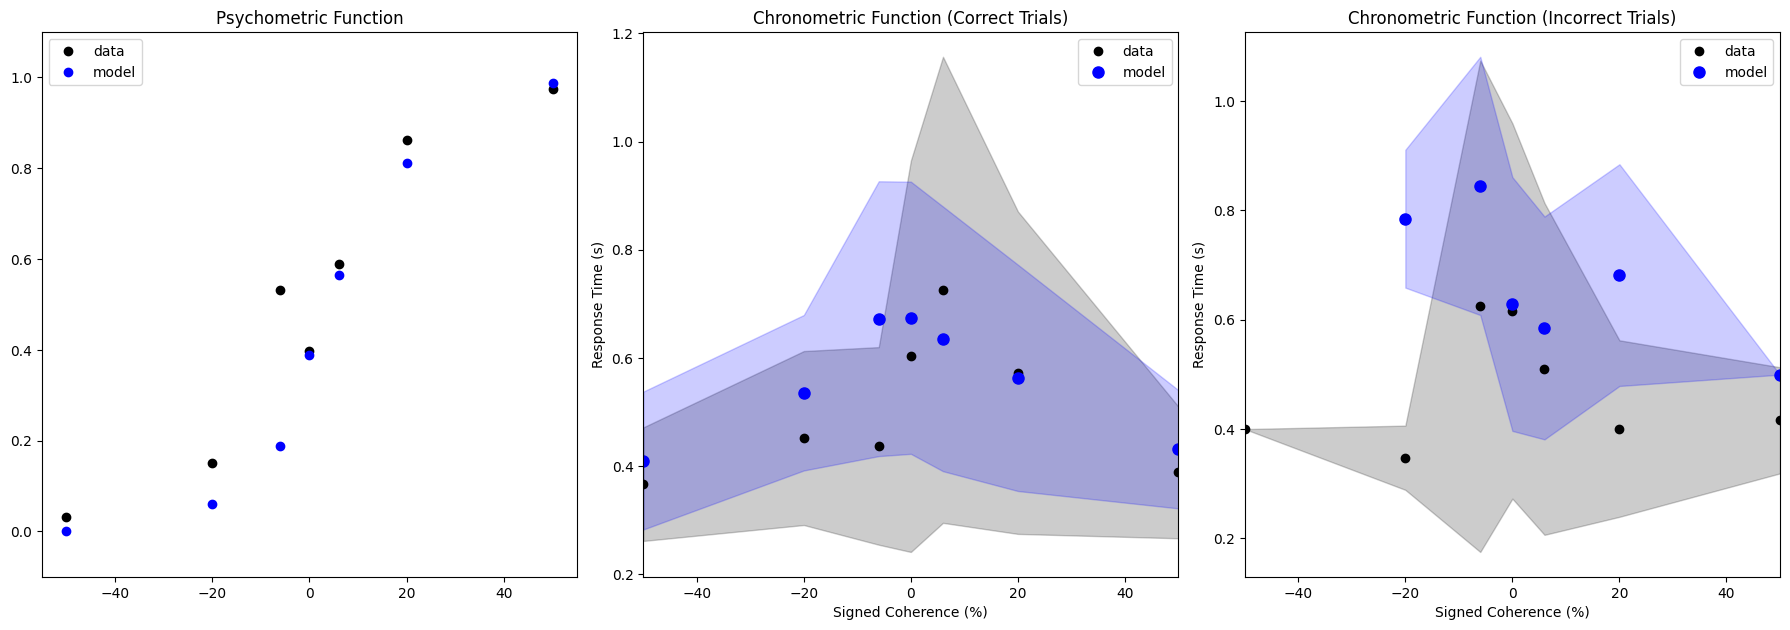

Proportion of invalid trials: 0.0

Session: 240828_GP_TZ, Prior: equal)
Prior condition 'equal' in session 240828_GP_TZ has 532 trials
a: 1.9610
z: 0.3992
drift_offset: -0.9719
ndt: 0.1000
drift_gain: 17.0595
variance: 2.6948
leak_rate: 0.3229
time_constant: 0.0015
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 56.39328372401424
       x: [ 1.961e+00  3.992e-01 -9.719e-01  1.000e-01  1.706e+01
            2.695e+00  3.229e-01  1.488e-03]
     nit: 38
    nfev: 3138
     jac: [ 0.000e+00  0.000e+00  0.000e+00  2.128e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 532 trials.
Valid simulated trials: 532


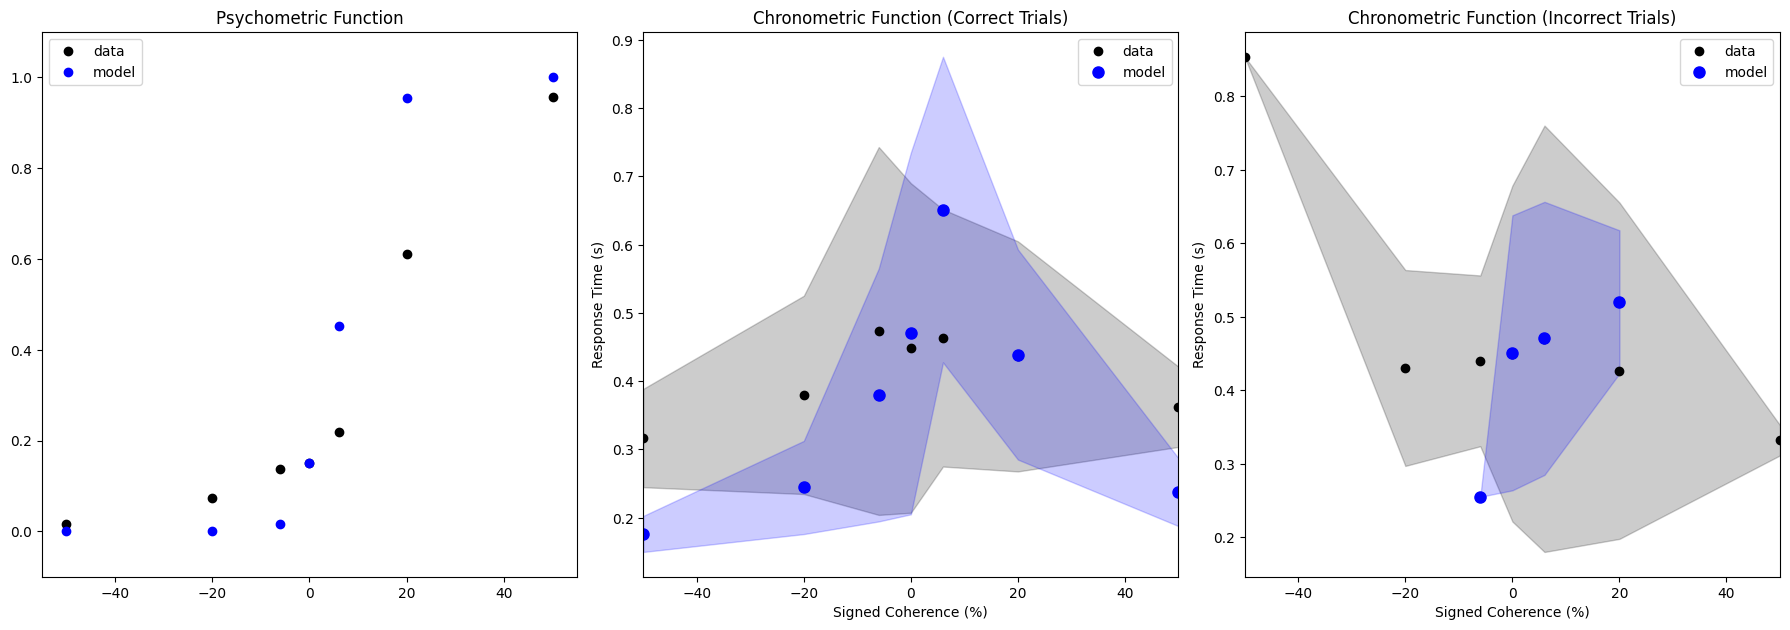

Proportion of invalid trials: 0.0

Session: 240828_GP_TZ, Prior: unequal)
Prior condition 'unequal' in session 240828_GP_TZ has 687 trials
a: 2.2419
z: 0.3716
drift_offset: 0.4356
ndt: 0.1000
drift_gain: 7.0335
variance: 2.7288
leak_rate: 0.2011
time_constant: 0.0013
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 119.2731248585346
       x: [ 2.242e+00  3.716e-01  4.356e-01  1.000e-01  7.033e+00
            2.729e+00  2.011e-01  1.258e-03]
     nit: 35
    nfev: 2898
     jac: [ 0.000e+00  0.000e+00  0.000e+00  9.515e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 687 trials.
Valid simulated trials: 687


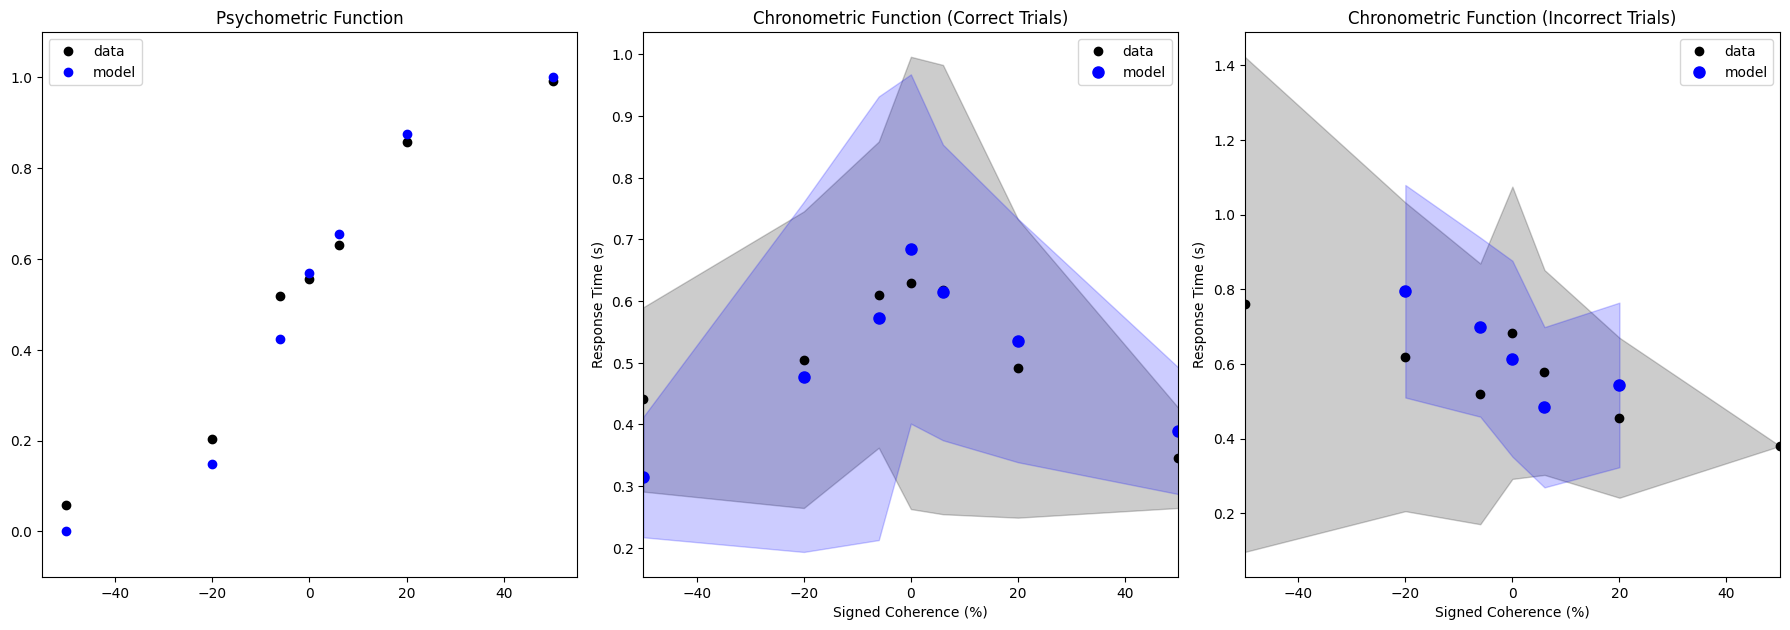

Proportion of invalid trials: 0.0

Session: 240903_GP_TZ, Prior: equal)
Prior condition 'equal' in session 240903_GP_TZ has 546 trials
a: 2.1609
z: 0.5757
drift_offset: -0.3356
ndt: 0.1879
drift_gain: 4.9355
variance: 3.3598
leak_rate: 0.5530
time_constant: 0.0017
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 93.89268297216076
       x: [ 2.161e+00  5.757e-01 -3.356e-01  1.879e-01  4.935e+00
            3.360e+00  5.530e-01  1.717e-03]
     nit: 26
    nfev: 2295
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 546 trials.
Valid simulated trials: 546


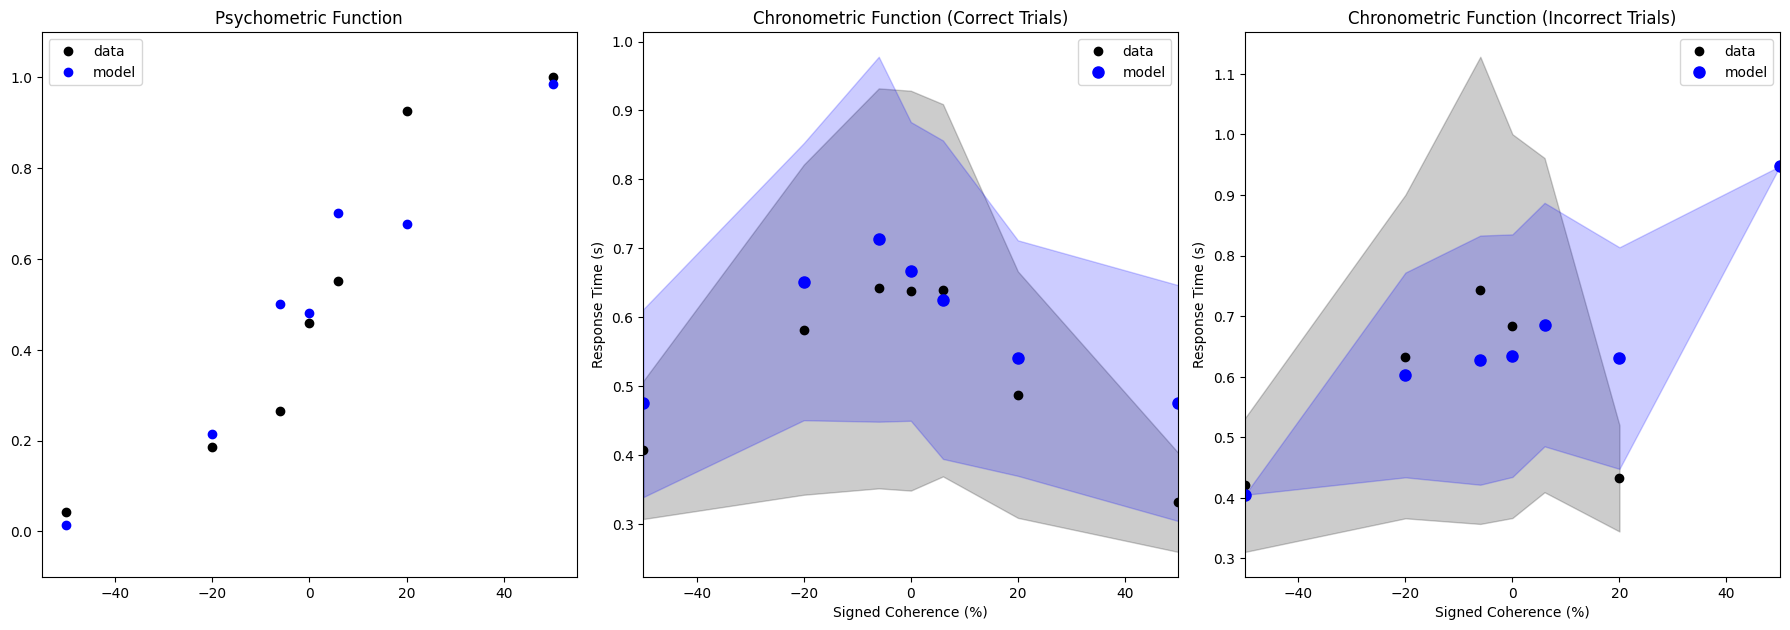

Proportion of invalid trials: 0.0

Session: 240903_GP_TZ, Prior: unequal)
Prior condition 'unequal' in session 240903_GP_TZ has 686 trials
a: 3.5842
z: 0.3871
drift_offset: -0.6460
ndt: 0.1000
drift_gain: 6.2223
variance: 3.1261
leak_rate: 0.2608
time_constant: 0.0031
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 92.8635493534812
       x: [ 3.584e+00  3.871e-01 -6.460e-01  1.000e-01  6.222e+00
            3.126e+00  2.608e-01  3.073e-03]
     nit: 24
    nfev: 2018
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 686 trials.
Valid simulated trials: 686


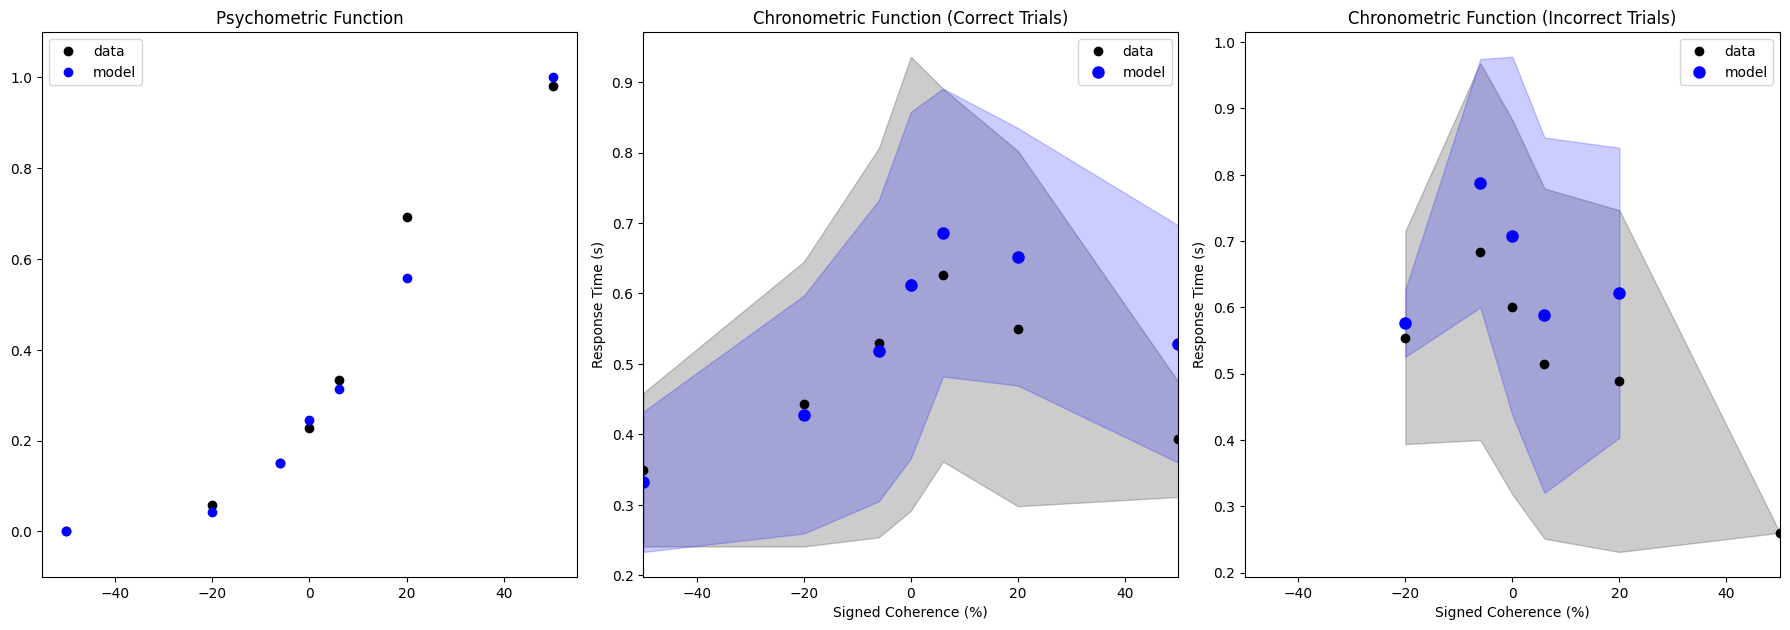

Proportion of invalid trials: 0.0

Session: 241002_GP_TZ, Prior: equal)
Prior condition 'equal' in session 241002_GP_TZ has 494 trials
a: 2.7285
z: 0.3218
drift_offset: -0.2120
ndt: 0.1032
drift_gain: 14.5140
variance: 3.1163
leak_rate: 0.0756
time_constant: 0.0010
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 73.04183340945617
       x: [ 2.729e+00  3.218e-01 -2.120e-01  1.032e-01  1.451e+01
            3.116e+00  7.565e-02  1.024e-03]
     nit: 40
    nfev: 3289

Simulation completed. Generated 494 trials.
Valid simulated trials: 494


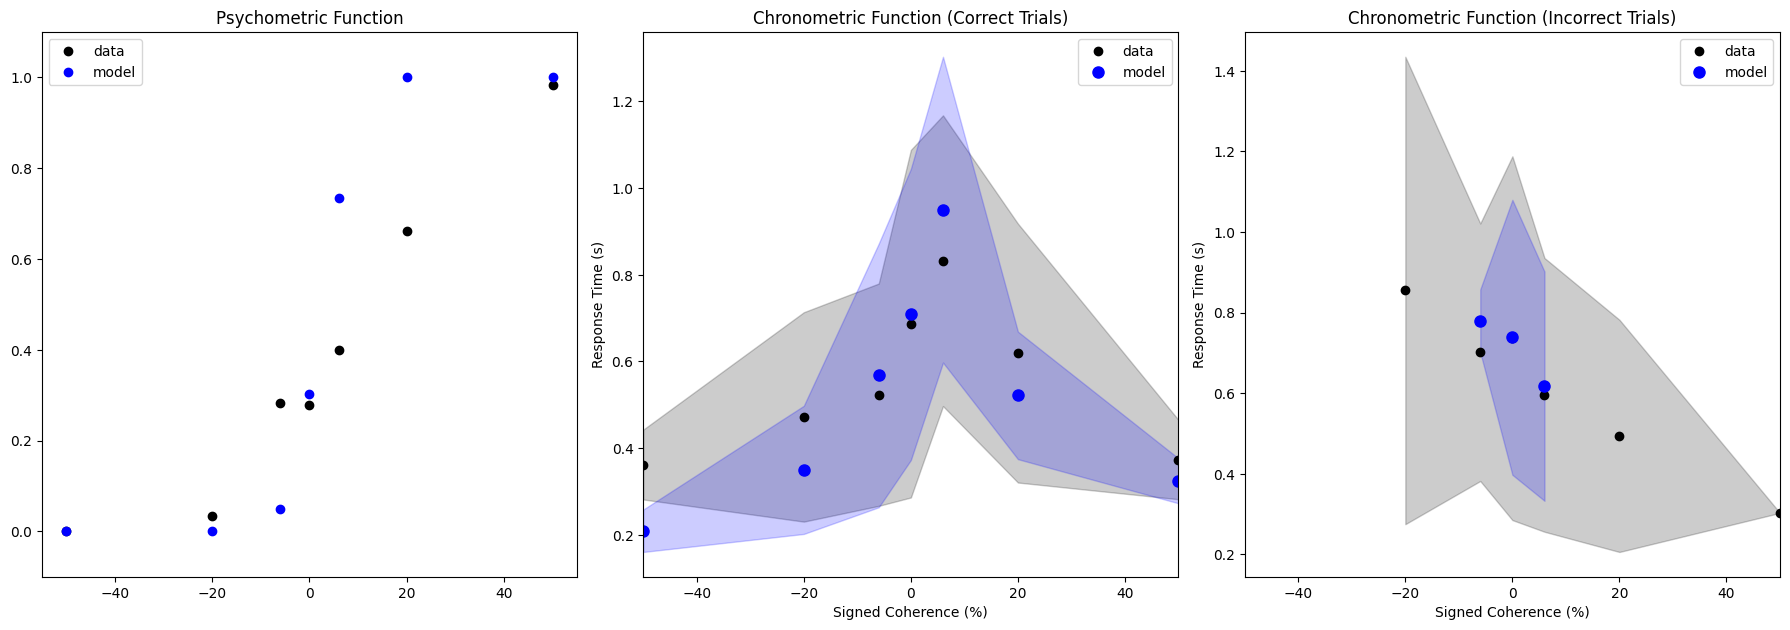

Proportion of invalid trials: 0.0

Session: 241002_GP_TZ, Prior: unequal)
Prior condition 'unequal' in session 241002_GP_TZ has 677 trials
a: 4.1985
z: 0.3147
drift_offset: 0.9372
ndt: 0.1000
drift_gain: 12.0148
variance: 2.2348
leak_rate: 0.2797
time_constant: 0.0030
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 105.4240398031025
       x: [ 4.198e+00  3.147e-01  9.372e-01  1.000e-01  1.201e+01
            2.235e+00  2.797e-01  3.017e-03]
     nit: 34
    nfev: 2818
     jac: [ 0.000e+00  0.000e+00  0.000e+00  3.648e-01  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 677 trials.
Valid simulated trials: 677


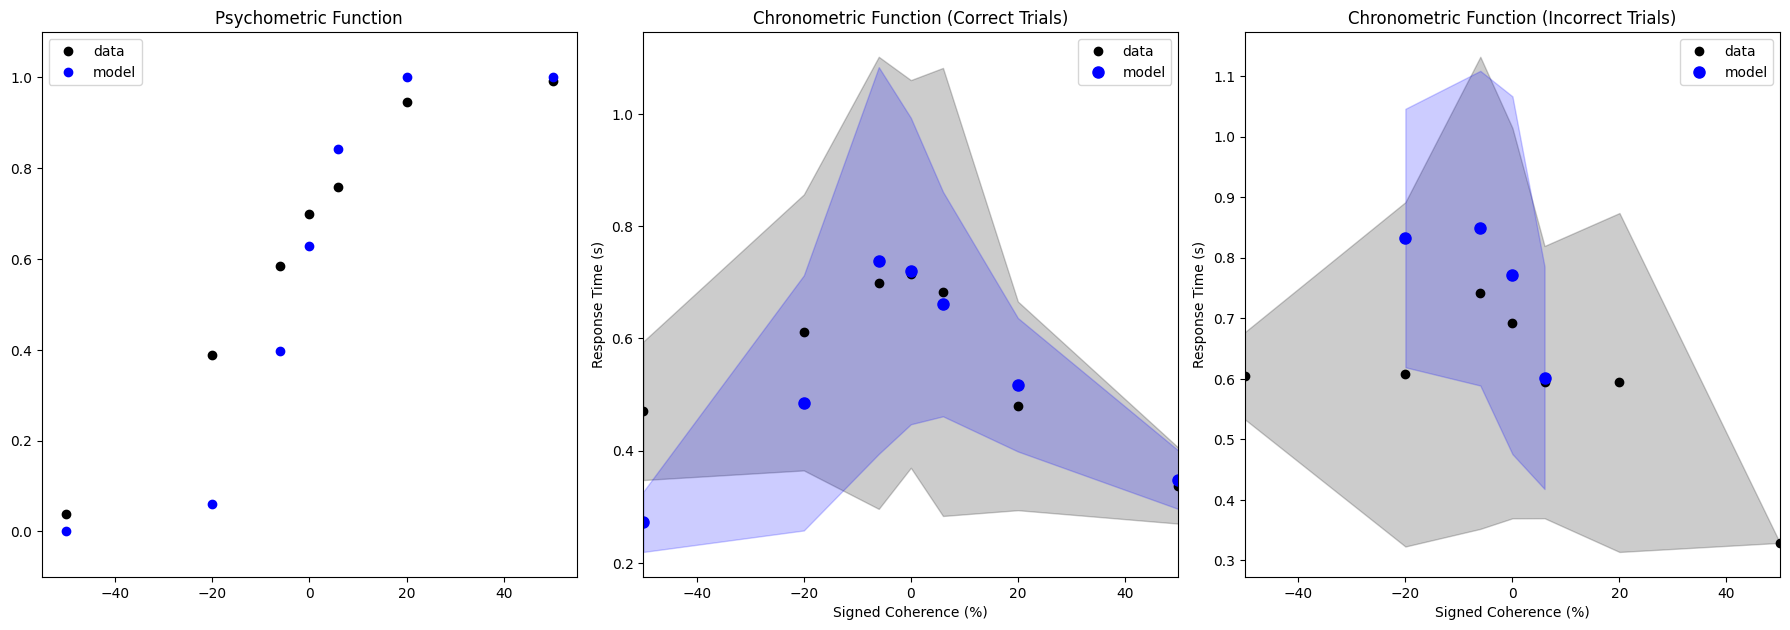

Proportion of invalid trials: 0.0

Session: 241129_GP_TZ, Prior: equal)
Prior condition 'equal' in session 241129_GP_TZ has 549 trials
a: 1.6181
z: 0.5312
drift_offset: -1.1143
ndt: 0.1657
drift_gain: 11.8323
variance: 3.4659
leak_rate: 0.5629
time_constant: 0.0010
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 64.68210541930121
       x: [ 1.618e+00  5.312e-01 -1.114e+00  1.657e-01  1.183e+01
            3.466e+00  5.629e-01  1.023e-03]
     nit: 40
    nfev: 3343
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 549 trials.
Valid simulated trials: 548


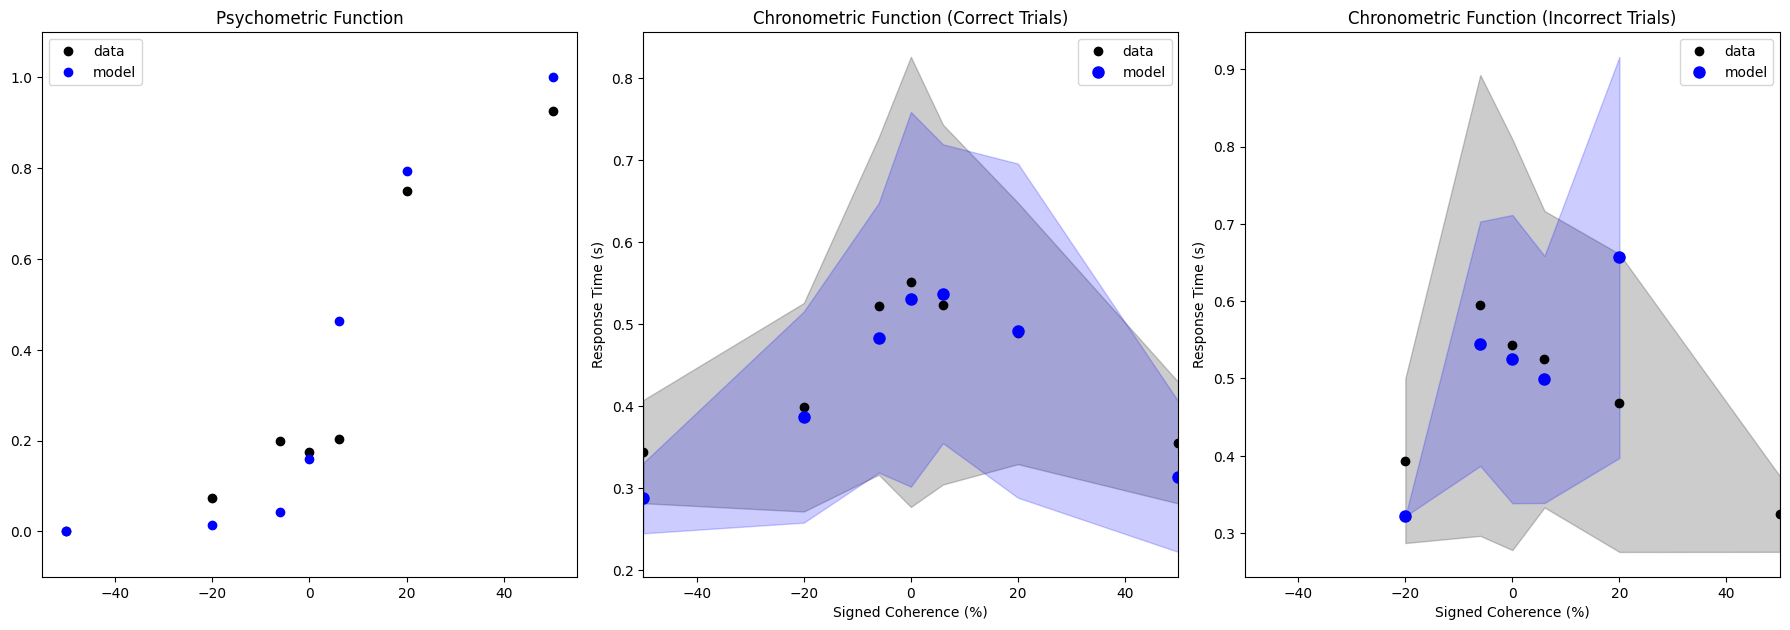

Proportion of invalid trials: 0.0018214936247723133
241129_GP_TZ_prior_block_unequal
Skipping session 241129_GP_TZ due to insufficient optimization iterations: 1

Session: 241130_GP_TZ, Prior: equal)
Prior condition 'equal' in session 241130_GP_TZ has 496 trials
a: 1.9524
z: 0.5127
drift_offset: -0.1899
ndt: 0.1407
drift_gain: 10.7614
variance: 1.8708
leak_rate: 0.7088
time_constant: 0.0011
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 85.471728492862
       x: [ 1.952e+00  5.127e-01 -1.899e-01  1.407e-01  1.076e+01
            1.871e+00  7.088e-01  1.110e-03]
     nit: 32
    nfev: 2649

Simulation completed. Generated 496 trials.
Valid simulated trials: 496


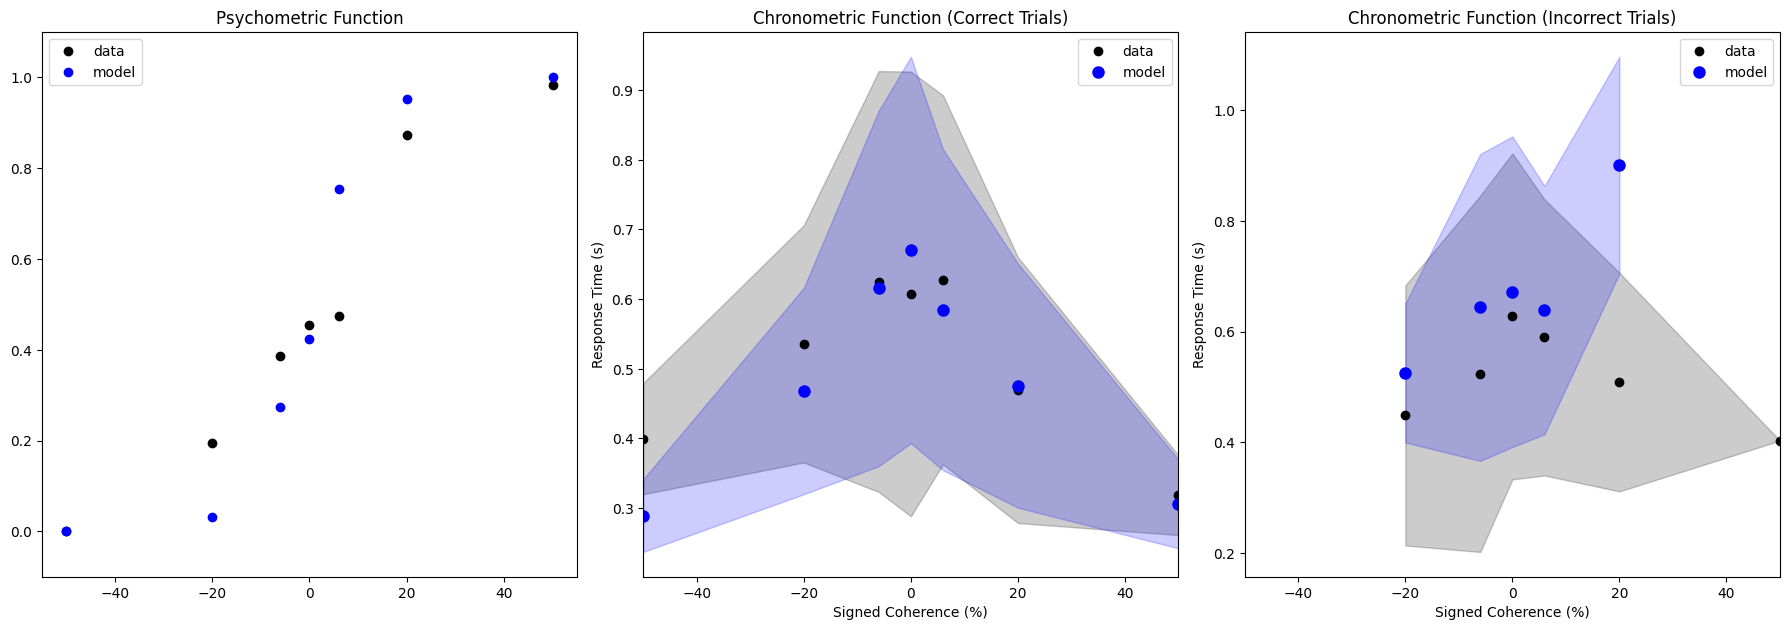

Proportion of invalid trials: 0.0
241130_GP_TZ_prior_block_unequal
Skipping session 241130_GP_TZ due to insufficient optimization iterations: 1

Session: 241209_GP_TZ, Prior: equal)
Prior condition 'equal' in session 241209_GP_TZ has 444 trials
a: 3.0874
z: 0.4565
drift_offset: -1.8436
ndt: 0.1065
drift_gain: 8.7714
variance: 1.8712
leak_rate: 0.1567
time_constant: 0.0040
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 26.158680777738436
       x: [ 3.087e+00  4.565e-01 -1.844e+00  1.065e-01  8.771e+00
            1.871e+00  1.567e-01  4.033e-03]
     nit: 38
    nfev: 3237
     jac: [ 0.000e+00  0.000e+00  0.000e+00  2.424e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 444 trials.
Valid simulated trials: 444


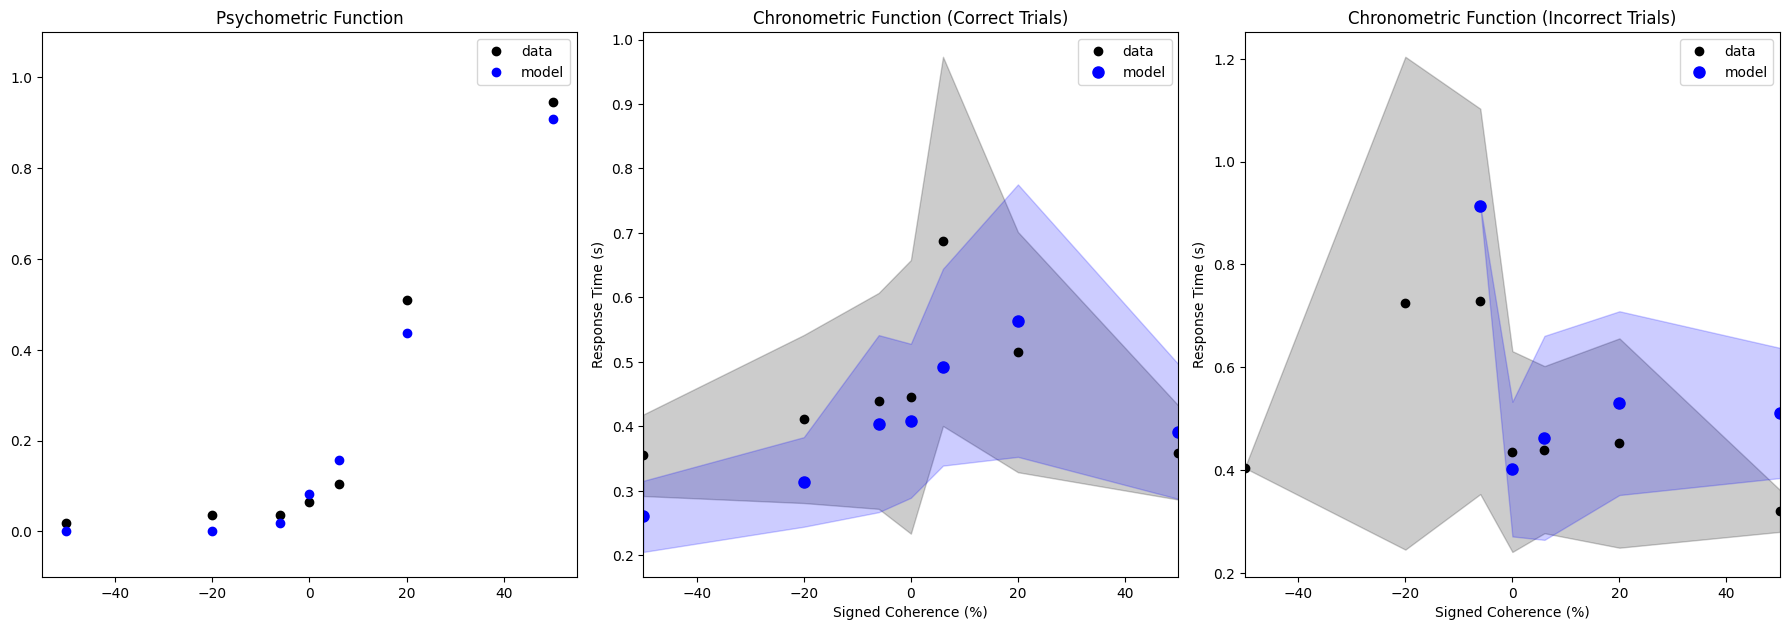

Proportion of invalid trials: 0.0
241209_GP_TZ_prior_block_unequal
Skipping session 241209_GP_TZ due to insufficient optimization iterations: 1

Session: 241211_GP_TZ, Prior: equal)
Prior condition 'equal' in session 241211_GP_TZ has 545 trials
a: 3.1463
z: 0.2236
drift_offset: 0.0324
ndt: 0.1000
drift_gain: 3.6098
variance: 1.9483
leak_rate: 0.7933
time_constant: 0.0021
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 80.21219531882741
       x: [ 3.146e+00  2.236e-01  3.243e-02  1.000e-01  3.610e+00
            1.948e+00  7.933e-01  2.067e-03]
     nit: 38
    nfev: 3138
     jac: [ 0.000e+00  0.000e+00  0.000e+00  3.612e-02  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 545 trials.
Valid simulated trials: 543


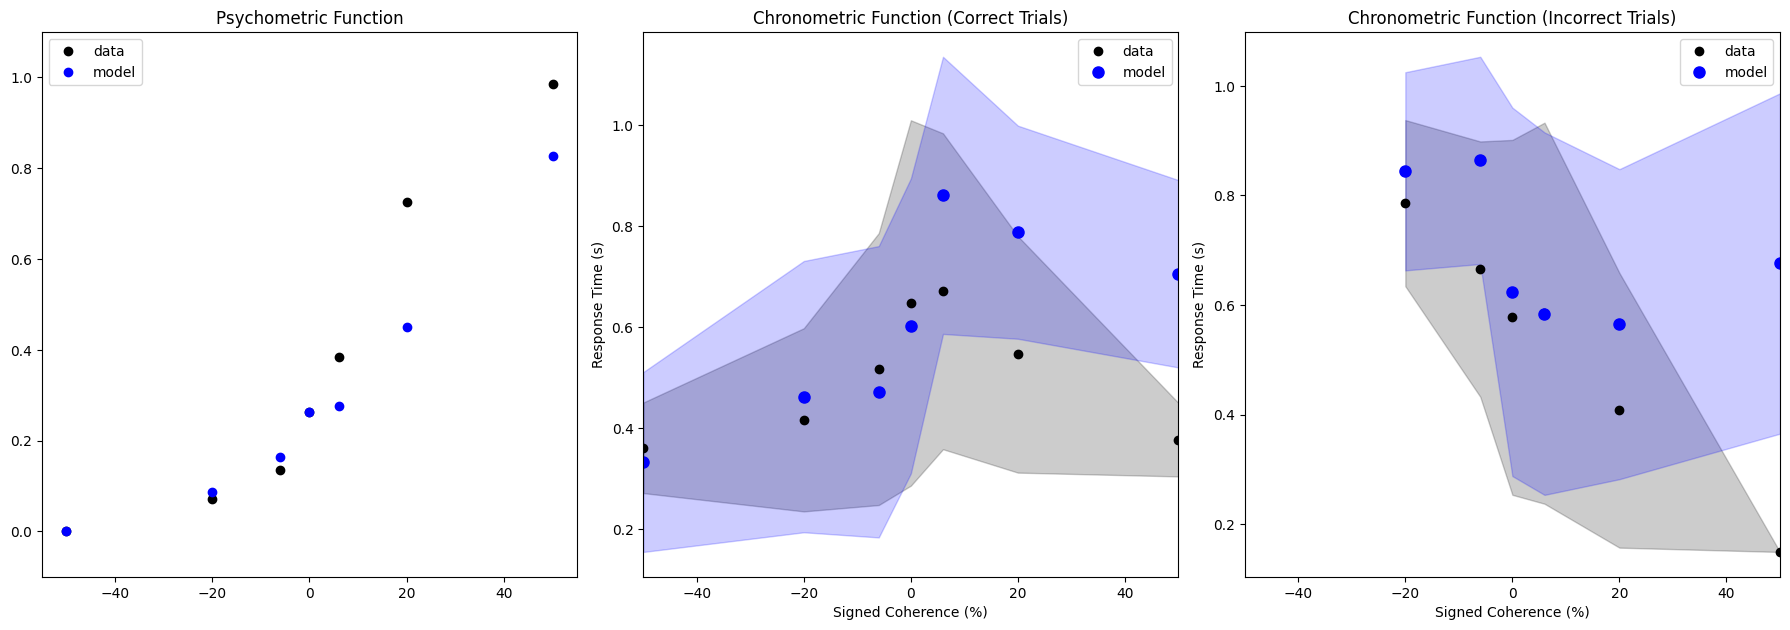

Proportion of invalid trials: 0.003669724770642202
241211_GP_TZ_prior_block_unequal
Skipping session 241211_GP_TZ due to insufficient optimization iterations: 1

Session: 241216_GP_TZ, Prior: equal)
Prior condition 'equal' in session 241216_GP_TZ has 498 trials
a: 2.4483
z: 0.1962
drift_offset: 0.3784
ndt: 0.1239
drift_gain: 6.8286
variance: 4.5854
leak_rate: 0.9861
time_constant: 0.0010
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 80.87343880875625
       x: [ 2.448e+00  1.962e-01  3.784e-01  1.239e-01  6.829e+00
            4.585e+00  9.861e-01  1.045e-03]
     nit: 47
    nfev: 4083
     jac: [ 0.000e+00  0.000e+00  0.000e+00  8.801e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 498 trials.
Valid simulated trials: 498


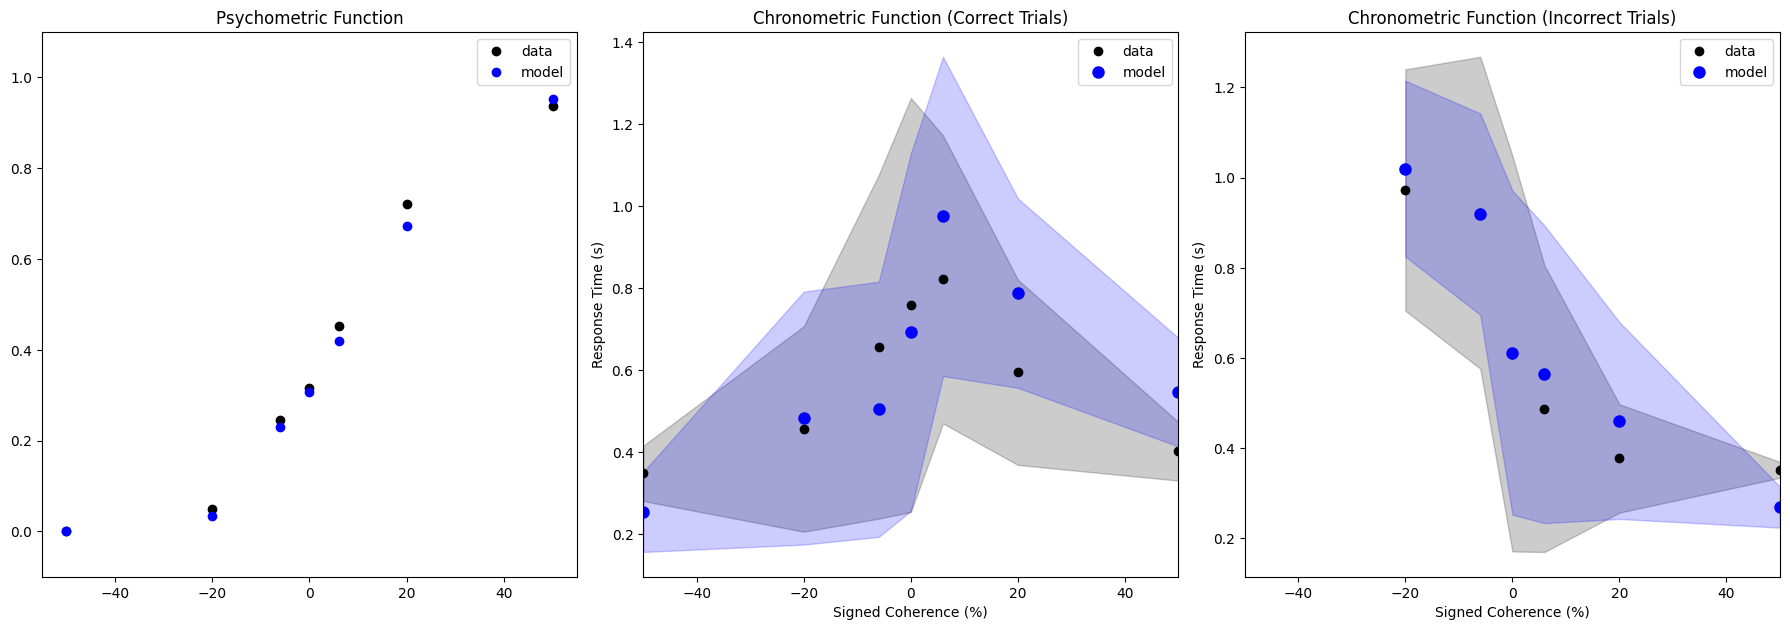

Proportion of invalid trials: 0.0
241216_GP_TZ_prior_block_unequal
Skipping session 241216_GP_TZ due to insufficient optimization iterations: 1

Session: 241217_GP_TZ, Prior: equal)
Prior condition 'equal' in session 241217_GP_TZ has 503 trials
a: 3.0773
z: 0.4588
drift_offset: 0.3965
ndt: 0.1000
drift_gain: 6.9298
variance: 4.8015
leak_rate: 0.2318
time_constant: 0.0014
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 81.92377527182393
       x: [ 3.077e+00  4.588e-01  3.965e-01  1.000e-01  6.930e+00
            4.801e+00  2.318e-01  1.422e-03]
     nit: 35
    nfev: 2898
     jac: [ 0.000e+00  0.000e+00  0.000e+00  3.708e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 503 trials.
Valid simulated trials: 503


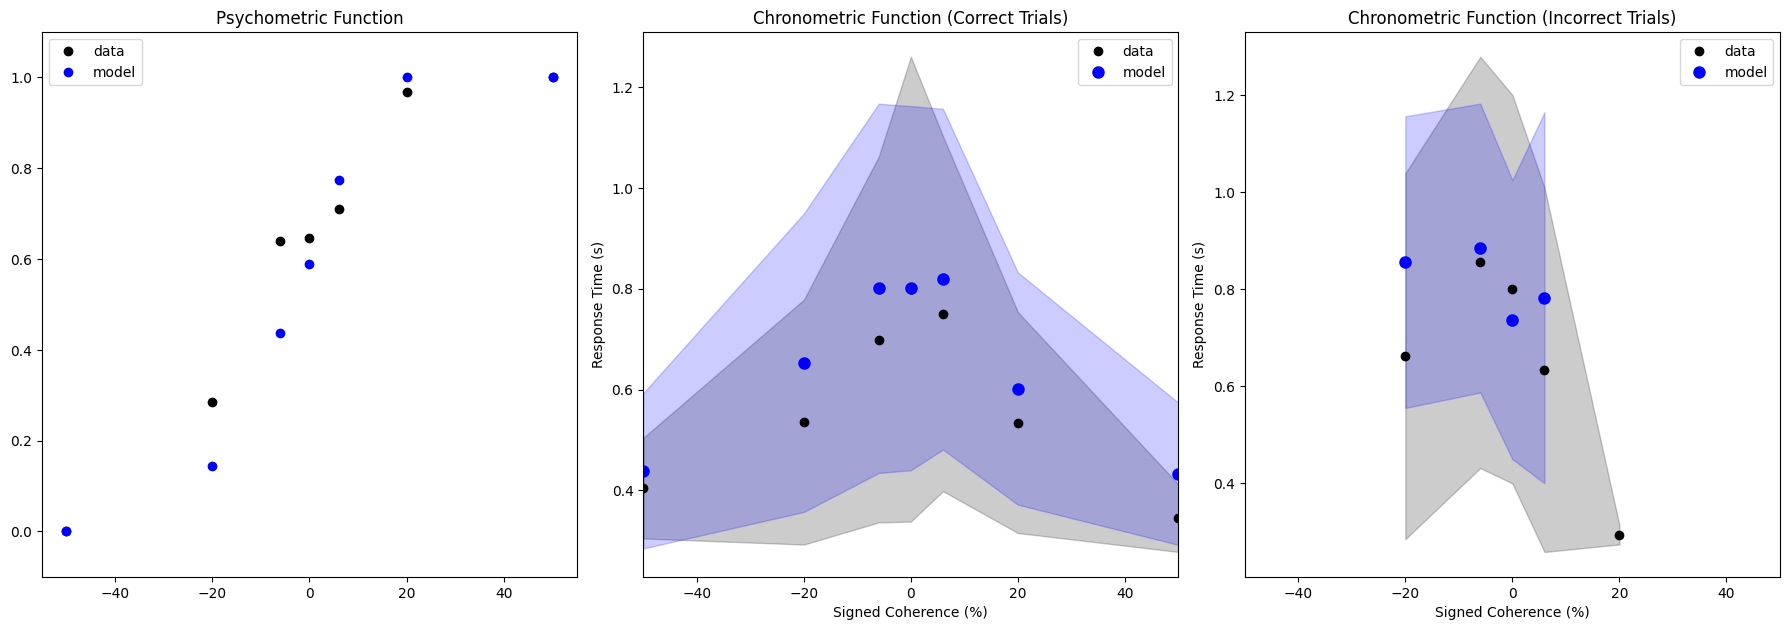

Proportion of invalid trials: 0.0
241217_GP_TZ_prior_block_unequal
Skipping session 241217_GP_TZ due to insufficient optimization iterations: 1

Session: 241223_GP_TZ, Prior: equal)
Prior condition 'equal' in session 241223_GP_TZ has 521 trials
a: 3.2621
z: 0.4676
drift_offset: 0.4410
ndt: 0.1352
drift_gain: 18.6898
variance: 2.9387
leak_rate: 0.3619
time_constant: 0.0010
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 80.30236328669554
       x: [ 3.262e+00  4.676e-01  4.410e-01  1.352e-01  1.869e+01
            2.939e+00  3.619e-01  1.016e-03]
     nit: 38
    nfev: 3129

Simulation completed. Generated 521 trials.
Valid simulated trials: 520


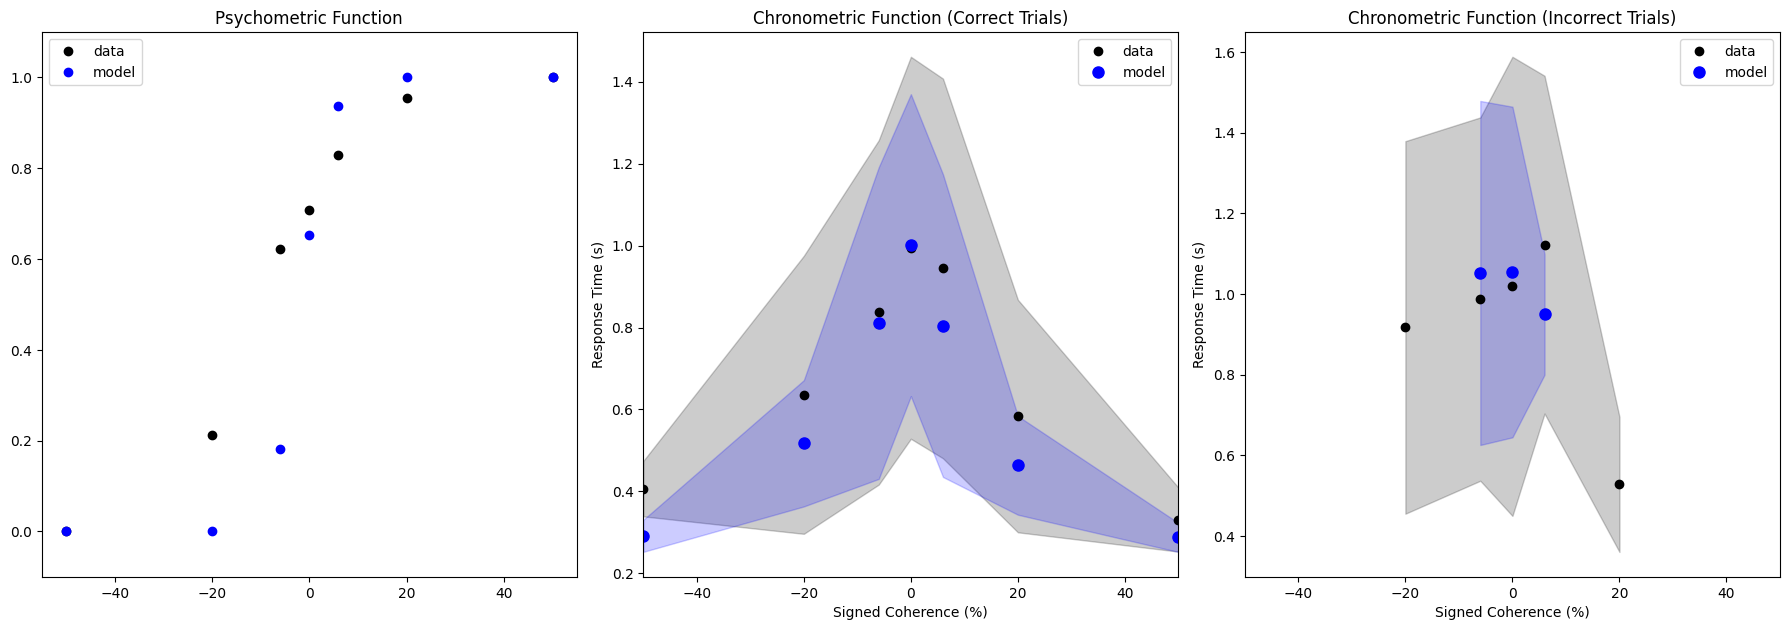

Proportion of invalid trials: 0.0019193857965451055
241223_GP_TZ_prior_block_unequal
Skipping session 241223_GP_TZ due to insufficient optimization iterations: 1

Session: 241227_GP_TZ, Prior: equal)
Prior condition 'equal' in session 241227_GP_TZ has 511 trials
a: 3.3842
z: 0.5089
drift_offset: -0.4051
ndt: 0.1187
drift_gain: 14.8586
variance: 1.2294
leak_rate: 0.9709
time_constant: 0.0013
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 81.13372532804043
       x: [ 3.384e+00  5.089e-01 -4.051e-01  1.187e-01  1.486e+01
            1.229e+00  9.709e-01  1.331e-03]
     nit: 31
    nfev: 2677
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 511 trials.
Valid simulated trials: 510


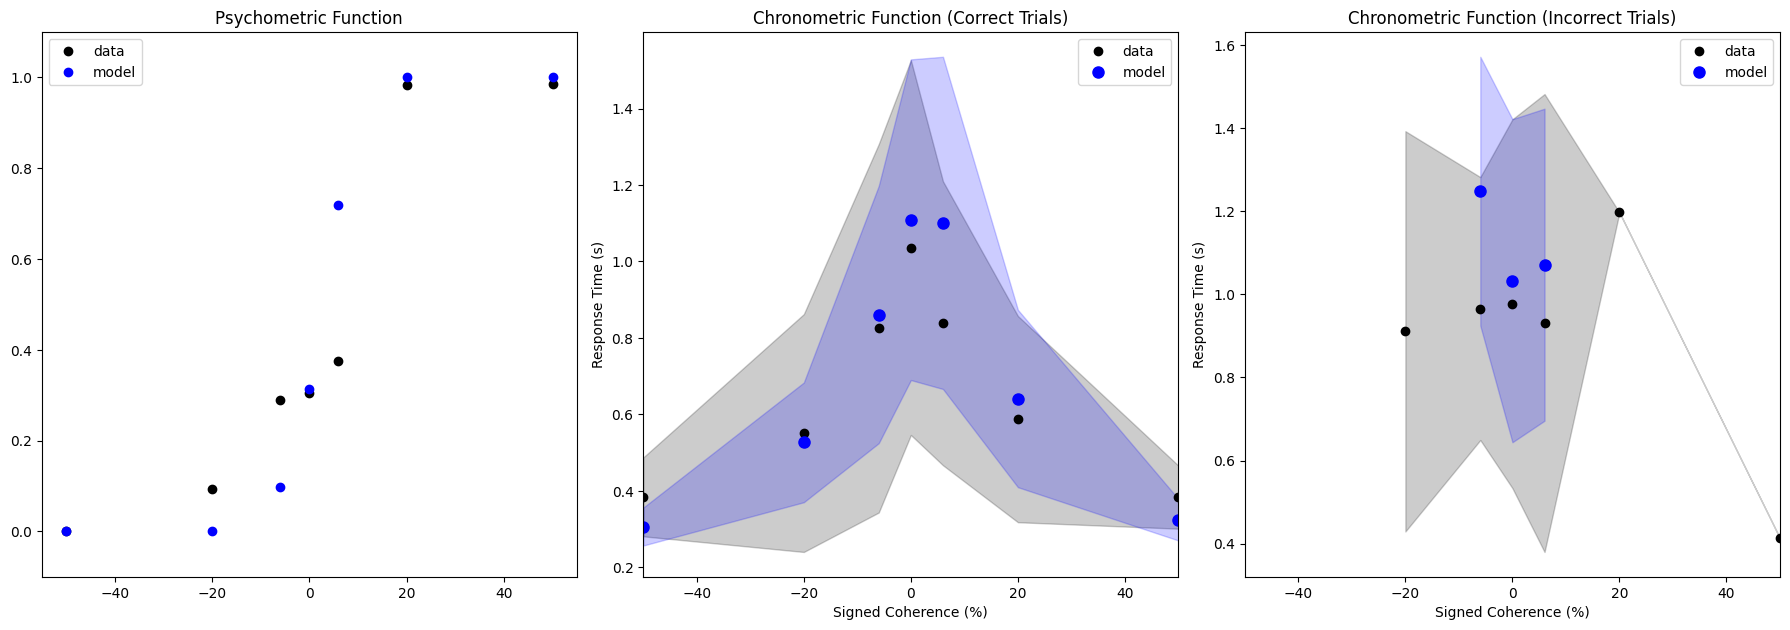

Proportion of invalid trials: 0.0019569471624266144
241227_GP_TZ_prior_block_unequal
Skipping session 241227_GP_TZ due to insufficient optimization iterations: 1

Session: 241230_GP_TZ, Prior: equal)
Prior condition 'equal' in session 241230_GP_TZ has 499 trials
a: 5.5828
z: 0.7466
drift_offset: -0.6591
ndt: 0.1000
drift_gain: 8.7037
variance: 0.9082
leak_rate: 0.9474
time_constant: 0.0025
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 86.13061881082609
       x: [ 5.583e+00  7.466e-01 -6.591e-01  1.000e-01  8.704e+00
            9.082e-01  9.474e-01  2.525e-03]
     nit: 29
    nfev: 2418
     jac: [ 0.000e+00  0.000e+00  0.000e+00  2.321e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 499 trials.
Valid simulated trials: 496


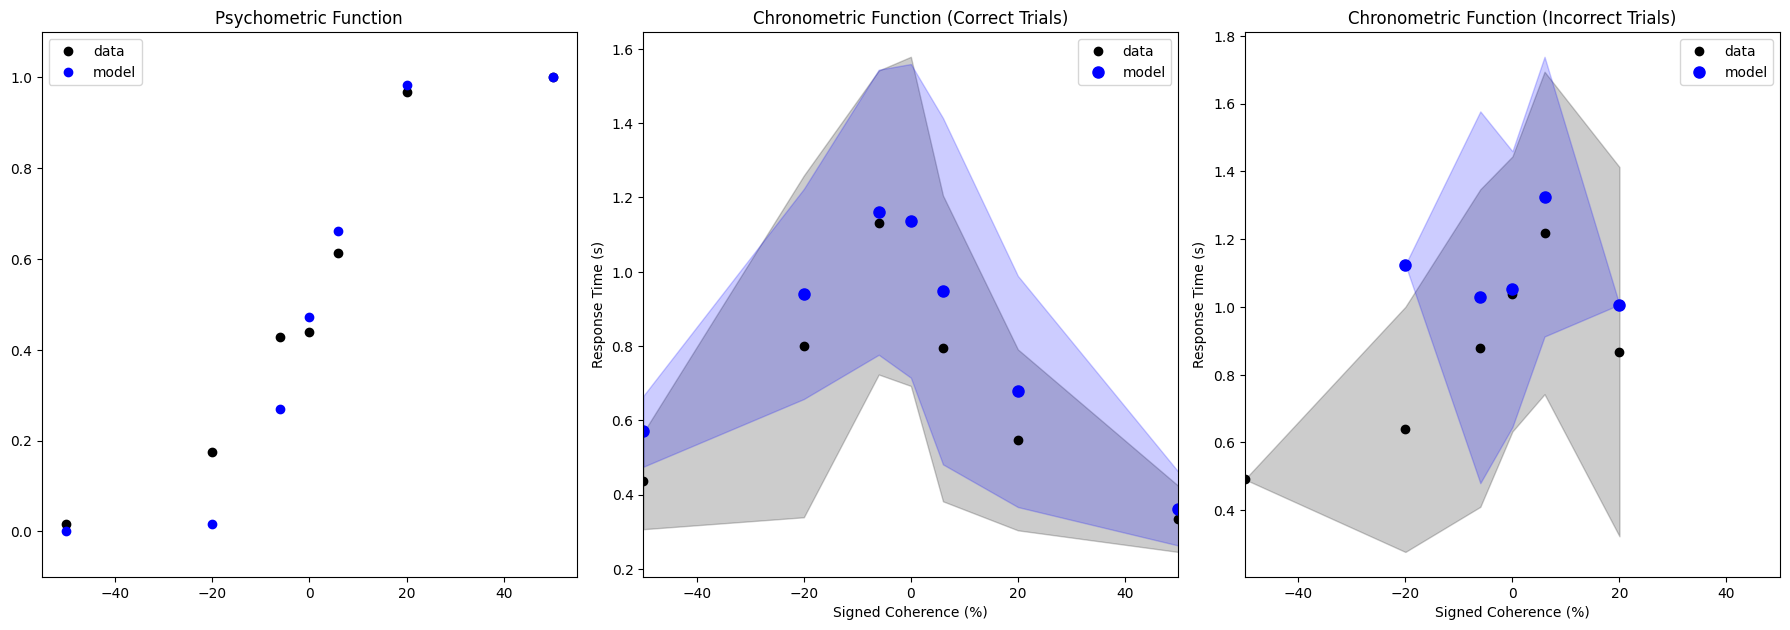

Proportion of invalid trials: 0.006012024048096192
241230_GP_TZ_prior_block_unequal
Skipping session 241230_GP_TZ due to insufficient optimization iterations: 1

Session: 250108_GP_TZ, Prior: equal)
Prior condition 'equal' in session 250108_GP_TZ has 480 trials
a: 4.5045
z: 0.5746
drift_offset: -0.2858
ndt: 0.1000
drift_gain: 13.4341
variance: 1.3571
leak_rate: 0.0118
time_constant: 0.0020
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 86.53603194230439
       x: [ 4.505e+00  5.746e-01 -2.858e-01  1.000e-01  1.343e+01
            1.357e+00  1.183e-02  2.005e-03]
     nit: 28
    nfev: 2338
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
            0.000e+00  0.000e+00  0.000e+00]

Simulation completed. Generated 480 trials.
Valid simulated trials: 480


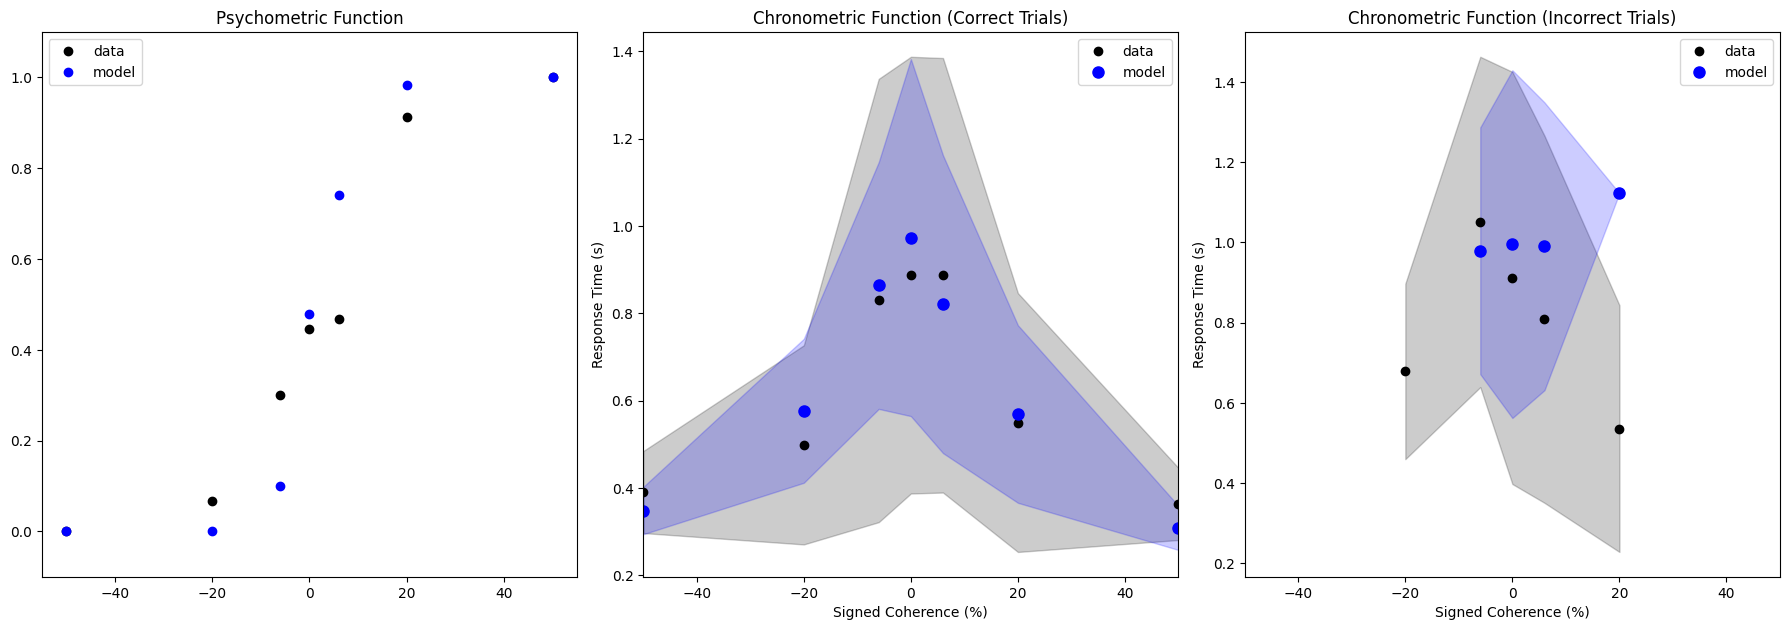

Proportion of invalid trials: 0.0
250108_GP_TZ_prior_block_unequal
Skipping session 250108_GP_TZ due to insufficient optimization iterations: 1

Session: 250109_GP_TZ, Prior: equal)
Prior condition 'equal' in session 250109_GP_TZ has 500 trials
a: 2.7240
z: 0.5449
drift_offset: 0.7569
ndt: 0.1055
drift_gain: 13.0966
variance: 0.9103
leak_rate: 0.5794
time_constant: 0.0015
Optimization Results: message: Optimization terminated successfully.
 success: True
     fun: 62.21718845689939
       x: [ 2.724e+00  5.449e-01  7.569e-01  1.055e-01  1.310e+01
            9.103e-01  5.794e-01  1.528e-03]
     nit: 32
    nfev: 2829

Simulation completed. Generated 500 trials.
Valid simulated trials: 500


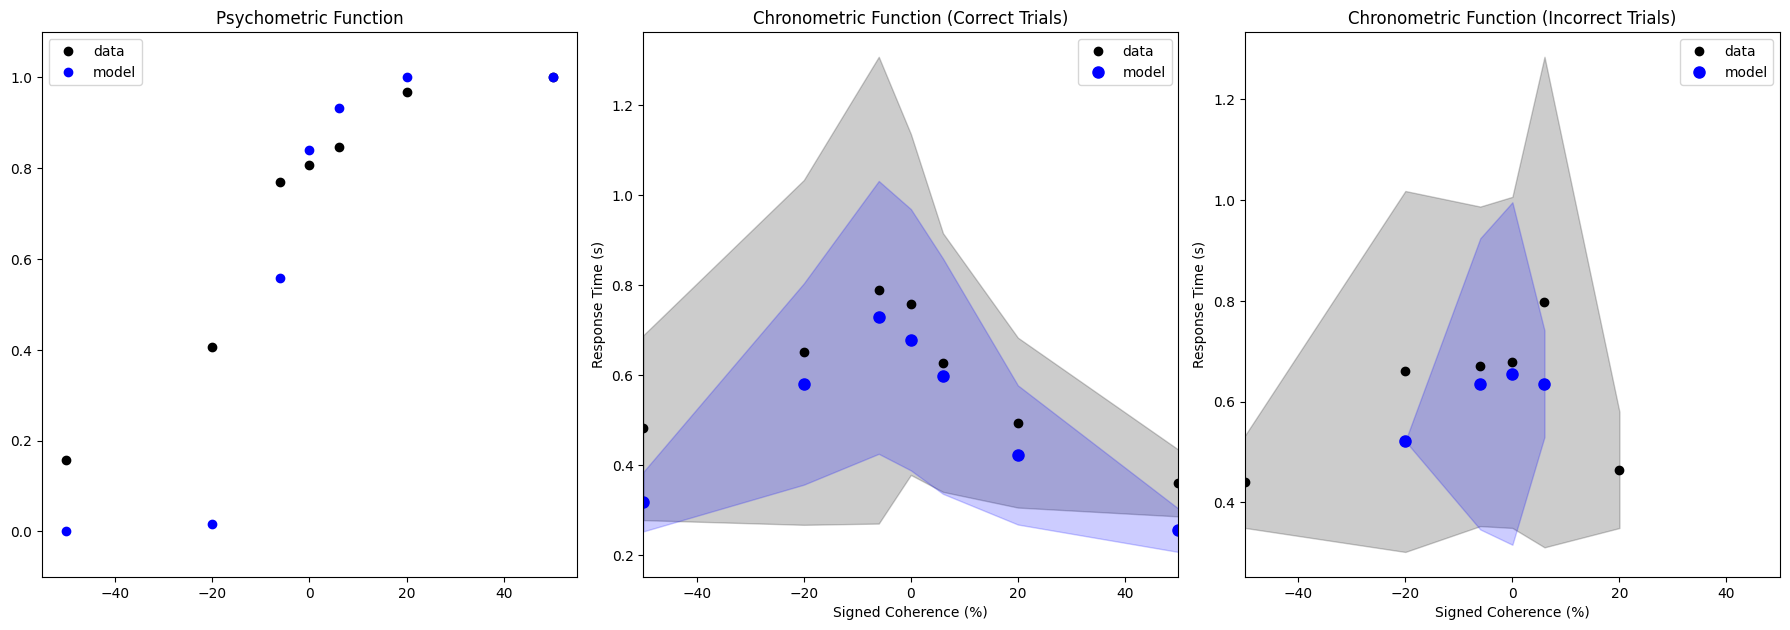

Proportion of invalid trials: 0.0
250109_GP_TZ_prior_block_unequal
Skipping session 250109_GP_TZ due to insufficient optimization iterations: 1


In [29]:
for f in model_files:
    with open(f, "rb") as pkl_file:
        model_dict = pickle.load(pkl_file)
    session_id = model_dict["session_id"]
    session_data = behavior_df[behavior_df["session_id"] == session_id]

    nit = model_dict["results"]["optimization_result"]["nit"]
    if nit < 2:
        print(f"{f.stem}\nSkipping session {session_id} due to insufficient optimization iterations: {nit}")
        continue

    if f.stem.split("_")[-1] == "equal":
        prior = "equal"
        data = session_data[session_data["prob_toRF"] == 50]
    elif f.stem.split("_")[-1] == "unequal":
        prior = "unequal"
        data = session_data[session_data["prob_toRF"] != 50]
    data = data[["signed_coherence", "choice", "rt", "prior_block", "outcome"]]

    # Get stimulus length
    stimulus_length = int(np.max(data["rt"]) * 1000)
    stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length)) / 100

    print(f"\n{'=' * 50}")
    print(f"Session: {session_id}, Prior: {prior})")
    print(f"{'=' * 50}")

    if len(data) == 0:
        print(f"No data found for prior condition: {prior} in session {session_id}")
        continue

    print(f"Prior condition '{prior}' in session {session_id} has {len(data)} trials")


    model_sim = simulate_ddm(model_dict["models"], model_dict["results"], stimulus)

    print(f"Optimization Results:{model_dict['results']['optimization_result']}")
    print(f"\nSimulation completed. Generated {len(model_sim)} trials.")
    print(f"Valid simulated trials: {np.sum(~np.isnan(model_sim['choice']))}")

    # Plot comparison
    plot_ddm_fit(model_sim, data)

## Aggregate Parameter Plots

In [41]:
equal_dict = {"models": [], "results": [], "session_ids": []}
unequal_dict = {"models": [], "results": [], "session_ids": []}

for f in model_files:
    with open(f, "rb") as file:
        model_dict = pickle.load(file)

    model = model_dict["models"]
    result_dict = model_dict["results"]
    session_id = model_dict["session_id"]

    nit = model_dict["results"]["optimization_result"]["nit"]
    if nit < 2:
        print(f"{f.stem}\nSkipping session {session_id} due to insufficient optimization iterations: {nit}")
        continue

    if f.stem.split("_")[-1] == "equal":
        equal_dict["models"].append(model)
        equal_dict["results"].append(result_dict)
        equal_dict["session_ids"].append(session_id)
    elif f.stem.split("_")[-1] == "unequal":
        unequal_dict["models"].append(model)
        unequal_dict["results"].append(result_dict)
        unequal_dict["session_ids"].append(session_id)
    else:
        print("Unknown model file type:", f.name)
print("Total equal model files:", len(equal_dict["models"]))
print("Total unequal model files:", len(unequal_dict["models"]))

210224_GP_JP_prior_block_unequal
Skipping session 210224_GP_JP due to insufficient optimization iterations: 1
210302_GP_JP_prior_block_unequal
Skipping session 210302_GP_JP due to insufficient optimization iterations: 1
240625_GP_TZ_prior_block_unequal
Skipping session 240625_GP_TZ due to insufficient optimization iterations: 1
240627_GP_TZ_prior_block_unequal
Skipping session 240627_GP_TZ due to insufficient optimization iterations: 1
240710_GP_TZ_prior_block_unequal
Skipping session 240710_GP_TZ due to insufficient optimization iterations: 1
241129_GP_TZ_prior_block_unequal
Skipping session 241129_GP_TZ due to insufficient optimization iterations: 1
241130_GP_TZ_prior_block_unequal
Skipping session 241130_GP_TZ due to insufficient optimization iterations: 1
241209_GP_TZ_prior_block_unequal
Skipping session 241209_GP_TZ due to insufficient optimization iterations: 1
241211_GP_TZ_prior_block_unequal
Skipping session 241211_GP_TZ due to insufficient optimization iterations: 1
241216_GP_

In [42]:
params_to_plot = ["a", "z", "drift_offset", "ndt", "drift_gain", "variance", "leak_rate", "time_constant"]
param_names = ["upper boundary (a)", "starting point (z)", "drift offset", "non decision time (ndt)", "drift gain", "variance", "leak rate", "time constant"]

In [43]:
equal_params = {param: [] for param in params_to_plot}
unequal_params = {param: [] for param in params_to_plot}
session_ids = []
for idx, session_id in enumerate(equal_dict["session_ids"]):
    try:
        idx_unequal = unequal_dict["session_ids"].index(session_id)
        session_ids.append(session_id)

        if behavior_df.loc[behavior_df.session_id == session_id, "prior_direction"].iloc[0] == 'L':
            # flip z and drift_offset parameter
            equal_dict["results"][idx]["parameters"]["z"] = 1 - equal_dict["results"][idx]["parameters"]["z"]
            unequal_dict["results"][idx_unequal]["parameters"]["z"] = 1 - unequal_dict["results"][idx_unequal]["parameters"]["z"]
            equal_dict["results"][idx]["parameters"]["drift_offset"] *= -1
            unequal_dict["results"][idx_unequal]["parameters"]["drift_offset"] *= -1

        for param in params_to_plot:
            equal_params[param].append(equal_dict["results"][idx]["parameters"][param])
            unequal_params[param].append(unequal_dict["results"][idx_unequal]["parameters"][param])
    except:
        print(f"Session ID {session_id} not found in unequal dict")

Session ID 210224_GP_JP not found in unequal dict
Session ID 210302_GP_JP not found in unequal dict
Session ID 240625_GP_TZ not found in unequal dict
Session ID 240627_GP_TZ not found in unequal dict
Session ID 240710_GP_TZ not found in unequal dict
Session ID 241129_GP_TZ not found in unequal dict
Session ID 241130_GP_TZ not found in unequal dict
Session ID 241209_GP_TZ not found in unequal dict
Session ID 241211_GP_TZ not found in unequal dict
Session ID 241216_GP_TZ not found in unequal dict
Session ID 241217_GP_TZ not found in unequal dict
Session ID 241223_GP_TZ not found in unequal dict
Session ID 241227_GP_TZ not found in unequal dict
Session ID 241230_GP_TZ not found in unequal dict
Session ID 250108_GP_TZ not found in unequal dict
Session ID 250109_GP_TZ not found in unequal dict


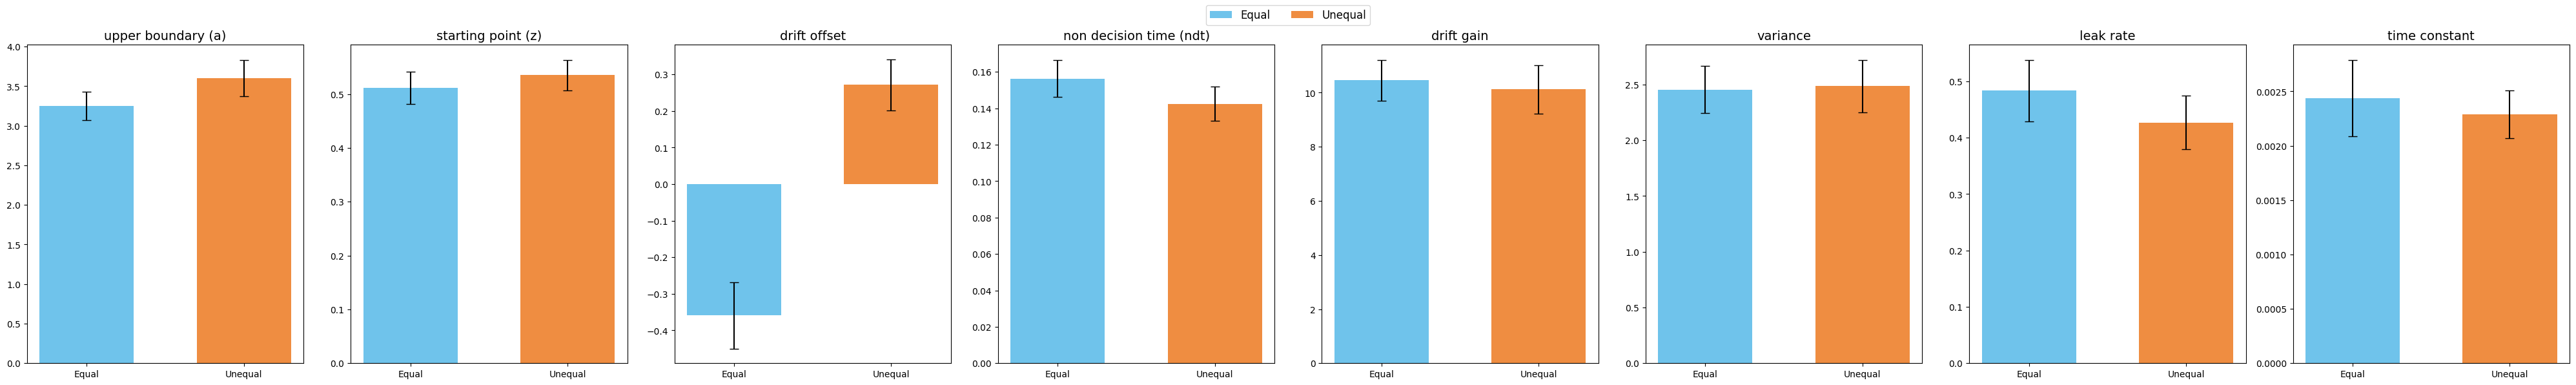

In [44]:
colors = {"Equal": "#6FC3EB", "Unequal": "#EF8D41"}

nrows, ncols = 1, 8
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 6 * nrows))

for idx_param, param in enumerate(params_to_plot):
    if nrows > 1:
        ax = axs[idx_param // ncols, idx_param % ncols]
    else:
        ax = axs[idx_param % ncols]


    means_1 = np.mean(equal_params[param])
    sems_1 = sem(equal_params[param])
    means_2 = np.mean(unequal_params[param])
    sems_2 = sem(unequal_params[param])

    ax.bar(0, means_1, yerr=sems_1, capsize=5, width=0.6, color=colors["Equal"], label="Equal")
    ax.bar(1, means_2, yerr=sems_2, capsize=5, width=0.6, color=colors["Unequal"], label="Unequal")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Equal', 'Unequal'])
    ax.set_title(param_names[idx_param], fontsize=14)

# one shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.show()


In [45]:
equal_params_JP = {param: [] for param in params_to_plot}
unequal_params_JP = {param: [] for param in params_to_plot}
equal_params_TZ = {param: [] for param in params_to_plot}
unequal_params_TZ = {param: [] for param in params_to_plot}
session_ids = []
for idx, session_id in enumerate(equal_dict["session_ids"]):
    try:
        idx_unequal = unequal_dict["session_ids"].index(session_id)
        session_ids.append(session_id)

        for param in params_to_plot:
            if session_id.endswith("JP"):
                equal_params_JP[param].append(equal_dict["results"][idx]["parameters"][param])
                unequal_params_JP[param].append(unequal_dict["results"][idx_unequal]["parameters"][param])
            elif session_id.endswith("TZ"):
                equal_params_TZ[param].append(equal_dict["results"][idx]["parameters"][param])
                unequal_params_TZ[param].append(unequal_dict["results"][idx_unequal]["parameters"][param])
    except:
        print(f"Session ID {session_id} not found in unequal dict")

Session ID 210224_GP_JP not found in unequal dict
Session ID 210302_GP_JP not found in unequal dict
Session ID 240625_GP_TZ not found in unequal dict
Session ID 240627_GP_TZ not found in unequal dict
Session ID 240710_GP_TZ not found in unequal dict
Session ID 241129_GP_TZ not found in unequal dict
Session ID 241130_GP_TZ not found in unequal dict
Session ID 241209_GP_TZ not found in unequal dict
Session ID 241211_GP_TZ not found in unequal dict
Session ID 241216_GP_TZ not found in unequal dict
Session ID 241217_GP_TZ not found in unequal dict
Session ID 241223_GP_TZ not found in unequal dict
Session ID 241227_GP_TZ not found in unequal dict
Session ID 241230_GP_TZ not found in unequal dict
Session ID 250108_GP_TZ not found in unequal dict
Session ID 250109_GP_TZ not found in unequal dict


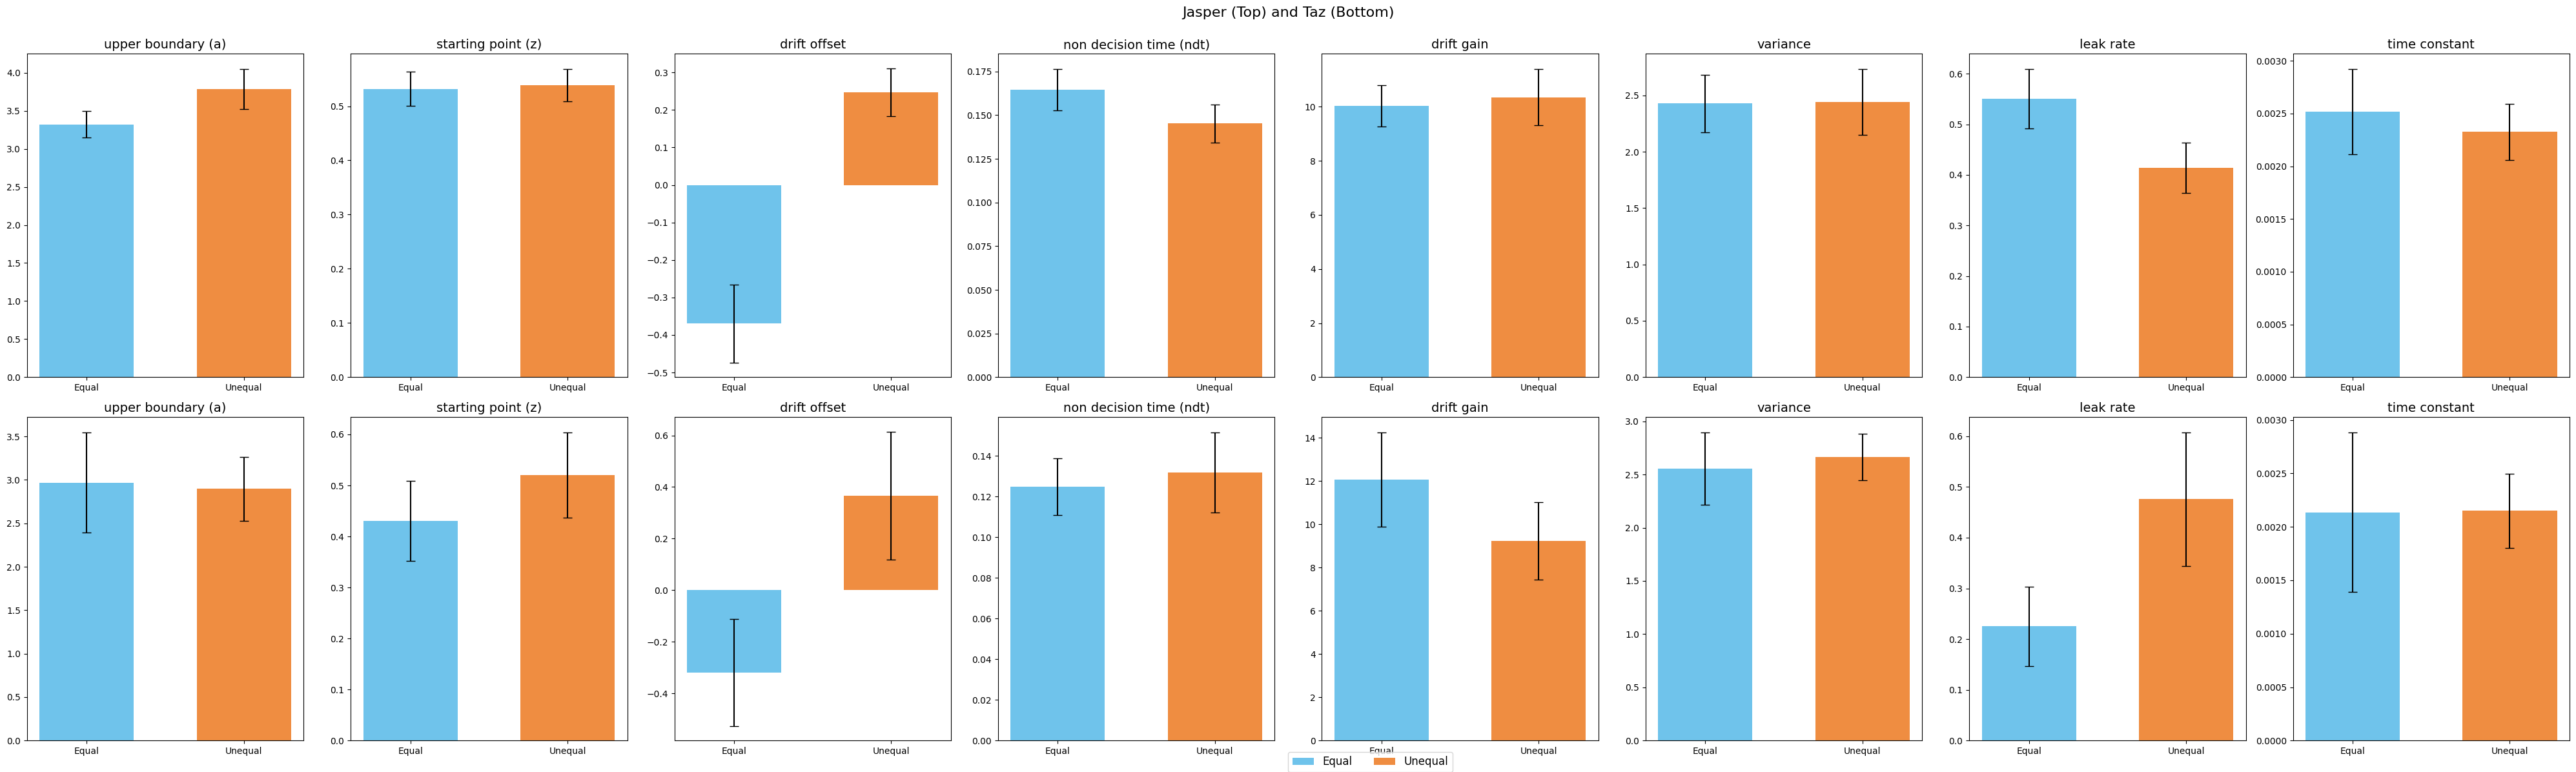

In [65]:
colors = {"Equal": "#6FC3EB", "Unequal": "#EF8D41"}

nrows, ncols = 2, 8
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 6 * nrows))

for idx_param, param in enumerate(params_to_plot):
    if nrows > 1:
        ax = axs[idx_param // ncols, idx_param % ncols]
    else:
        ax = axs[idx_param % ncols]


    means_1_JP = np.mean(equal_params_JP[param])
    sems_1_JP = sem(equal_params_JP[param])
    means_2_JP = np.mean(unequal_params_JP[param])
    sems_2_JP = sem(unequal_params_JP[param])

    axs[0, idx_param % ncols].bar(0, means_1_JP, yerr=sems_1_JP, capsize=5, width=0.6, color=colors["Equal"], label="Equal")
    axs[0, idx_param % ncols].bar(1, means_2_JP, yerr=sems_2_JP, capsize=5, width=0.6, color=colors["Unequal"], label="Unequal")

    axs[0, idx_param % ncols].set_xticks([0, 1])
    axs[0, idx_param % ncols].set_xticklabels(["Equal", "Unequal"])
    axs[0, idx_param % ncols].set_title(param_names[idx_param], fontsize=14)

    means_1_TZ = np.mean(equal_params_TZ[param])
    sems_1_TZ = sem(equal_params_TZ[param])
    means_2_TZ = np.mean(unequal_params_TZ[param])
    sems_2_TZ = sem(unequal_params_TZ[param])

    axs[1, idx_param % ncols].bar(0, means_1_TZ, yerr=sems_1_TZ, capsize=5, width=0.6, color=colors["Equal"], label="Equal")
    axs[1, idx_param % ncols].bar(1, means_2_TZ, yerr=sems_2_TZ, capsize=5, width=0.6, color=colors["Unequal"], label="Unequal")

    axs[1, idx_param % ncols].set_xticks([0, 1])
    axs[1, idx_param % ncols].set_xticklabels(["Equal", "Unequal"])
    axs[1, idx_param % ncols].set_title(param_names[idx_param], fontsize=14)

# one shared legend
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc=[0.5,0], ncol=2, fontsize=12)
plt.suptitle("Jasper (Top) and Taz (Bottom)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])  # leave space for legend

plt.show()
